1. Energy consumption section
2. Weather data section
3. Future prediction

In [36]:
import tensorflow 
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from keras import callbacks
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import joblib
from tensorflow import keras

# Functions

In [37]:
# energy consumption 

def scaleAllData(df):
    allScalers = []
    for column in df.columns:
        df1 = df[column]
        scaler = MinMaxScaler(feature_range=(0,1))
        df[column] = scaler.fit_transform(np.array(df1.values.reshape(-1, 1)))
        allScalers.append(scaler)
    return df, allScalers

In [38]:
#energy consumption
def saveScalers(colNames, allScalers):
    i = 0
    for scaler in allScalers:
        scaler_filename = colNames[i] + ".save"
#         print(scaler_filename)
        joblib.dump(scaler, scaler_filename)
        i+=1

In [39]:
#energy consumption
def df_to_X_y(df, megawattsPos, window_size= 1): #1 day of feature data
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-1):
        row = [ r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][megawattsPos] 
        y.append(label)
    return np.array(X), np.array(y)

In [40]:
#weather data
def df_to_X_y_weather(df, predictValuePos, window_size= 1): #1 day of feature data
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [ r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][predictValuePos] 
        y.append(label)
    return np.array(X), np.array(y)

In [41]:
#weather data

# getting the day cos data for the next 24 hours for prediction
def prepareCircularTimeData(df, colName, howManyHours, timeSteps):
    
    # has last 3 hours of december 31st
    previousDaysData = np.array(df[colName][8757:][0:]).reshape(1,-1)
    previousDaysSin = np.array(df['Day sin'][8757:][0:]).reshape(1,-1)
    previousDaysCos = np.array(df['Day cos'][8757:][0:]).reshape(1,-1)
    previousYearsSin = np.array(df['Year sin'][8757:][0:]).reshape(1,-1)
    previousYearsCos = np.array(df['Year cos'][8757:][0:]).reshape(1,-1)

    previousDaysData = list(previousDaysData)[0].tolist()
    previousDaysSin = list(previousDaysSin)[0].tolist()
    previousDaysCos = list(previousDaysCos)[0].tolist()
    previousYearsSin = list(previousYearsSin)[0].tolist()
    previousYearsCos = list(previousYearsCos)[0].tolist()

    futurePredData = []
    for i in range(timeSteps):
        mem = []
        mem.append(previousDaysData[i])
        mem.append(previousDaysSin[i])
        mem.append(previousDaysCos[i])
        mem.append(previousYearsSin[i])
        mem.append(previousYearsCos[i])
        futurePredData.append(mem)
    
    # Day sin, Day cos, Year sin, Year cos
    # Need these in addition to the weather data variable information for circular time
    startPos = 0
    endPos = 24

    previousDaysSin = np.array(df['Day sin'][startPos:endPos][0:]).reshape(1,-1)
    previousDaysCos = np.array(df['Day cos'][startPos:endPos][0:]).reshape(1,-1)
    previousYearsSin = np.array(df['Year sin'][startPos:endPos][0:]).reshape(1,-1)
    previousYearsCos = np.array(df['Year cos'][startPos:endPos][0:]).reshape(1,-1)

    previousDaysSin = list(previousDaysSin)[0].tolist()
    previousDaysCos = list(previousDaysCos)[0].tolist()
    previousYearsSin = list(previousYearsSin)[0].tolist()
    previousYearsCos = list(previousYearsCos)[0].tolist()

    for i in range(endPos):
        mem = []
        mem.append(previousDaysSin[i])
        mem.append(previousDaysCos[i])
        mem.append(previousYearsSin[i])
        mem.append(previousYearsCos[i])
        futurePredData.append(mem)
    
#     print(np.array(futurePredData))
    return futurePredData
    

In [42]:
#weather data 
def futurePredictions_weather(model, data, hourPred, timesteps, numVars):
    future_outputs=[]
    i=0
    beg = 0
    end = 3
    while(i < hourPred): #for the next however many hours
        oneStep = np.array(list(data[beg:end])).reshape(1, timesteps, numVars) #1 list, each index has n_steps (3) of numVars (5) data
        yhat = model.predict(oneStep, verbose=0)#.flatten()
        future_outputs.append(yhat[0][0])
        data[end].insert(0, yhat[0][0])
        beg += 1
        end += 1
        i+=1

    return future_outputs

In [56]:
def futurePredictions_all(model, lastDay_input, weatherData, hourPred, timesteps, numVars):
    future_outputs=[]
    i=0
    counter = 0
    while(i<hourPred): #for the next thirty hours
        if i == 0: #for the first new predicted value, using old weather data to predict new value 
            lastDay_input = np.array(lastDay_input)
            lastDay_input = lastDay_input.reshape(1, timesteps, numVars)
            yhat = model.predict(lastDay_input, verbose=0)#.flatten()
            print(yhat[0])
#             future_outputs.extend(yhat.tolist())
            future_outputs.append(yhat[0][0])
            i=i+1
        else:# then take from the 1 position and getting the new input and putting it into input
#             print(future_outputs[counter])
            setVal = future_outputs[counter].item()
            weatherData.at[counter, -1:] = setVal #set the megawatts val from the prev predicted
            oneData = np.array(weatherData.iloc[counter, :]) #one day of data 
#             print("{} hour input {}".format(1, oneData))
            oneData = oneData.reshape((1, timesteps, numVars)) #works
            yhat = model.predict(oneData, verbose=0)
#             print("{} hour output {}".format(i,yhat))
#             future_outputs.extend(yhat.tolist())
            future_outputs.append(yhat[0][0])
            i=i+1
            counter+=1

    return future_outputs

In [57]:
def prepareDf(columns):
    directory = '/Users/yukahatori/A_Fairness/FairnessML_git/NOAA_and_CAISO_Data_ONEYEAR/'
    dataFiles = [f for f in listdir(directory) if isfile(join(directory, f))] 
    for file in dataFiles:
        df = pd.read_csv(directory + file)
    #for now, I will only use SF data 
    location = '_SAC'
    fileRead = directory + dataFiles[0]
    print('fileRead: ', fileRead)
    df = pd.read_csv(fileRead)

    df['date'] = pd.to_datetime(df['date'], format='%m-%dT%H:%M:%S')
    df['date']= df["date"].map(lambda x: x.replace(year=2019))
    df.index = df['date']
    df.drop('date', axis=1, inplace=True)

    ################################################ preprocess #########################################################
    df, allScalers = scaleAllData(df)
    colNames = df.columns
    
    saveScalers(colNames, allScalers) #saving scalers
    
    df['Seconds'] = df.index.map(pd.Timestamp.timestamp)
    day = 60 * 60 * 24 #60 s in a min, 60 min in an hour, 24 hours in a day
    year = 365.2425*day #num seconds in a year
    df['Day sin'] = np.sin(df['Seconds']*2*(np.pi/day))
    df['Day cos'] = np.cos(df['Seconds']*2*(np.pi/day))
    df['Year sin'] = np.sin(df['Seconds']*2*(np.pi/year))
    df['Year cos'] = np.cos(df['Seconds']*2*(np.pi/year))

    df = df.drop('Seconds', axis = 1)

    cols = columns
    df = df[cols]
    return df

In [58]:
def energyConsumptionModel(df, numEpochs):
    megawattsPos = 30
    X, y = df_to_X_y(df, megawattsPos, 1) 
    #############################################train and test #########################################################
    train_percent = 0.9
    validation_percent = 0.1

    train_percent_split = int(train_percent * len(X))
    validation_percent_split = int(validation_percent * len(X)) + train_percent_split
    print(validation_percent_split)

    X_train, y_train = X[:train_percent_split], y[:train_percent_split]
    X_val, y_val = X[train_percent_split:validation_percent_split], y[train_percent_split:validation_percent_split] #validation

    # just gonna have it hold like 1 day of prev data 
    testData = 8760 - 2
    X_test, y_test = X[testData:], y[testData:]

    # X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

    ############################################# create model #########################################################
    model = Sequential()
    model.add(LSTM(64,input_shape=(X_train.shape[1],X_train.shape[2]))) # input layer; 31 data inputs, 1 step (1 hr)
    model.add(Dense(32, 'relu')) #hidden layer 1
    model.add(Dense(32, 'relu')) #hidden layer 2
    model.add(Dense(1, 'linear')) #output layer

    storeModel = '/Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model'
    cp = ModelCheckpoint(storeModel, save_best_only = True) #I want to only save the best model (lowest validation loss)
    model.compile(loss = MeanSquaredError(), optimizer = Adam(), metrics = [RootMeanSquaredError()])

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = numEpochs, callbacks = [cp])

    train_predictions = model.predict(X_train).flatten()
    train_results = pd.DataFrame(data = {'Train Predictions': train_predictions, 'Actuals':y_train})
    rmse = mean_squared_error(train_predictions, y_train, squared=False)
    print("RMSE value: ", rmse)
    return rmse, model

In [59]:
def getBestEnergyConsumptionModel(iters, df, numEpochs):
    getBest = {}
    for i in range(iters):
        rmse, model = energyConsumptionModel(df, numEpochs)
        getBest.update({rmse:model})
    lowestRmse = min(getBest.keys())
    return getBest[lowestRmse]
    

In [60]:
def weatherVariableModel(df, window_size, column, numEpochs):
    ################### get a variable to predict for ##################
    getCols = ['Day sin', 'Day cos', 'Year sin', 'Year cos']
    getCols.append(column)
    col = df[getCols]
    predictColPos = len(col.columns) - 1
    X1, y1 = df_to_X_y_weather(col, predictColPos, window_size)

    ################## split data ##################
    train_percent = 0.9
    validation_percent = 0.1
    train_percent_split = int(train_percent * len(X1))
    validation_percent_split = int(validation_percent * len(X1)) + train_percent_split

    X_train1, y_train1 = X1[:train_percent_split], y1[:train_percent_split]
    X_val1, y_val1 = X1[train_percent_split:validation_percent_split], y1[train_percent_split:validation_percent_split] #validation

    # just gonna have it hold like 1 day of prev data 
    testData = validation_percent_split - 2
    X_test1, y_tes1t = X1[testData:], y1[testData:]

    numDataInputs = X_train1.shape[1]
    numSteps = X_train1.shape[2]
    
    ################## Model Creation ##################
    modelx = Sequential()
    modelx.add(LSTM(64,input_shape=(numDataInputs, numSteps))) # input layer; 5 data inputs, 3 step (3 hr)
    modelx.add(Dense(32, 'relu')) #hidden layer 1
    modelx.add(Dense(32, 'relu')) #hidden layer 2
    modelx.add(Dense(1, 'linear')) #output layer
    storeModel = '/Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/'
    cpx = ModelCheckpoint(storeModel, save_best_only = True) #I want to only save the best model (lowest validation loss)
    modelx.compile(loss = MeanSquaredError(), optimizer = Adam(), metrics = [RootMeanSquaredError()])

    modelx.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs = numEpochs, callbacks = [cpx])
    train_predictions = modelx.predict(X_train1).flatten()
    rmse = mean_squared_error(train_predictions, y_train1, squared=False)
    print("RMSE value: ", rmse)
    return rmse, modelx
    

In [61]:
def getBestWeatherModels(df, window_size, columns, numEpochs, iters):
    getBest = []
    for column in columns:
        getBestOneVar = {}
        for i in range(iters):
            rmse, model = weatherVariableModel(df, window_size, column, numEpochs)
            getBestOneVar.update({rmse:model})
        #now store the best one for that variables
        lowestRmse = min(getBestOneVar.keys())
        getBest.append(getBestOneVar[lowestRmse])
    return getBest

In [62]:
def bestPerformingModel(howManyFutureHours, window_size, numEpochs, iters, columnsForDf, columns):
    df = prepareDf(columnsForDf)
    bestEnergyConsumptionModel = getBestEnergyConsumptionModel(iters, df, numEpochs)
    directory = 'Best/'
    bestEnergyConsumptionModel.save(directory+'energyModel', save_format = 'utf')
    print("--------------------------------- SAVED BEST ENERGY CONSUMPTION MODEL -----------------------------------")
    #we only want weather variable prediction, so only pass the correct stuff
    
    bestWeatherDataModels = getBestWeatherModels(df, window_size, columns, numEpochs, iters)
    
    #save the models
    j = 0
    for weatherModel in bestWeatherDataModels:
        weatherModel.save(directory+columns[j], save_format = 'utf')
        j+=1
    
    i = 0
    numVars = 5 # 3 time steps, 5 variables (for weather variable prediction)
    allVarFuturePreds = []
    for column in columns:
        futurePredData = prepareCircularTimeData(df, column, howManyFutureHours, window_size)
        future_outputs = futurePredictions_weather(bestWeatherDataModels[i], futurePredData, howManyFutureHours, window_size, numVars)
        allVarFuturePreds.append(future_outputs)
        i+=1

    df2 = pd.DataFrame(allVarFuturePreds)
    df2 = df2.T
    df2.columns = columns
    # df2.to_csv('weatherPred.csv', encoding='utf-8', index = False) #MIGHT HAVE TO CHANGE THIS TO weatherPred + i

    ########################################## FUTURE PREDICTION #######################################################
    weatherPred = df2
    daySin = df['Day sin'][0:24]
    dayCos = df['Day cos'][0:24]
    yearSin = df['Year sin'][0:24]
    yearCos = df['Year cos'][0:24]

    addFiles = [daySin, dayCos, yearSin, yearCos]
    weatherPred['Day sin'] = daySin.values
    weatherPred['Day cos'] = dayCos.values
    weatherPred['Year sin'] = yearSin.values
    weatherPred['Year cos'] = yearCos.values
    weatherPred['Megawatts_2020'] = 0

    lastDay = df[-1:]
    lst_output = futurePredictions_all(bestEnergyConsumptionModel, lastDay, weatherPred, 24, 1, 31)

    ########################################### check output #######################################################
    scaler_filename = 'Megawatts_2019.save'
    megawattsScaler = joblib.load(scaler_filename)

    predictedVals = megawattsScaler.inverse_transform(np.array(lst_output).reshape(-1,1))
    predicted24Hours = pd.DataFrame(predictedVals)

    check_directory = '/Users/yukahatori/A_Fairness/FairnessML_git/NOAA_and_CAISO_Data_2020/'
    compFiles = [f for f in listdir(check_directory) if isfile(join(check_directory, f))] 
    flies = []
    for file in compFiles:
    #     print(file)
        flies.append(check_directory + file)
    df1 = pd.read_csv(flies[2])
    actual24Hours = df1['Megawatts_2020'][:24]

    print("----------------------------FINAL, DONE;----------------------------")
    plt.plot(actual24Hours, color = 'blue')
    plt.plot(predicted24Hours, color = 'red')
    plt.show()

    rmse = mean_squared_error(actual24Hours, predicted24Hours, squared=False)
    print("RMSE value: ", rmse)

# Testing

fileRead:  /Users/yukahatori/A_Fairness/FairnessML_git/NOAA_and_CAISO_Data_ONEYEAR/SAC-NOAA-and-Megawatts.csv
8758


2022-03-20 21:37:11.797955: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0118 - root_mean_squared_error: 0.1085

2022-03-20 21:37:16.685876: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 7s 19ms/step - loss: 0.0111 - root_mean_squared_error: 0.1056 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0428
Epoch 2/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0477

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0023 - root_mean_squared_error: 0.0474 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340
Epoch 3/20
242/247 [============================>.] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0341

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0012 - root_mean_squared_error: 0.0340 - val_loss: 4.1420e-04 - val_root_mean_squared_error: 0.0204
Epoch 4/20
236/247 [===========================>..] - ETA: 0s - loss: 6.3982e-04 - root_mean_squared_error: 0.0253

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 4s 18ms/step - loss: 6.4560e-04 - root_mean_squared_error: 0.0254 - val_loss: 4.1324e-04 - val_root_mean_squared_error: 0.0203
Epoch 5/20
236/247 [===========================>..] - ETA: 0s - loss: 5.2542e-04 - root_mean_squared_error: 0.0229

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 7s 28ms/step - loss: 5.3933e-04 - root_mean_squared_error: 0.0232 - val_loss: 3.1310e-04 - val_root_mean_squared_error: 0.0177
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 4.9131e-04 - root_mean_squared_error: 0.0222 - val_loss: 8.0620e-04 - val_root_mean_squared_error: 0.0284
Epoch 7/20
244/247 [============================>.] - ETA: 0s - loss: 4.8273e-04 - root_mean_squared_error: 0.0220

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 5s 19ms/step - loss: 4.8189e-04 - root_mean_squared_error: 0.0220 - val_loss: 2.9612e-04 - val_root_mean_squared_error: 0.0172
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 4.7230e-04 - root_mean_squared_error: 0.0217 - val_loss: 5.5393e-04 - val_root_mean_squared_error: 0.0235
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 4.5914e-04 - root_mean_squared_error: 0.0214 - val_loss: 4.2033e-04 - val_root_mean_squared_error: 0.0205
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 4.4838e-04 - root_mean_squared_error: 0.0212 - val_loss: 6.2169e-04 - val_root_mean_squared_error: 0.0249
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 3.9613e-04 - root_mean_squared_error: 0.0199 - val_loss: 3.0031e-04 - val_root_mean_squared_error: 0.0173
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1368e-04 - root_mean_squared_er

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 4s 17ms/step - loss: 3.5800e-04 - root_mean_squared_error: 0.0189 - val_loss: 2.9380e-04 - val_root_mean_squared_error: 0.0171
Epoch 14/20
224/247 [==========================>...] - ETA: 0s - loss: 3.5195e-04 - root_mean_squared_error: 0.0188

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 5s 20ms/step - loss: 3.5438e-04 - root_mean_squared_error: 0.0188 - val_loss: 2.7909e-04 - val_root_mean_squared_error: 0.0167
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 3.5942e-04 - root_mean_squared_error: 0.0190 - val_loss: 4.1997e-04 - val_root_mean_squared_error: 0.0205
Epoch 16/20
245/247 [============================>.] - ETA: 0s - loss: 3.1491e-04 - root_mean_squared_error: 0.0177

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 4s 16ms/step - loss: 3.1460e-04 - root_mean_squared_error: 0.0177 - val_loss: 2.7501e-04 - val_root_mean_squared_error: 0.0166
Epoch 17/20
231/247 [===========================>..] - ETA: 0s - loss: 2.9841e-04 - root_mean_squared_error: 0.0173

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.9506e-04 - root_mean_squared_error: 0.0172 - val_loss: 2.1748e-04 - val_root_mean_squared_error: 0.0147
Epoch 18/20
247/247 [==============================] - 0s 2ms/step - loss: 2.9342e-04 - root_mean_squared_error: 0.0171 - val_loss: 3.4450e-04 - val_root_mean_squared_error: 0.0186
Epoch 19/20
247/247 [==============================] - 0s 2ms/step - loss: 2.8193e-04 - root_mean_squared_error: 0.0168 - val_loss: 4.3097e-04 - val_root_mean_squared_error: 0.0208
Epoch 20/20
247/247 [==============================] - 0s 2ms/step - loss: 2.3748e-04 - root_mean_squared_error: 0.0154 - val_loss: 2.8866e-04 - val_root_mean_squared_error: 0.0170
RMSE value:  0.017679508095926826
8758
Epoch 1/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0156 - root_mean_squared_error: 0.1250

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0147 - root_mean_squared_error: 0.1214 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0426
Epoch 2/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0482

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0023 - root_mean_squared_error: 0.0479 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0371
Epoch 3/20
224/247 [==========================>...] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0343

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0011 - root_mean_squared_error: 0.0339 - val_loss: 8.5655e-04 - val_root_mean_squared_error: 0.0293
Epoch 4/20
229/247 [==========================>...] - ETA: 0s - loss: 6.4661e-04 - root_mean_squared_error: 0.0254

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 5s 20ms/step - loss: 6.4208e-04 - root_mean_squared_error: 0.0253 - val_loss: 4.3956e-04 - val_root_mean_squared_error: 0.0210
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 6.0905e-04 - root_mean_squared_error: 0.0247 - val_loss: 6.3424e-04 - val_root_mean_squared_error: 0.0252
Epoch 6/20
241/247 [============================>.] - ETA: 0s - loss: 5.5091e-04 - root_mean_squared_error: 0.0235

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 3s 14ms/step - loss: 5.5027e-04 - root_mean_squared_error: 0.0235 - val_loss: 4.0808e-04 - val_root_mean_squared_error: 0.0202
Epoch 7/20
247/247 [==============================] - 0s 2ms/step - loss: 4.7193e-04 - root_mean_squared_error: 0.0217 - val_loss: 4.3783e-04 - val_root_mean_squared_error: 0.0209
Epoch 8/20
231/247 [===========================>..] - ETA: 0s - loss: 4.6980e-04 - root_mean_squared_error: 0.0217

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.6744e-04 - root_mean_squared_error: 0.0216 - val_loss: 3.3211e-04 - val_root_mean_squared_error: 0.0182
Epoch 9/20
247/247 [==============================] - 0s 2ms/step - loss: 4.3280e-04 - root_mean_squared_error: 0.0208 - val_loss: 4.3570e-04 - val_root_mean_squared_error: 0.0209
Epoch 10/20
243/247 [============================>.] - ETA: 0s - loss: 4.1645e-04 - root_mean_squared_error: 0.0204

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.1659e-04 - root_mean_squared_error: 0.0204 - val_loss: 3.0357e-04 - val_root_mean_squared_error: 0.0174
Epoch 11/20
245/247 [============================>.] - ETA: 0s - loss: 4.1219e-04 - root_mean_squared_error: 0.0203

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.1147e-04 - root_mean_squared_error: 0.0203 - val_loss: 2.7854e-04 - val_root_mean_squared_error: 0.0167
Epoch 12/20
247/247 [==============================] - 0s 2ms/step - loss: 3.8029e-04 - root_mean_squared_error: 0.0195 - val_loss: 4.5617e-04 - val_root_mean_squared_error: 0.0214
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 3.6973e-04 - root_mean_squared_error: 0.0192 - val_loss: 4.1550e-04 - val_root_mean_squared_error: 0.0204
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 3.5304e-04 - root_mean_squared_error: 0.0188 - val_loss: 2.9262e-04 - val_root_mean_squared_error: 0.0171
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 3.3319e-04 - root_mean_squared_error: 0.0183 - val_loss: 3.1387e-04 - val_root_mean_squared_error: 0.0177
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 3.3270e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.7800e-04 - root_mean_squared_error: 0.0167 - val_loss: 2.5165e-04 - val_root_mean_squared_error: 0.0159
Epoch 20/20
247/247 [==============================] - 0s 2ms/step - loss: 3.1734e-04 - root_mean_squared_error: 0.0178 - val_loss: 4.8125e-04 - val_root_mean_squared_error: 0.0219
RMSE value:  0.01734092295173223
8758
Epoch 1/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0230 - root_mean_squared_error: 0.1517

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0217 - root_mean_squared_error: 0.1472 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0499
Epoch 2/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0030 - root_mean_squared_error: 0.0549

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0030 - root_mean_squared_error: 0.0546 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0425
Epoch 3/20
240/247 [============================>.] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0423

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0018 - root_mean_squared_error: 0.0422 - val_loss: 9.1798e-04 - val_root_mean_squared_error: 0.0303
Epoch 4/20
224/247 [==========================>...] - ETA: 0s - loss: 9.1598e-04 - root_mean_squared_error: 0.0303

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 3s 13ms/step - loss: 9.2690e-04 - root_mean_squared_error: 0.0304 - val_loss: 8.8172e-04 - val_root_mean_squared_error: 0.0297
Epoch 5/20
245/247 [============================>.] - ETA: 0s - loss: 6.5335e-04 - root_mean_squared_error: 0.0256

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 3s 13ms/step - loss: 6.5238e-04 - root_mean_squared_error: 0.0255 - val_loss: 5.2444e-04 - val_root_mean_squared_error: 0.0229
Epoch 6/20
234/247 [===========================>..] - ETA: 0s - loss: 5.9524e-04 - root_mean_squared_error: 0.0244

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 5s 22ms/step - loss: 5.9734e-04 - root_mean_squared_error: 0.0244 - val_loss: 4.4051e-04 - val_root_mean_squared_error: 0.0210
Epoch 7/20
224/247 [==========================>...] - ETA: 0s - loss: 5.6173e-04 - root_mean_squared_error: 0.0237

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.5812e-04 - root_mean_squared_error: 0.0236 - val_loss: 3.5352e-04 - val_root_mean_squared_error: 0.0188
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 4.8714e-04 - root_mean_squared_error: 0.0221 - val_loss: 3.5555e-04 - val_root_mean_squared_error: 0.0189
Epoch 9/20
247/247 [==============================] - 0s 2ms/step - loss: 4.8026e-04 - root_mean_squared_error: 0.0219 - val_loss: 3.5637e-04 - val_root_mean_squared_error: 0.0189
Epoch 10/20
247/247 [==============================] - 0s 2ms/step - loss: 4.6945e-04 - root_mean_squared_error: 0.0217 - val_loss: 4.7120e-04 - val_root_mean_squared_error: 0.0217
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 4.1896e-04 - root_mean_squared_error: 0.0205 - val_loss: 9.4403e-04 - val_root_mean_squared_error: 0.0307
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 4.0598e-04 - root_mean_squared_er

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.4873e-04 - root_mean_squared_error: 0.0187 - val_loss: 2.9298e-04 - val_root_mean_squared_error: 0.0171
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 3.6343e-04 - root_mean_squared_error: 0.0191 - val_loss: 4.6824e-04 - val_root_mean_squared_error: 0.0216
Epoch 18/20
247/247 [==============================] - 0s 2ms/step - loss: 3.5922e-04 - root_mean_squared_error: 0.0190 - val_loss: 3.8326e-04 - val_root_mean_squared_error: 0.0196
Epoch 19/20
247/247 [==============================] - 0s 2ms/step - loss: 3.4861e-04 - root_mean_squared_error: 0.0187 - val_loss: 3.6861e-04 - val_root_mean_squared_error: 0.0192
Epoch 20/20
247/247 [==============================] - 0s 2ms/step - loss: 3.3674e-04 - root_mean_squared_error: 0.0184 - val_loss: 6.7782e-04 - val_root_mean_squared_error: 0.0260
RMSE value:  0.022785621427064116
8758
Epoch 1/20
234/247 [===========================>..] - ETA: 0s - los

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0136 - root_mean_squared_error: 0.1165 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0406
Epoch 2/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0491

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0024 - root_mean_squared_error: 0.0491 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0338
Epoch 3/20
243/247 [============================>.] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0354

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0012 - root_mean_squared_error: 0.0353 - val_loss: 7.1452e-04 - val_root_mean_squared_error: 0.0267
Epoch 4/20
240/247 [============================>.] - ETA: 0s - loss: 7.1388e-04 - root_mean_squared_error: 0.0267

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.1086e-04 - root_mean_squared_error: 0.0267 - val_loss: 6.7181e-04 - val_root_mean_squared_error: 0.0259
Epoch 5/20
233/247 [===========================>..] - ETA: 0s - loss: 5.7440e-04 - root_mean_squared_error: 0.0240

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.8880e-04 - root_mean_squared_error: 0.0243 - val_loss: 4.7950e-04 - val_root_mean_squared_error: 0.0219
Epoch 6/20
227/247 [==========================>...] - ETA: 0s - loss: 5.1278e-04 - root_mean_squared_error: 0.0226

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 3s 12ms/step - loss: 5.0993e-04 - root_mean_squared_error: 0.0226 - val_loss: 3.4446e-04 - val_root_mean_squared_error: 0.0186
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 4.7647e-04 - root_mean_squared_error: 0.0218 - val_loss: 6.1662e-04 - val_root_mean_squared_error: 0.0248
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 4.3776e-04 - root_mean_squared_error: 0.0209 - val_loss: 6.4410e-04 - val_root_mean_squared_error: 0.0254
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 4.1552e-04 - root_mean_squared_error: 0.0204 - val_loss: 6.0564e-04 - val_root_mean_squared_error: 0.0246
Epoch 10/20
247/247 [==============================] - 0s 2ms/step - loss: 4.1007e-04 - root_mean_squared_error: 0.0203 - val_loss: 5.1267e-04 - val_root_mean_squared_error: 0.0226
Epoch 11/20
247/247 [==============================] - 0s 2ms/step - loss: 3.8998e-04 - root_mean_squared_err

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.7692e-04 - root_mean_squared_error: 0.0194 - val_loss: 3.0418e-04 - val_root_mean_squared_error: 0.0174
Epoch 13/20
247/247 [==============================] - 0s 2ms/step - loss: 3.6094e-04 - root_mean_squared_error: 0.0190 - val_loss: 3.4747e-04 - val_root_mean_squared_error: 0.0186
Epoch 14/20
247/247 [==============================] - 0s 2ms/step - loss: 3.5972e-04 - root_mean_squared_error: 0.0190 - val_loss: 6.9901e-04 - val_root_mean_squared_error: 0.0264
Epoch 15/20
247/247 [==============================] - 0s 2ms/step - loss: 3.3706e-04 - root_mean_squared_error: 0.0184 - val_loss: 3.7140e-04 - val_root_mean_squared_error: 0.0193
Epoch 16/20
247/247 [==============================] - 0s 2ms/step - loss: 3.1689e-04 - root_mean_squared_error: 0.0178 - val_loss: 3.1825e-04 - val_root_mean_squared_error: 0.0178
Epoch 17/20
247/247 [==============================] - 0s 2ms/step - loss: 3.2493e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0124 - root_mean_squared_error: 0.1114 - val_loss: 9.9702e-04 - val_root_mean_squared_error: 0.0316
Epoch 2/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0421

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 8s 31ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417 - val_loss: 7.8965e-04 - val_root_mean_squared_error: 0.0281
Epoch 3/20
243/247 [============================>.] - ETA: 0s - loss: 7.6192e-04 - root_mean_squared_error: 0.0276

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 4s 14ms/step - loss: 7.5867e-04 - root_mean_squared_error: 0.0275 - val_loss: 7.2773e-04 - val_root_mean_squared_error: 0.0270
Epoch 4/20
218/247 [=========================>....] - ETA: 0s - loss: 5.8476e-04 - root_mean_squared_error: 0.0242

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 3s 12ms/step - loss: 5.8992e-04 - root_mean_squared_error: 0.0243 - val_loss: 3.8985e-04 - val_root_mean_squared_error: 0.0197
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 5.2663e-04 - root_mean_squared_error: 0.0229 - val_loss: 5.6760e-04 - val_root_mean_squared_error: 0.0238
Epoch 6/20
247/247 [==============================] - 0s 2ms/step - loss: 5.2956e-04 - root_mean_squared_error: 0.0230 - val_loss: 7.0709e-04 - val_root_mean_squared_error: 0.0266
Epoch 7/20
247/247 [==============================] - 0s 2ms/step - loss: 4.7229e-04 - root_mean_squared_error: 0.0217 - val_loss: 9.0985e-04 - val_root_mean_squared_error: 0.0302
Epoch 8/20
247/247 [==============================] - 0s 2ms/step - loss: 5.2713e-04 - root_mean_squared_error: 0.0230 - val_loss: 6.7737e-04 - val_root_mean_squared_error: 0.0260
Epoch 9/20
236/247 [===========================>..] - ETA: 0s - loss: 4.8628e-04 - root_mean_squared_error: 0.

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.8250e-04 - root_mean_squared_error: 0.0220 - val_loss: 3.3574e-04 - val_root_mean_squared_error: 0.0183
Epoch 10/20
247/247 [==============================] - 0s 2ms/step - loss: 4.4998e-04 - root_mean_squared_error: 0.0212 - val_loss: 5.0458e-04 - val_root_mean_squared_error: 0.0225
Epoch 11/20
247/247 [==============================] - 0s 2ms/step - loss: 4.0741e-04 - root_mean_squared_error: 0.0202 - val_loss: 4.4261e-04 - val_root_mean_squared_error: 0.0210
Epoch 12/20
247/247 [==============================] - 0s 2ms/step - loss: 4.0048e-04 - root_mean_squared_error: 0.0200 - val_loss: 4.5259e-04 - val_root_mean_squared_error: 0.0213
Epoch 13/20
234/247 [===========================>..] - ETA: 0s - loss: 4.1859e-04 - root_mean_squared_error: 0.0205

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.1833e-04 - root_mean_squared_error: 0.0205 - val_loss: 3.0725e-04 - val_root_mean_squared_error: 0.0175
Epoch 14/20
247/247 [==============================] - 0s 2ms/step - loss: 3.8104e-04 - root_mean_squared_error: 0.0195 - val_loss: 3.3474e-04 - val_root_mean_squared_error: 0.0183
Epoch 15/20
247/247 [==============================] - 0s 2ms/step - loss: 3.4785e-04 - root_mean_squared_error: 0.0187 - val_loss: 6.3854e-04 - val_root_mean_squared_error: 0.0253
Epoch 16/20
232/247 [===========================>..] - ETA: 0s - loss: 3.5931e-04 - root_mean_squared_error: 0.0190

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 3s 12ms/step - loss: 3.5978e-04 - root_mean_squared_error: 0.0190 - val_loss: 3.0510e-04 - val_root_mean_squared_error: 0.0175
Epoch 17/20
245/247 [============================>.] - ETA: 0s - loss: 3.4394e-04 - root_mean_squared_error: 0.0185

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/model/assets


247/247 [==============================] - 4s 15ms/step - loss: 3.4361e-04 - root_mean_squared_error: 0.0185 - val_loss: 2.7101e-04 - val_root_mean_squared_error: 0.0165
Epoch 18/20
247/247 [==============================] - 0s 2ms/step - loss: 3.1049e-04 - root_mean_squared_error: 0.0176 - val_loss: 5.0885e-04 - val_root_mean_squared_error: 0.0226
Epoch 19/20
247/247 [==============================] - 0s 2ms/step - loss: 3.0774e-04 - root_mean_squared_error: 0.0175 - val_loss: 2.7590e-04 - val_root_mean_squared_error: 0.0166
Epoch 20/20
247/247 [==============================] - 0s 2ms/step - loss: 2.9881e-04 - root_mean_squared_error: 0.0173 - val_loss: 3.6432e-04 - val_root_mean_squared_error: 0.0191
RMSE value:  0.015250959239035279


INFO:tensorflow:Assets written to: Best/energyModel/assets


INFO:tensorflow:Assets written to: Best/energyModel/assets


--------------------------------- SAVED BEST ENERGY CONSUMPTION MODEL -----------------------------------
Epoch 1/20
246/247 [============================>.] - ETA: 0s - loss: 0.0121 - root_mean_squared_error: 0.1099

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 16ms/step - loss: 0.0121 - root_mean_squared_error: 0.1099 - val_loss: 4.6623e-04 - val_root_mean_squared_error: 0.0216
Epoch 2/20
228/247 [==========================>...] - ETA: 0s - loss: 1.6794e-04 - root_mean_squared_error: 0.0130

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.6592e-04 - root_mean_squared_error: 0.0129 - val_loss: 2.4680e-04 - val_root_mean_squared_error: 0.0157
Epoch 3/20
234/247 [===========================>..] - ETA: 0s - loss: 1.0355e-04 - root_mean_squared_error: 0.0102

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.0302e-04 - root_mean_squared_error: 0.0102 - val_loss: 1.8448e-04 - val_root_mean_squared_error: 0.0136
Epoch 4/20
232/247 [===========================>..] - ETA: 0s - loss: 7.4481e-05 - root_mean_squared_error: 0.0086

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 7.4070e-05 - root_mean_squared_error: 0.0086 - val_loss: 1.3231e-04 - val_root_mean_squared_error: 0.0115
Epoch 5/20
227/247 [==========================>...] - ETA: 0s - loss: 6.1861e-05 - root_mean_squared_error: 0.0079

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 6.1434e-05 - root_mean_squared_error: 0.0078 - val_loss: 1.2585e-04 - val_root_mean_squared_error: 0.0112
Epoch 6/20
246/247 [============================>.] - ETA: 0s - loss: 5.5533e-05 - root_mean_squared_error: 0.0075

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 5.5521e-05 - root_mean_squared_error: 0.0075 - val_loss: 1.0328e-04 - val_root_mean_squared_error: 0.0102
Epoch 7/20
246/247 [============================>.] - ETA: 0s - loss: 5.0415e-05 - root_mean_squared_error: 0.0071

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.0394e-05 - root_mean_squared_error: 0.0071 - val_loss: 6.9824e-05 - val_root_mean_squared_error: 0.0084
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 4.4758e-05 - root_mean_squared_error: 0.0067 - val_loss: 8.2387e-05 - val_root_mean_squared_error: 0.0091
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 4.7675e-05 - root_mean_squared_error: 0.0069 - val_loss: 9.2452e-05 - val_root_mean_squared_error: 0.0096
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 4.5178e-05 - root_mean_squared_error: 0.0067 - val_loss: 1.2713e-04 - val_root_mean_squared_error: 0.0113
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 4.2743e-05 - root_mean_squared_error: 0.0065 - val_loss: 1.0653e-04 - val_root_mean_squared_error: 0.0103
Epoch 12/20
229/247 [==========================>...] - ETA: 0s - loss: 4.1638e-05 - root_mean_squared_error:

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 4.1671e-05 - root_mean_squared_error: 0.0065 - val_loss: 6.3688e-05 - val_root_mean_squared_error: 0.0080
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1837e-05 - root_mean_squared_error: 0.0065 - val_loss: 7.0033e-05 - val_root_mean_squared_error: 0.0084
Epoch 14/20
245/247 [============================>.] - ETA: 0s - loss: 4.0685e-05 - root_mean_squared_error: 0.0064

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 22ms/step - loss: 4.0748e-05 - root_mean_squared_error: 0.0064 - val_loss: 5.5555e-05 - val_root_mean_squared_error: 0.0075
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 4.7268e-05 - root_mean_squared_error: 0.0069 - val_loss: 8.5075e-05 - val_root_mean_squared_error: 0.0092
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 3.4618e-05 - root_mean_squared_error: 0.0059 - val_loss: 8.4120e-05 - val_root_mean_squared_error: 0.0092
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 4.2606e-05 - root_mean_squared_error: 0.0065 - val_loss: 6.5567e-05 - val_root_mean_squared_error: 0.0081
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 4.4207e-05 - root_mean_squared_error: 0.0066 - val_loss: 6.9924e-05 - val_root_mean_squared_error: 0.0084
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 3.1698e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0054 - root_mean_squared_error: 0.0737 - val_loss: 3.0838e-04 - val_root_mean_squared_error: 0.0176
Epoch 2/20
228/247 [==========================>...] - ETA: 0s - loss: 1.1888e-04 - root_mean_squared_error: 0.0109

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.1728e-04 - root_mean_squared_error: 0.0108 - val_loss: 1.4274e-04 - val_root_mean_squared_error: 0.0119
Epoch 3/20
247/247 [==============================] - 1s 2ms/step - loss: 7.7120e-05 - root_mean_squared_error: 0.0088 - val_loss: 1.7891e-04 - val_root_mean_squared_error: 0.0134
Epoch 4/20
247/247 [==============================] - 1s 2ms/step - loss: 6.4145e-05 - root_mean_squared_error: 0.0080 - val_loss: 2.0691e-04 - val_root_mean_squared_error: 0.0144
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 5.6436e-05 - root_mean_squared_error: 0.0075 - val_loss: 1.8838e-04 - val_root_mean_squared_error: 0.0137
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 5.1085e-05 - root_mean_squared_error: 0.0071 - val_loss: 1.6952e-04 - val_root_mean_squared_error: 0.0130
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 4.9201e-05 - root_mean_squared_error

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 4.7394e-05 - root_mean_squared_error: 0.0069 - val_loss: 1.3587e-04 - val_root_mean_squared_error: 0.0117
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 4.6687e-05 - root_mean_squared_error: 0.0068 - val_loss: 1.3700e-04 - val_root_mean_squared_error: 0.0117
Epoch 10/20
245/247 [============================>.] - ETA: 0s - loss: 4.5088e-05 - root_mean_squared_error: 0.0067

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.5071e-05 - root_mean_squared_error: 0.0067 - val_loss: 1.0673e-04 - val_root_mean_squared_error: 0.0103
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 3.6930e-05 - root_mean_squared_error: 0.0061 - val_loss: 1.4138e-04 - val_root_mean_squared_error: 0.0119
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 3.9384e-05 - root_mean_squared_error: 0.0063 - val_loss: 1.6092e-04 - val_root_mean_squared_error: 0.0127
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 4.3116e-05 - root_mean_squared_error: 0.0066 - val_loss: 1.2749e-04 - val_root_mean_squared_error: 0.0113
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 3.7496e-05 - root_mean_squared_error: 0.0061 - val_loss: 1.6509e-04 - val_root_mean_squared_error: 0.0128
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 3.9011e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.5977e-05 - root_mean_squared_error: 0.0060 - val_loss: 6.9190e-05 - val_root_mean_squared_error: 0.0083
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 2.8361e-05 - root_mean_squared_error: 0.0053 - val_loss: 1.3378e-04 - val_root_mean_squared_error: 0.0116
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 4.4969e-05 - root_mean_squared_error: 0.0067 - val_loss: 9.1658e-05 - val_root_mean_squared_error: 0.0096
RMSE value:  0.00491900130343637
Epoch 1/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.1055

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 17ms/step - loss: 0.0104 - root_mean_squared_error: 0.1018 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0342
Epoch 2/20
234/247 [===========================>..] - ETA: 0s - loss: 1.8083e-04 - root_mean_squared_error: 0.0134

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.7759e-04 - root_mean_squared_error: 0.0133 - val_loss: 3.0419e-04 - val_root_mean_squared_error: 0.0174
Epoch 3/20
229/247 [==========================>...] - ETA: 0s - loss: 1.0625e-04 - root_mean_squared_error: 0.0103

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 20ms/step - loss: 1.0572e-04 - root_mean_squared_error: 0.0103 - val_loss: 2.7329e-04 - val_root_mean_squared_error: 0.0165
Epoch 4/20
236/247 [===========================>..] - ETA: 0s - loss: 7.8254e-05 - root_mean_squared_error: 0.0088

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 22ms/step - loss: 7.7518e-05 - root_mean_squared_error: 0.0088 - val_loss: 2.1057e-04 - val_root_mean_squared_error: 0.0145
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 6.6036e-05 - root_mean_squared_error: 0.0081 - val_loss: 2.1454e-04 - val_root_mean_squared_error: 0.0146
Epoch 6/20
227/247 [==========================>...] - ETA: 0s - loss: 5.9121e-05 - root_mean_squared_error: 0.0077

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.8199e-05 - root_mean_squared_error: 0.0076 - val_loss: 1.8822e-04 - val_root_mean_squared_error: 0.0137
Epoch 7/20
235/247 [===========================>..] - ETA: 0s - loss: 5.3578e-05 - root_mean_squared_error: 0.0073

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 5.4024e-05 - root_mean_squared_error: 0.0074 - val_loss: 1.5687e-04 - val_root_mean_squared_error: 0.0125
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 5.2089e-05 - root_mean_squared_error: 0.0072 - val_loss: 1.8821e-04 - val_root_mean_squared_error: 0.0137
Epoch 9/20
246/247 [============================>.] - ETA: 0s - loss: 5.0568e-05 - root_mean_squared_error: 0.0071

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 5.0567e-05 - root_mean_squared_error: 0.0071 - val_loss: 1.2883e-04 - val_root_mean_squared_error: 0.0114
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 4.9807e-05 - root_mean_squared_error: 0.0071 - val_loss: 1.7819e-04 - val_root_mean_squared_error: 0.0133
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 4.9989e-05 - root_mean_squared_error: 0.0071 - val_loss: 1.5124e-04 - val_root_mean_squared_error: 0.0123
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 4.9662e-05 - root_mean_squared_error: 0.0070 - val_loss: 1.4737e-04 - val_root_mean_squared_error: 0.0121
Epoch 13/20
233/247 [===========================>..] - ETA: 0s - loss: 3.9361e-05 - root_mean_squared_error: 0.0063

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.9227e-05 - root_mean_squared_error: 0.0063 - val_loss: 1.1325e-04 - val_root_mean_squared_error: 0.0106
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1611e-05 - root_mean_squared_error: 0.0065 - val_loss: 1.4103e-04 - val_root_mean_squared_error: 0.0119
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 3.7850e-05 - root_mean_squared_error: 0.0062 - val_loss: 1.4563e-04 - val_root_mean_squared_error: 0.0121
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0453e-05 - root_mean_squared_error: 0.0064 - val_loss: 1.3074e-04 - val_root_mean_squared_error: 0.0114
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 4.2878e-05 - root_mean_squared_error: 0.0065 - val_loss: 1.2343e-04 - val_root_mean_squared_error: 0.0111
Epoch 18/20
234/247 [===========================>..] - ETA: 0s - loss: 3.2528e-05 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 3.2425e-05 - root_mean_squared_error: 0.0057 - val_loss: 8.3810e-05 - val_root_mean_squared_error: 0.0092
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 3.3146e-05 - root_mean_squared_error: 0.0058 - val_loss: 1.0480e-04 - val_root_mean_squared_error: 0.0102
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 3.3651e-05 - root_mean_squared_error: 0.0058 - val_loss: 9.7420e-05 - val_root_mean_squared_error: 0.0099
RMSE value:  0.009870532755644425
Epoch 1/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0122 - root_mean_squared_error: 0.1107

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 14ms/step - loss: 0.0114 - root_mean_squared_error: 0.1068 - val_loss: 4.4834e-04 - val_root_mean_squared_error: 0.0212
Epoch 2/20
228/247 [==========================>...] - ETA: 0s - loss: 1.2873e-04 - root_mean_squared_error: 0.0113

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.2694e-04 - root_mean_squared_error: 0.0113 - val_loss: 2.5757e-04 - val_root_mean_squared_error: 0.0160
Epoch 3/20
233/247 [===========================>..] - ETA: 0s - loss: 8.6012e-05 - root_mean_squared_error: 0.0093

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 8.5457e-05 - root_mean_squared_error: 0.0092 - val_loss: 2.2563e-04 - val_root_mean_squared_error: 0.0150
Epoch 4/20
234/247 [===========================>..] - ETA: 0s - loss: 7.1520e-05 - root_mean_squared_error: 0.0085

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 7.0805e-05 - root_mean_squared_error: 0.0084 - val_loss: 2.0594e-04 - val_root_mean_squared_error: 0.0144
Epoch 5/20
239/247 [============================>.] - ETA: 0s - loss: 6.3891e-05 - root_mean_squared_error: 0.0080

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 24ms/step - loss: 6.3583e-05 - root_mean_squared_error: 0.0080 - val_loss: 2.0311e-04 - val_root_mean_squared_error: 0.0143
Epoch 6/20
240/247 [============================>.] - ETA: 0s - loss: 5.7640e-05 - root_mean_squared_error: 0.0076

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 18ms/step - loss: 5.7599e-05 - root_mean_squared_error: 0.0076 - val_loss: 1.5887e-04 - val_root_mean_squared_error: 0.0126
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 5.4900e-05 - root_mean_squared_error: 0.0074 - val_loss: 1.6091e-04 - val_root_mean_squared_error: 0.0127
Epoch 8/20
247/247 [==============================] - 1s 4ms/step - loss: 5.1965e-05 - root_mean_squared_error: 0.0072 - val_loss: 1.6395e-04 - val_root_mean_squared_error: 0.0128
Epoch 9/20
233/247 [===========================>..] - ETA: 0s - loss: 5.4155e-05 - root_mean_squared_error: 0.0074

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 5.3748e-05 - root_mean_squared_error: 0.0073 - val_loss: 1.2778e-04 - val_root_mean_squared_error: 0.0113
Epoch 10/20
244/247 [============================>.] - ETA: 0s - loss: 5.0109e-05 - root_mean_squared_error: 0.0071

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.0100e-05 - root_mean_squared_error: 0.0071 - val_loss: 1.2229e-04 - val_root_mean_squared_error: 0.0111
Epoch 11/20
235/247 [===========================>..] - ETA: 0s - loss: 4.9226e-05 - root_mean_squared_error: 0.0070

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 4.9008e-05 - root_mean_squared_error: 0.0070 - val_loss: 1.1015e-04 - val_root_mean_squared_error: 0.0105
Epoch 12/20
242/247 [============================>.] - ETA: 0s - loss: 4.2899e-05 - root_mean_squared_error: 0.0065

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 4.2822e-05 - root_mean_squared_error: 0.0065 - val_loss: 1.0775e-04 - val_root_mean_squared_error: 0.0104
Epoch 13/20
243/247 [============================>.] - ETA: 0s - loss: 4.9769e-05 - root_mean_squared_error: 0.0071

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 4.9697e-05 - root_mean_squared_error: 0.0070 - val_loss: 8.8769e-05 - val_root_mean_squared_error: 0.0094
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 5.1910e-05 - root_mean_squared_error: 0.0072 - val_loss: 9.9761e-05 - val_root_mean_squared_error: 0.0100
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 4.2908e-05 - root_mean_squared_error: 0.0066 - val_loss: 1.3324e-04 - val_root_mean_squared_error: 0.0115
Epoch 16/20
232/247 [===========================>..] - ETA: 0s - loss: 4.5725e-05 - root_mean_squared_error: 0.0068

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.5994e-05 - root_mean_squared_error: 0.0068 - val_loss: 8.7604e-05 - val_root_mean_squared_error: 0.0094
Epoch 17/20
238/247 [===========================>..] - ETA: 0s - loss: 4.1129e-05 - root_mean_squared_error: 0.0064

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.0739e-05 - root_mean_squared_error: 0.0064 - val_loss: 8.1814e-05 - val_root_mean_squared_error: 0.0090
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6367e-05 - root_mean_squared_error: 0.0060 - val_loss: 1.0655e-04 - val_root_mean_squared_error: 0.0103
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 3.9382e-05 - root_mean_squared_error: 0.0063 - val_loss: 9.5392e-05 - val_root_mean_squared_error: 0.0098
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 4.8963e-05 - root_mean_squared_error: 0.0070 - val_loss: 2.1789e-04 - val_root_mean_squared_error: 0.0148
RMSE value:  0.008592255820663678
Epoch 1/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0177 - root_mean_squared_error: 0.1330

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0165 - root_mean_squared_error: 0.1284 - val_loss: 3.7467e-04 - val_root_mean_squared_error: 0.0194
Epoch 2/20
244/247 [============================>.] - ETA: 0s - loss: 1.7067e-04 - root_mean_squared_error: 0.0131

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 20ms/step - loss: 1.7025e-04 - root_mean_squared_error: 0.0130 - val_loss: 1.5265e-04 - val_root_mean_squared_error: 0.0124
Epoch 3/20
237/247 [===========================>..] - ETA: 0s - loss: 9.0876e-05 - root_mean_squared_error: 0.0095

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 9.0682e-05 - root_mean_squared_error: 0.0095 - val_loss: 1.0713e-04 - val_root_mean_squared_error: 0.0104
Epoch 4/20
238/247 [===========================>..] - ETA: 0s - loss: 6.5628e-05 - root_mean_squared_error: 0.0081

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.5451e-05 - root_mean_squared_error: 0.0081 - val_loss: 8.8848e-05 - val_root_mean_squared_error: 0.0094
Epoch 5/20
236/247 [===========================>..] - ETA: 0s - loss: 5.2273e-05 - root_mean_squared_error: 0.0072

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 5.1940e-05 - root_mean_squared_error: 0.0072 - val_loss: 7.4324e-05 - val_root_mean_squared_error: 0.0086
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 4.6553e-05 - root_mean_squared_error: 0.0068 - val_loss: 1.1280e-04 - val_root_mean_squared_error: 0.0106
Epoch 7/20
237/247 [===========================>..] - ETA: 0s - loss: 4.2662e-05 - root_mean_squared_error: 0.0065

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.2478e-05 - root_mean_squared_error: 0.0065 - val_loss: 5.9567e-05 - val_root_mean_squared_error: 0.0077
Epoch 8/20
232/247 [===========================>..] - ETA: 0s - loss: 3.8512e-05 - root_mean_squared_error: 0.0062

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 3.8136e-05 - root_mean_squared_error: 0.0062 - val_loss: 5.9001e-05 - val_root_mean_squared_error: 0.0077
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 3.9103e-05 - root_mean_squared_error: 0.0063 - val_loss: 8.2034e-05 - val_root_mean_squared_error: 0.0091
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 3.5034e-05 - root_mean_squared_error: 0.0059 - val_loss: 8.4931e-05 - val_root_mean_squared_error: 0.0092
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 3.3950e-05 - root_mean_squared_error: 0.0058 - val_loss: 7.3941e-05 - val_root_mean_squared_error: 0.0086
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 3.2674e-05 - root_mean_squared_error: 0.0057 - val_loss: 6.2706e-05 - val_root_mean_squared_error: 0.0079
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 3.0769e-05 - root_mean_squared_e

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0241 - root_mean_squared_error: 0.1552 - val_loss: 5.9824e-04 - val_root_mean_squared_error: 0.0245
Epoch 2/20
237/247 [===========================>..] - ETA: 0s - loss: 2.5615e-04 - root_mean_squared_error: 0.0160

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 2.5328e-04 - root_mean_squared_error: 0.0159 - val_loss: 2.9592e-04 - val_root_mean_squared_error: 0.0172
Epoch 3/20
237/247 [===========================>..] - ETA: 0s - loss: 1.7236e-04 - root_mean_squared_error: 0.0131

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.7218e-04 - root_mean_squared_error: 0.0131 - val_loss: 2.6740e-04 - val_root_mean_squared_error: 0.0164
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 1.4525e-04 - root_mean_squared_error: 0.0121 - val_loss: 3.0157e-04 - val_root_mean_squared_error: 0.0174
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 1.3048e-04 - root_mean_squared_error: 0.0114 - val_loss: 2.6912e-04 - val_root_mean_squared_error: 0.0164
Epoch 6/20
243/247 [============================>.] - ETA: 0s - loss: 1.2357e-04 - root_mean_squared_error: 0.0111

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 7s 29ms/step - loss: 1.2375e-04 - root_mean_squared_error: 0.0111 - val_loss: 2.3745e-04 - val_root_mean_squared_error: 0.0154
Epoch 7/20
233/247 [===========================>..] - ETA: 0s - loss: 1.1277e-04 - root_mean_squared_error: 0.0106

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.1324e-04 - root_mean_squared_error: 0.0106 - val_loss: 1.7407e-04 - val_root_mean_squared_error: 0.0132
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1108e-04 - root_mean_squared_error: 0.0105 - val_loss: 2.0511e-04 - val_root_mean_squared_error: 0.0143
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0797e-04 - root_mean_squared_error: 0.0104 - val_loss: 2.3891e-04 - val_root_mean_squared_error: 0.0155
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0481e-04 - root_mean_squared_error: 0.0102 - val_loss: 2.0063e-04 - val_root_mean_squared_error: 0.0142
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0997e-04 - root_mean_squared_error: 0.0105 - val_loss: 2.2139e-04 - val_root_mean_squared_error: 0.0149
Epoch 12/20
247/247 [==============================] - 1s 5ms/step - loss: 1.1145e-04 - root_mean_squared_er

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 21ms/step - loss: 1.0482e-04 - root_mean_squared_error: 0.0102 - val_loss: 1.3523e-04 - val_root_mean_squared_error: 0.0116
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0110e-04 - root_mean_squared_error: 0.0101 - val_loss: 1.4514e-04 - val_root_mean_squared_error: 0.0120
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0955e-04 - root_mean_squared_error: 0.0105 - val_loss: 1.3891e-04 - val_root_mean_squared_error: 0.0118
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1247e-04 - root_mean_squared_error: 0.0106 - val_loss: 1.5102e-04 - val_root_mean_squared_error: 0.0123
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0864e-04 - root_mean_squared_error: 0.0104 - val_loss: 1.5013e-04 - val_root_mean_squared_error: 0.0123
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0243e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 15ms/step - loss: 0.0088 - root_mean_squared_error: 0.0936 - val_loss: 8.6051e-04 - val_root_mean_squared_error: 0.0293
Epoch 2/20
242/247 [============================>.] - ETA: 0s - loss: 2.1210e-04 - root_mean_squared_error: 0.0146

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.1202e-04 - root_mean_squared_error: 0.0146 - val_loss: 4.5479e-04 - val_root_mean_squared_error: 0.0213
Epoch 3/20
235/247 [===========================>..] - ETA: 0s - loss: 1.5275e-04 - root_mean_squared_error: 0.0124

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.5213e-04 - root_mean_squared_error: 0.0123 - val_loss: 3.7303e-04 - val_root_mean_squared_error: 0.0193
Epoch 4/20
238/247 [===========================>..] - ETA: 0s - loss: 1.3058e-04 - root_mean_squared_error: 0.0114

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.3062e-04 - root_mean_squared_error: 0.0114 - val_loss: 2.9155e-04 - val_root_mean_squared_error: 0.0171
Epoch 5/20
234/247 [===========================>..] - ETA: 0s - loss: 1.1851e-04 - root_mean_squared_error: 0.0109

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 20ms/step - loss: 1.1786e-04 - root_mean_squared_error: 0.0109 - val_loss: 2.6875e-04 - val_root_mean_squared_error: 0.0164
Epoch 6/20
235/247 [===========================>..] - ETA: 0s - loss: 1.1641e-04 - root_mean_squared_error: 0.0108

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.1656e-04 - root_mean_squared_error: 0.0108 - val_loss: 2.3926e-04 - val_root_mean_squared_error: 0.0155
Epoch 7/20
237/247 [===========================>..] - ETA: 0s - loss: 1.1230e-04 - root_mean_squared_error: 0.0106

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.1244e-04 - root_mean_squared_error: 0.0106 - val_loss: 2.2524e-04 - val_root_mean_squared_error: 0.0150
Epoch 8/20
232/247 [===========================>..] - ETA: 0s - loss: 1.0594e-04 - root_mean_squared_error: 0.0103

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.0711e-04 - root_mean_squared_error: 0.0103 - val_loss: 2.0841e-04 - val_root_mean_squared_error: 0.0144
Epoch 9/20
243/247 [============================>.] - ETA: 0s - loss: 1.1475e-04 - root_mean_squared_error: 0.0107

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.1447e-04 - root_mean_squared_error: 0.0107 - val_loss: 1.6638e-04 - val_root_mean_squared_error: 0.0129
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0852e-04 - root_mean_squared_error: 0.0104 - val_loss: 3.6223e-04 - val_root_mean_squared_error: 0.0190
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0888e-04 - root_mean_squared_error: 0.0104 - val_loss: 1.6697e-04 - val_root_mean_squared_error: 0.0129
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0874e-04 - root_mean_squared_error: 0.0104 - val_loss: 1.7679e-04 - val_root_mean_squared_error: 0.0133
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2428e-04 - root_mean_squared_error: 0.0111 - val_loss: 1.8787e-04 - val_root_mean_squared_error: 0.0137
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0313e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.0699e-04 - root_mean_squared_error: 0.0103 - val_loss: 1.5829e-04 - val_root_mean_squared_error: 0.0126
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0322e-04 - root_mean_squared_error: 0.0102 - val_loss: 1.7967e-04 - val_root_mean_squared_error: 0.0134
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2013e-04 - root_mean_squared_error: 0.0110 - val_loss: 2.5161e-04 - val_root_mean_squared_error: 0.0159
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1099e-04 - root_mean_squared_error: 0.0105 - val_loss: 1.6622e-04 - val_root_mean_squared_error: 0.0129
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 9.7900e-05 - root_mean_squared_error: 0.0099 - val_loss: 1.7710e-04 - val_root_mean_squared_error: 0.0133
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 1.1365e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0097 - root_mean_squared_error: 0.0983 - val_loss: 4.6824e-04 - val_root_mean_squared_error: 0.0216
Epoch 2/20
234/247 [===========================>..] - ETA: 0s - loss: 2.1995e-04 - root_mean_squared_error: 0.0148

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.1770e-04 - root_mean_squared_error: 0.0148 - val_loss: 2.3050e-04 - val_root_mean_squared_error: 0.0152
Epoch 3/20
239/247 [============================>.] - ETA: 0s - loss: 1.4558e-04 - root_mean_squared_error: 0.0121

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.4517e-04 - root_mean_squared_error: 0.0120 - val_loss: 2.0800e-04 - val_root_mean_squared_error: 0.0144
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2150e-04 - root_mean_squared_error: 0.0110 - val_loss: 2.1883e-04 - val_root_mean_squared_error: 0.0148
Epoch 5/20
237/247 [===========================>..] - ETA: 0s - loss: 1.1356e-04 - root_mean_squared_error: 0.0107

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.1369e-04 - root_mean_squared_error: 0.0107 - val_loss: 1.8164e-04 - val_root_mean_squared_error: 0.0135
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0810e-04 - root_mean_squared_error: 0.0104 - val_loss: 1.8830e-04 - val_root_mean_squared_error: 0.0137
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0566e-04 - root_mean_squared_error: 0.0103 - val_loss: 2.8934e-04 - val_root_mean_squared_error: 0.0170
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0629e-04 - root_mean_squared_error: 0.0103 - val_loss: 1.8871e-04 - val_root_mean_squared_error: 0.0137
Epoch 9/20
230/247 [==========================>...] - ETA: 0s - loss: 1.1182e-04 - root_mean_squared_error: 0.0106

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.1310e-04 - root_mean_squared_error: 0.0106 - val_loss: 1.6142e-04 - val_root_mean_squared_error: 0.0127
Epoch 10/20
246/247 [============================>.] - ETA: 0s - loss: 1.1243e-04 - root_mean_squared_error: 0.0106

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.1244e-04 - root_mean_squared_error: 0.0106 - val_loss: 1.5695e-04 - val_root_mean_squared_error: 0.0125
Epoch 11/20
247/247 [==============================] - 1s 4ms/step - loss: 1.1592e-04 - root_mean_squared_error: 0.0108 - val_loss: 2.1506e-04 - val_root_mean_squared_error: 0.0147
Epoch 12/20
238/247 [===========================>..] - ETA: 0s - loss: 1.0395e-04 - root_mean_squared_error: 0.0102

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 22ms/step - loss: 1.0411e-04 - root_mean_squared_error: 0.0102 - val_loss: 1.5346e-04 - val_root_mean_squared_error: 0.0124
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1199e-04 - root_mean_squared_error: 0.0106 - val_loss: 1.5571e-04 - val_root_mean_squared_error: 0.0125
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0965e-04 - root_mean_squared_error: 0.0105 - val_loss: 1.6572e-04 - val_root_mean_squared_error: 0.0129
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1233e-04 - root_mean_squared_error: 0.0106 - val_loss: 1.8547e-04 - val_root_mean_squared_error: 0.0136
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0814e-04 - root_mean_squared_error: 0.0104 - val_loss: 1.6906e-04 - val_root_mean_squared_error: 0.0130
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 1.0635e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.0631e-04 - root_mean_squared_error: 0.0103 - val_loss: 1.5142e-04 - val_root_mean_squared_error: 0.0123
RMSE value:  0.008613280719662754
Epoch 1/20
230/247 [==========================>...] - ETA: 0s - loss: 0.0074 - root_mean_squared_error: 0.0861

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0069 - root_mean_squared_error: 0.0833 - val_loss: 4.0634e-04 - val_root_mean_squared_error: 0.0202
Epoch 2/20
231/247 [===========================>..] - ETA: 0s - loss: 1.8984e-04 - root_mean_squared_error: 0.0138

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.8809e-04 - root_mean_squared_error: 0.0137 - val_loss: 3.1766e-04 - val_root_mean_squared_error: 0.0178
Epoch 3/20
230/247 [==========================>...] - ETA: 0s - loss: 1.3786e-04 - root_mean_squared_error: 0.0117

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.3802e-04 - root_mean_squared_error: 0.0117 - val_loss: 2.8584e-04 - val_root_mean_squared_error: 0.0169
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2199e-04 - root_mean_squared_error: 0.0110 - val_loss: 3.2555e-04 - val_root_mean_squared_error: 0.0180
Epoch 5/20
231/247 [===========================>..] - ETA: 0s - loss: 1.1519e-04 - root_mean_squared_error: 0.0107

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.1477e-04 - root_mean_squared_error: 0.0107 - val_loss: 2.3330e-04 - val_root_mean_squared_error: 0.0153
Epoch 6/20
241/247 [============================>.] - ETA: 0s - loss: 1.0766e-04 - root_mean_squared_error: 0.0104

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 1.0796e-04 - root_mean_squared_error: 0.0104 - val_loss: 1.8356e-04 - val_root_mean_squared_error: 0.0135
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0037e-04 - root_mean_squared_error: 0.0100 - val_loss: 2.8609e-04 - val_root_mean_squared_error: 0.0169
Epoch 8/20
237/247 [===========================>..] - ETA: 0s - loss: 1.0679e-04 - root_mean_squared_error: 0.0103

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.0588e-04 - root_mean_squared_error: 0.0103 - val_loss: 1.5532e-04 - val_root_mean_squared_error: 0.0125
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0538e-04 - root_mean_squared_error: 0.0103 - val_loss: 2.4167e-04 - val_root_mean_squared_error: 0.0155
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1173e-04 - root_mean_squared_error: 0.0106 - val_loss: 2.8777e-04 - val_root_mean_squared_error: 0.0170
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 1.1346e-04 - root_mean_squared_error: 0.0107 - val_loss: 1.7890e-04 - val_root_mean_squared_error: 0.0134
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0198e-04 - root_mean_squared_error: 0.0101 - val_loss: 1.9160e-04 - val_root_mean_squared_error: 0.0138
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0965e-04 - root_mean_squared_e

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.0024e-04 - root_mean_squared_error: 0.0100 - val_loss: 1.4619e-04 - val_root_mean_squared_error: 0.0121
RMSE value:  0.009012222954651261
Epoch 1/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0156 - root_mean_squared_error: 0.1250

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0148 - root_mean_squared_error: 0.1217 - val_loss: 4.8580e-04 - val_root_mean_squared_error: 0.0220
Epoch 2/20
236/247 [===========================>..] - ETA: 0s - loss: 2.4084e-04 - root_mean_squared_error: 0.0155

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 19ms/step - loss: 2.3823e-04 - root_mean_squared_error: 0.0154 - val_loss: 3.4163e-04 - val_root_mean_squared_error: 0.0185
Epoch 3/20
242/247 [============================>.] - ETA: 0s - loss: 1.5868e-04 - root_mean_squared_error: 0.0126

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 24ms/step - loss: 1.5843e-04 - root_mean_squared_error: 0.0126 - val_loss: 2.7992e-04 - val_root_mean_squared_error: 0.0167
Epoch 4/20
243/247 [============================>.] - ETA: 0s - loss: 1.2585e-04 - root_mean_squared_error: 0.0112

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.2653e-04 - root_mean_squared_error: 0.0112 - val_loss: 2.1937e-04 - val_root_mean_squared_error: 0.0148
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 1.1500e-04 - root_mean_squared_error: 0.0107 - val_loss: 2.5907e-04 - val_root_mean_squared_error: 0.0161
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0721e-04 - root_mean_squared_error: 0.0104 - val_loss: 2.8017e-04 - val_root_mean_squared_error: 0.0167
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0389e-04 - root_mean_squared_error: 0.0102 - val_loss: 3.3051e-04 - val_root_mean_squared_error: 0.0182
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0364e-04 - root_mean_squared_error: 0.0102 - val_loss: 3.5453e-04 - val_root_mean_squared_error: 0.0188
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0936e-04 - root_mean_squared_error

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.0177e-04 - root_mean_squared_error: 0.0101 - val_loss: 2.1798e-04 - val_root_mean_squared_error: 0.0148
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 9.7020e-05 - root_mean_squared_error: 0.0098 - val_loss: 2.6716e-04 - val_root_mean_squared_error: 0.0163
Epoch 13/20
240/247 [============================>.] - ETA: 0s - loss: 1.0772e-04 - root_mean_squared_error: 0.0104

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.0812e-04 - root_mean_squared_error: 0.0104 - val_loss: 2.1010e-04 - val_root_mean_squared_error: 0.0145
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0461e-04 - root_mean_squared_error: 0.0102 - val_loss: 2.9953e-04 - val_root_mean_squared_error: 0.0173
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0008e-04 - root_mean_squared_error: 0.0100 - val_loss: 2.5367e-04 - val_root_mean_squared_error: 0.0159
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1028e-04 - root_mean_squared_error: 0.0105 - val_loss: 2.5835e-04 - val_root_mean_squared_error: 0.0161
Epoch 17/20
239/247 [============================>.] - ETA: 0s - loss: 1.0473e-04 - root_mean_squared_error: 0.0102

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.0476e-04 - root_mean_squared_error: 0.0102 - val_loss: 1.7184e-04 - val_root_mean_squared_error: 0.0131
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0506e-04 - root_mean_squared_error: 0.0102 - val_loss: 2.3718e-04 - val_root_mean_squared_error: 0.0154
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0586e-04 - root_mean_squared_error: 0.0103 - val_loss: 2.1649e-04 - val_root_mean_squared_error: 0.0147
Epoch 20/20
234/247 [===========================>..] - ETA: 0s - loss: 1.0836e-04 - root_mean_squared_error: 0.0104

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.0662e-04 - root_mean_squared_error: 0.0103 - val_loss: 1.5642e-04 - val_root_mean_squared_error: 0.0125
RMSE value:  0.009131645700002858
Epoch 1/20
228/247 [==========================>...] - ETA: 0s - loss: 0.0075 - root_mean_squared_error: 0.0868

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0070 - root_mean_squared_error: 0.0837 - val_loss: 7.0006e-04 - val_root_mean_squared_error: 0.0265
Epoch 2/20
231/247 [===========================>..] - ETA: 0s - loss: 2.7403e-04 - root_mean_squared_error: 0.0166

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.7222e-04 - root_mean_squared_error: 0.0165 - val_loss: 4.3044e-04 - val_root_mean_squared_error: 0.0207
Epoch 3/20
234/247 [===========================>..] - ETA: 0s - loss: 1.9482e-04 - root_mean_squared_error: 0.0140

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.9198e-04 - root_mean_squared_error: 0.0139 - val_loss: 3.4299e-04 - val_root_mean_squared_error: 0.0185
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 1.5876e-04 - root_mean_squared_error: 0.0126 - val_loss: 3.9548e-04 - val_root_mean_squared_error: 0.0199
Epoch 5/20
230/247 [==========================>...] - ETA: 0s - loss: 1.4770e-04 - root_mean_squared_error: 0.0122

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 21ms/step - loss: 1.4746e-04 - root_mean_squared_error: 0.0121 - val_loss: 3.0082e-04 - val_root_mean_squared_error: 0.0173
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 1.3953e-04 - root_mean_squared_error: 0.0118 - val_loss: 3.2979e-04 - val_root_mean_squared_error: 0.0182
Epoch 7/20
246/247 [============================>.] - ETA: 0s - loss: 1.2867e-04 - root_mean_squared_error: 0.0113

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.2864e-04 - root_mean_squared_error: 0.0113 - val_loss: 2.3845e-04 - val_root_mean_squared_error: 0.0154
Epoch 8/20
240/247 [============================>.] - ETA: 0s - loss: 1.4005e-04 - root_mean_squared_error: 0.0118

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.3951e-04 - root_mean_squared_error: 0.0118 - val_loss: 2.3003e-04 - val_root_mean_squared_error: 0.0152
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 1.3561e-04 - root_mean_squared_error: 0.0116 - val_loss: 2.3787e-04 - val_root_mean_squared_error: 0.0154
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1747e-04 - root_mean_squared_error: 0.0108 - val_loss: 2.4703e-04 - val_root_mean_squared_error: 0.0157
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1871e-04 - root_mean_squared_error: 0.0109 - val_loss: 2.9043e-04 - val_root_mean_squared_error: 0.0170
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2438e-04 - root_mean_squared_error: 0.0112 - val_loss: 3.1675e-04 - val_root_mean_squared_error: 0.0178
Epoch 13/20
235/247 [===========================>..] - ETA: 0s - loss: 1.1795e-04 - root_mean_squared_error

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.1728e-04 - root_mean_squared_error: 0.0108 - val_loss: 2.2950e-04 - val_root_mean_squared_error: 0.0151
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2556e-04 - root_mean_squared_error: 0.0112 - val_loss: 2.7973e-04 - val_root_mean_squared_error: 0.0167
Epoch 15/20
242/247 [============================>.] - ETA: 0s - loss: 1.3121e-04 - root_mean_squared_error: 0.0115

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.3073e-04 - root_mean_squared_error: 0.0114 - val_loss: 2.1307e-04 - val_root_mean_squared_error: 0.0146
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 1.3124e-04 - root_mean_squared_error: 0.0115 - val_loss: 2.2273e-04 - val_root_mean_squared_error: 0.0149
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1300e-04 - root_mean_squared_error: 0.0106 - val_loss: 2.1799e-04 - val_root_mean_squared_error: 0.0148
Epoch 18/20
244/247 [============================>.] - ETA: 0s - loss: 1.0351e-04 - root_mean_squared_error: 0.0102

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.0355e-04 - root_mean_squared_error: 0.0102 - val_loss: 2.0413e-04 - val_root_mean_squared_error: 0.0143
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0976e-04 - root_mean_squared_error: 0.0105 - val_loss: 2.2831e-04 - val_root_mean_squared_error: 0.0151
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2373e-04 - root_mean_squared_error: 0.0111 - val_loss: 2.1429e-04 - val_root_mean_squared_error: 0.0146
RMSE value:  0.010205619601219398
Epoch 1/20
228/247 [==========================>...] - ETA: 0s - loss: 0.0097 - root_mean_squared_error: 0.0983

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0090 - root_mean_squared_error: 0.0947 - val_loss: 5.4542e-04 - val_root_mean_squared_error: 0.0234
Epoch 2/20
236/247 [===========================>..] - ETA: 0s - loss: 2.3142e-04 - root_mean_squared_error: 0.0152

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.2731e-04 - root_mean_squared_error: 0.0151 - val_loss: 4.7121e-04 - val_root_mean_squared_error: 0.0217
Epoch 3/20
243/247 [============================>.] - ETA: 0s - loss: 1.5025e-04 - root_mean_squared_error: 0.0123

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.4983e-04 - root_mean_squared_error: 0.0122 - val_loss: 3.5720e-04 - val_root_mean_squared_error: 0.0189
Epoch 4/20
231/247 [===========================>..] - ETA: 0s - loss: 1.3240e-04 - root_mean_squared_error: 0.0115

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.3266e-04 - root_mean_squared_error: 0.0115 - val_loss: 3.0028e-04 - val_root_mean_squared_error: 0.0173
Epoch 5/20
242/247 [============================>.] - ETA: 0s - loss: 1.2037e-04 - root_mean_squared_error: 0.0110

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.2075e-04 - root_mean_squared_error: 0.0110 - val_loss: 2.7970e-04 - val_root_mean_squared_error: 0.0167
Epoch 6/20
242/247 [============================>.] - ETA: 0s - loss: 1.1355e-04 - root_mean_squared_error: 0.0107

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.1356e-04 - root_mean_squared_error: 0.0107 - val_loss: 2.7444e-04 - val_root_mean_squared_error: 0.0166
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1270e-04 - root_mean_squared_error: 0.0106 - val_loss: 3.0668e-04 - val_root_mean_squared_error: 0.0175
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1860e-04 - root_mean_squared_error: 0.0109 - val_loss: 3.0008e-04 - val_root_mean_squared_error: 0.0173
Epoch 9/20
231/247 [===========================>..] - ETA: 0s - loss: 1.0397e-04 - root_mean_squared_error: 0.0102

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.0445e-04 - root_mean_squared_error: 0.0102 - val_loss: 2.6347e-04 - val_root_mean_squared_error: 0.0162
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1227e-04 - root_mean_squared_error: 0.0106 - val_loss: 3.1467e-04 - val_root_mean_squared_error: 0.0177
Epoch 11/20
247/247 [==============================] - 1s 4ms/step - loss: 1.2120e-04 - root_mean_squared_error: 0.0110 - val_loss: 3.3364e-04 - val_root_mean_squared_error: 0.0183
Epoch 12/20
247/247 [==============================] - 1s 5ms/step - loss: 1.1820e-04 - root_mean_squared_error: 0.0109 - val_loss: 3.4184e-04 - val_root_mean_squared_error: 0.0185
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0307e-04 - root_mean_squared_error: 0.0102 - val_loss: 2.6877e-04 - val_root_mean_squared_error: 0.0164
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2361e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 9.8876e-05 - root_mean_squared_error: 0.0099 - val_loss: 2.5796e-04 - val_root_mean_squared_error: 0.0161
Epoch 18/20
247/247 [==============================] - 1s 4ms/step - loss: 1.0593e-04 - root_mean_squared_error: 0.0103 - val_loss: 2.6997e-04 - val_root_mean_squared_error: 0.0164
Epoch 19/20
233/247 [===========================>..] - ETA: 0s - loss: 1.1130e-04 - root_mean_squared_error: 0.0105

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.1179e-04 - root_mean_squared_error: 0.0106 - val_loss: 2.5582e-04 - val_root_mean_squared_error: 0.0160
Epoch 20/20
230/247 [==========================>...] - ETA: 0s - loss: 1.1723e-04 - root_mean_squared_error: 0.0108

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.1550e-04 - root_mean_squared_error: 0.0107 - val_loss: 2.3825e-04 - val_root_mean_squared_error: 0.0154
RMSE value:  0.009232365961364336
Epoch 1/20
241/247 [============================>.] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0933

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0085 - root_mean_squared_error: 0.0923 - val_loss: 8.5217e-04 - val_root_mean_squared_error: 0.0292
Epoch 2/20
231/247 [===========================>..] - ETA: 0s - loss: 2.7050e-04 - root_mean_squared_error: 0.0164

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.6583e-04 - root_mean_squared_error: 0.0163 - val_loss: 3.9973e-04 - val_root_mean_squared_error: 0.0200
Epoch 3/20
244/247 [============================>.] - ETA: 0s - loss: 1.6754e-04 - root_mean_squared_error: 0.0129

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.6764e-04 - root_mean_squared_error: 0.0129 - val_loss: 3.2050e-04 - val_root_mean_squared_error: 0.0179
Epoch 4/20
236/247 [===========================>..] - ETA: 0s - loss: 1.4221e-04 - root_mean_squared_error: 0.0119

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.4269e-04 - root_mean_squared_error: 0.0119 - val_loss: 2.8746e-04 - val_root_mean_squared_error: 0.0170
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 1.3688e-04 - root_mean_squared_error: 0.0117 - val_loss: 3.4051e-04 - val_root_mean_squared_error: 0.0185
Epoch 6/20
235/247 [===========================>..] - ETA: 0s - loss: 1.3276e-04 - root_mean_squared_error: 0.0115

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 1.3346e-04 - root_mean_squared_error: 0.0116 - val_loss: 2.1147e-04 - val_root_mean_squared_error: 0.0145
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 1.2396e-04 - root_mean_squared_error: 0.0111 - val_loss: 2.1609e-04 - val_root_mean_squared_error: 0.0147
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2549e-04 - root_mean_squared_error: 0.0112 - val_loss: 2.4038e-04 - val_root_mean_squared_error: 0.0155
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2140e-04 - root_mean_squared_error: 0.0110 - val_loss: 3.2229e-04 - val_root_mean_squared_error: 0.0180
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2170e-04 - root_mean_squared_error: 0.0110 - val_loss: 2.2722e-04 - val_root_mean_squared_error: 0.0151
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2454e-04 - root_mean_squared_err

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.1650e-04 - root_mean_squared_error: 0.0108 - val_loss: 1.9230e-04 - val_root_mean_squared_error: 0.0139
Epoch 15/20
247/247 [==============================] - 1s 5ms/step - loss: 1.1838e-04 - root_mean_squared_error: 0.0109 - val_loss: 2.0938e-04 - val_root_mean_squared_error: 0.0145
Epoch 16/20
247/247 [==============================] - 1s 4ms/step - loss: 1.2868e-04 - root_mean_squared_error: 0.0113 - val_loss: 3.2614e-04 - val_root_mean_squared_error: 0.0181
Epoch 17/20
247/247 [==============================] - 1s 4ms/step - loss: 1.0451e-04 - root_mean_squared_error: 0.0102 - val_loss: 2.9419e-04 - val_root_mean_squared_error: 0.0172
Epoch 18/20
247/247 [==============================] - 1s 5ms/step - loss: 1.1621e-04 - root_mean_squared_error: 0.0108 - val_loss: 3.1462e-04 - val_root_mean_squared_error: 0.0177
Epoch 19/20
247/247 [==============================] - 1s 5ms/step - loss: 1.1201e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 17ms/step - loss: 0.0108 - root_mean_squared_error: 0.1039 - val_loss: 7.1983e-04 - val_root_mean_squared_error: 0.0268
Epoch 2/20
234/247 [===========================>..] - ETA: 0s - loss: 3.0848e-04 - root_mean_squared_error: 0.0176

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 3.0515e-04 - root_mean_squared_error: 0.0175 - val_loss: 4.9193e-04 - val_root_mean_squared_error: 0.0222
Epoch 3/20
233/247 [===========================>..] - ETA: 0s - loss: 1.9588e-04 - root_mean_squared_error: 0.0140

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.9535e-04 - root_mean_squared_error: 0.0140 - val_loss: 4.8558e-04 - val_root_mean_squared_error: 0.0220
Epoch 4/20
229/247 [==========================>...] - ETA: 0s - loss: 1.5818e-04 - root_mean_squared_error: 0.0126

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.5793e-04 - root_mean_squared_error: 0.0126 - val_loss: 3.9022e-04 - val_root_mean_squared_error: 0.0198
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 1.4187e-04 - root_mean_squared_error: 0.0119 - val_loss: 4.8790e-04 - val_root_mean_squared_error: 0.0221
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 1.3239e-04 - root_mean_squared_error: 0.0115 - val_loss: 4.5791e-04 - val_root_mean_squared_error: 0.0214
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 1.2992e-04 - root_mean_squared_error: 0.0114 - val_loss: 4.4348e-04 - val_root_mean_squared_error: 0.0211
Epoch 8/20
237/247 [===========================>..] - ETA: 0s - loss: 1.2319e-04 - root_mean_squared_error: 0.0111

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.2386e-04 - root_mean_squared_error: 0.0111 - val_loss: 3.4373e-04 - val_root_mean_squared_error: 0.0185
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2273e-04 - root_mean_squared_error: 0.0111 - val_loss: 3.8198e-04 - val_root_mean_squared_error: 0.0195
Epoch 10/20
239/247 [============================>.] - ETA: 0s - loss: 1.1927e-04 - root_mean_squared_error: 0.0109

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.1883e-04 - root_mean_squared_error: 0.0109 - val_loss: 3.3617e-04 - val_root_mean_squared_error: 0.0183
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1224e-04 - root_mean_squared_error: 0.0106 - val_loss: 3.9523e-04 - val_root_mean_squared_error: 0.0199
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1602e-04 - root_mean_squared_error: 0.0108 - val_loss: 3.4526e-04 - val_root_mean_squared_error: 0.0186
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1470e-04 - root_mean_squared_error: 0.0107 - val_loss: 3.3753e-04 - val_root_mean_squared_error: 0.0184
Epoch 14/20
241/247 [============================>.] - ETA: 0s - loss: 1.3533e-04 - root_mean_squared_error: 0.0116

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.3462e-04 - root_mean_squared_error: 0.0116 - val_loss: 2.8260e-04 - val_root_mean_squared_error: 0.0168
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1573e-04 - root_mean_squared_error: 0.0108 - val_loss: 3.4025e-04 - val_root_mean_squared_error: 0.0184
Epoch 16/20
247/247 [==============================] - 1s 4ms/step - loss: 1.2416e-04 - root_mean_squared_error: 0.0111 - val_loss: 3.0126e-04 - val_root_mean_squared_error: 0.0174
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0547e-04 - root_mean_squared_error: 0.0103 - val_loss: 3.6293e-04 - val_root_mean_squared_error: 0.0191
Epoch 18/20
247/247 [==============================] - 1s 4ms/step - loss: 1.1077e-04 - root_mean_squared_error: 0.0105 - val_loss: 3.5447e-04 - val_root_mean_squared_error: 0.0188
Epoch 19/20
237/247 [===========================>..] - ETA: 0s - loss: 1.1489e-04 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.1398e-04 - root_mean_squared_error: 0.0107 - val_loss: 2.3672e-04 - val_root_mean_squared_error: 0.0154
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0040e-04 - root_mean_squared_error: 0.0100 - val_loss: 3.0912e-04 - val_root_mean_squared_error: 0.0176
RMSE value:  0.009713219817938669
Epoch 1/20
239/247 [============================>.] - ETA: 0s - loss: 0.0097 - root_mean_squared_error: 0.0984

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 8s 28ms/step - loss: 0.0094 - root_mean_squared_error: 0.0970 - val_loss: 5.6867e-04 - val_root_mean_squared_error: 0.0238
Epoch 2/20
245/247 [============================>.] - ETA: 0s - loss: 2.7281e-04 - root_mean_squared_error: 0.0165

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.7210e-04 - root_mean_squared_error: 0.0165 - val_loss: 4.3162e-04 - val_root_mean_squared_error: 0.0208
Epoch 3/20
238/247 [===========================>..] - ETA: 0s - loss: 1.9887e-04 - root_mean_squared_error: 0.0141

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.9813e-04 - root_mean_squared_error: 0.0141 - val_loss: 4.2158e-04 - val_root_mean_squared_error: 0.0205
Epoch 4/20
246/247 [============================>.] - ETA: 0s - loss: 1.6765e-04 - root_mean_squared_error: 0.0129

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.6758e-04 - root_mean_squared_error: 0.0129 - val_loss: 3.8937e-04 - val_root_mean_squared_error: 0.0197
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 1.4852e-04 - root_mean_squared_error: 0.0122 - val_loss: 4.2473e-04 - val_root_mean_squared_error: 0.0206
Epoch 6/20
235/247 [===========================>..] - ETA: 0s - loss: 1.3945e-04 - root_mean_squared_error: 0.0118

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.3859e-04 - root_mean_squared_error: 0.0118 - val_loss: 3.7108e-04 - val_root_mean_squared_error: 0.0193
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 1.3040e-04 - root_mean_squared_error: 0.0114 - val_loss: 3.9332e-04 - val_root_mean_squared_error: 0.0198
Epoch 8/20
240/247 [============================>.] - ETA: 0s - loss: 1.2950e-04 - root_mean_squared_error: 0.0114

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.2911e-04 - root_mean_squared_error: 0.0114 - val_loss: 3.6395e-04 - val_root_mean_squared_error: 0.0191
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2226e-04 - root_mean_squared_error: 0.0111 - val_loss: 3.7104e-04 - val_root_mean_squared_error: 0.0193
Epoch 10/20
237/247 [===========================>..] - ETA: 0s - loss: 1.2527e-04 - root_mean_squared_error: 0.0112

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.2528e-04 - root_mean_squared_error: 0.0112 - val_loss: 3.1926e-04 - val_root_mean_squared_error: 0.0179
Epoch 11/20
235/247 [===========================>..] - ETA: 0s - loss: 1.2190e-04 - root_mean_squared_error: 0.0110

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.2246e-04 - root_mean_squared_error: 0.0111 - val_loss: 2.8846e-04 - val_root_mean_squared_error: 0.0170
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2057e-04 - root_mean_squared_error: 0.0110 - val_loss: 3.5560e-04 - val_root_mean_squared_error: 0.0189
Epoch 13/20
246/247 [============================>.] - ETA: 0s - loss: 1.2209e-04 - root_mean_squared_error: 0.0110

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.2203e-04 - root_mean_squared_error: 0.0110 - val_loss: 2.6923e-04 - val_root_mean_squared_error: 0.0164
Epoch 14/20
234/247 [===========================>..] - ETA: 0s - loss: 1.0942e-04 - root_mean_squared_error: 0.0105

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.0975e-04 - root_mean_squared_error: 0.0105 - val_loss: 2.1503e-04 - val_root_mean_squared_error: 0.0147
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0439e-04 - root_mean_squared_error: 0.0102 - val_loss: 2.9269e-04 - val_root_mean_squared_error: 0.0171
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0952e-04 - root_mean_squared_error: 0.0105 - val_loss: 2.5815e-04 - val_root_mean_squared_error: 0.0161
Epoch 17/20
241/247 [============================>.] - ETA: 0s - loss: 1.1879e-04 - root_mean_squared_error: 0.0109

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.1936e-04 - root_mean_squared_error: 0.0109 - val_loss: 2.0034e-04 - val_root_mean_squared_error: 0.0142
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1761e-04 - root_mean_squared_error: 0.0108 - val_loss: 2.1253e-04 - val_root_mean_squared_error: 0.0146
Epoch 19/20
228/247 [==========================>...] - ETA: 0s - loss: 1.0742e-04 - root_mean_squared_error: 0.0104

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 20ms/step - loss: 1.0721e-04 - root_mean_squared_error: 0.0104 - val_loss: 1.8896e-04 - val_root_mean_squared_error: 0.0137
Epoch 20/20
247/247 [==============================] - 1s 4ms/step - loss: 1.0641e-04 - root_mean_squared_error: 0.0103 - val_loss: 2.4019e-04 - val_root_mean_squared_error: 0.0155
RMSE value:  0.011941754674843838
Epoch 1/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0149 - root_mean_squared_error: 0.1219

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0142 - root_mean_squared_error: 0.1192 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0633
Epoch 2/20
233/247 [===========================>..] - ETA: 0s - loss: 5.3534e-04 - root_mean_squared_error: 0.0231

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 5.2887e-04 - root_mean_squared_error: 0.0230 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0518
Epoch 3/20
231/247 [===========================>..] - ETA: 0s - loss: 3.5662e-04 - root_mean_squared_error: 0.0189

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.5280e-04 - root_mean_squared_error: 0.0188 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0493
Epoch 4/20
226/247 [==========================>...] - ETA: 0s - loss: 2.4819e-04 - root_mean_squared_error: 0.0158

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 2.4522e-04 - root_mean_squared_error: 0.0157 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0370
Epoch 5/20
246/247 [============================>.] - ETA: 0s - loss: 1.8409e-04 - root_mean_squared_error: 0.0136

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.8394e-04 - root_mean_squared_error: 0.0136 - val_loss: 8.5338e-04 - val_root_mean_squared_error: 0.0292
Epoch 6/20
236/247 [===========================>..] - ETA: 0s - loss: 1.4182e-04 - root_mean_squared_error: 0.0119

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.4045e-04 - root_mean_squared_error: 0.0119 - val_loss: 5.9605e-04 - val_root_mean_squared_error: 0.0244
Epoch 7/20
234/247 [===========================>..] - ETA: 0s - loss: 1.2274e-04 - root_mean_squared_error: 0.0111

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.2230e-04 - root_mean_squared_error: 0.0111 - val_loss: 2.8038e-04 - val_root_mean_squared_error: 0.0167
Epoch 8/20
240/247 [============================>.] - ETA: 0s - loss: 9.6256e-05 - root_mean_squared_error: 0.0098

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 9.6310e-05 - root_mean_squared_error: 0.0098 - val_loss: 2.3309e-04 - val_root_mean_squared_error: 0.0153
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 8.7279e-05 - root_mean_squared_error: 0.0093 - val_loss: 3.5262e-04 - val_root_mean_squared_error: 0.0188
Epoch 10/20
238/247 [===========================>..] - ETA: 0s - loss: 7.1937e-05 - root_mean_squared_error: 0.0085

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.2290e-05 - root_mean_squared_error: 0.0085 - val_loss: 1.3179e-04 - val_root_mean_squared_error: 0.0115
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 7.4071e-05 - root_mean_squared_error: 0.0086 - val_loss: 1.3724e-04 - val_root_mean_squared_error: 0.0117
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 7.4945e-05 - root_mean_squared_error: 0.0087 - val_loss: 2.1637e-04 - val_root_mean_squared_error: 0.0147
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 6.9784e-05 - root_mean_squared_error: 0.0084 - val_loss: 2.3051e-04 - val_root_mean_squared_error: 0.0152
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 7.7194e-05 - root_mean_squared_error: 0.0088 - val_loss: 2.2905e-04 - val_root_mean_squared_error: 0.0151
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 8.3801e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0132 - root_mean_squared_error: 0.1148 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0563
Epoch 2/20
242/247 [============================>.] - ETA: 0s - loss: 5.6803e-04 - root_mean_squared_error: 0.0238

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 24ms/step - loss: 5.6476e-04 - root_mean_squared_error: 0.0238 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0491
Epoch 3/20
237/247 [===========================>..] - ETA: 0s - loss: 3.9821e-04 - root_mean_squared_error: 0.0200

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 3.9446e-04 - root_mean_squared_error: 0.0199 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0371
Epoch 4/20
232/247 [===========================>..] - ETA: 0s - loss: 2.8452e-04 - root_mean_squared_error: 0.0169

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.8050e-04 - root_mean_squared_error: 0.0167 - val_loss: 8.4112e-04 - val_root_mean_squared_error: 0.0290
Epoch 5/20
228/247 [==========================>...] - ETA: 0s - loss: 1.9682e-04 - root_mean_squared_error: 0.0140

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.9299e-04 - root_mean_squared_error: 0.0139 - val_loss: 7.9358e-04 - val_root_mean_squared_error: 0.0282
Epoch 6/20
231/247 [===========================>..] - ETA: 0s - loss: 1.5406e-04 - root_mean_squared_error: 0.0124

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.5195e-04 - root_mean_squared_error: 0.0123 - val_loss: 5.6217e-04 - val_root_mean_squared_error: 0.0237
Epoch 7/20
234/247 [===========================>..] - ETA: 0s - loss: 1.1906e-04 - root_mean_squared_error: 0.0109

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.1868e-04 - root_mean_squared_error: 0.0109 - val_loss: 4.8796e-04 - val_root_mean_squared_error: 0.0221
Epoch 8/20
237/247 [===========================>..] - ETA: 0s - loss: 1.1245e-04 - root_mean_squared_error: 0.0106

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.1136e-04 - root_mean_squared_error: 0.0106 - val_loss: 3.8118e-04 - val_root_mean_squared_error: 0.0195
Epoch 9/20
228/247 [==========================>...] - ETA: 0s - loss: 8.9215e-05 - root_mean_squared_error: 0.0094

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 9.0227e-05 - root_mean_squared_error: 0.0095 - val_loss: 2.9347e-04 - val_root_mean_squared_error: 0.0171
Epoch 10/20
241/247 [============================>.] - ETA: 0s - loss: 9.1994e-05 - root_mean_squared_error: 0.0096

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 9.2354e-05 - root_mean_squared_error: 0.0096 - val_loss: 2.5287e-04 - val_root_mean_squared_error: 0.0159
Epoch 11/20
233/247 [===========================>..] - ETA: 0s - loss: 8.2415e-05 - root_mean_squared_error: 0.0091

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.1875e-05 - root_mean_squared_error: 0.0090 - val_loss: 2.0645e-04 - val_root_mean_squared_error: 0.0144
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 7.1526e-05 - root_mean_squared_error: 0.0085 - val_loss: 2.3059e-04 - val_root_mean_squared_error: 0.0152
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 7.5264e-05 - root_mean_squared_error: 0.0087 - val_loss: 3.0995e-04 - val_root_mean_squared_error: 0.0176
Epoch 14/20
240/247 [============================>.] - ETA: 0s - loss: 7.2634e-05 - root_mean_squared_error: 0.0085

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.2559e-05 - root_mean_squared_error: 0.0085 - val_loss: 2.0294e-04 - val_root_mean_squared_error: 0.0142
Epoch 15/20
245/247 [============================>.] - ETA: 0s - loss: 6.8385e-05 - root_mean_squared_error: 0.0083

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.8799e-05 - root_mean_squared_error: 0.0083 - val_loss: 1.9978e-04 - val_root_mean_squared_error: 0.0141
Epoch 16/20
247/247 [==============================] - 1s 4ms/step - loss: 8.6774e-05 - root_mean_squared_error: 0.0093 - val_loss: 2.1638e-04 - val_root_mean_squared_error: 0.0147
Epoch 17/20
247/247 [==============================] - 2s 6ms/step - loss: 6.7889e-05 - root_mean_squared_error: 0.0082 - val_loss: 2.0321e-04 - val_root_mean_squared_error: 0.0143
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 6.8920e-05 - root_mean_squared_error: 0.0083 - val_loss: 2.5940e-04 - val_root_mean_squared_error: 0.0161
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 7.4027e-05 - root_mean_squared_error: 0.0086 - val_loss: 3.0415e-04 - val_root_mean_squared_error: 0.0174
Epoch 20/20
243/247 [============================>.] - ETA: 0s - loss: 6.5766e-05 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 6.5751e-05 - root_mean_squared_error: 0.0081 - val_loss: 1.8128e-04 - val_root_mean_squared_error: 0.0135
RMSE value:  0.006936368955662559
Epoch 1/20
246/247 [============================>.] - ETA: 0s - loss: 0.0096 - root_mean_squared_error: 0.0982

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 16ms/step - loss: 0.0096 - root_mean_squared_error: 0.0981 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0598
Epoch 2/20
233/247 [===========================>..] - ETA: 0s - loss: 5.1918e-04 - root_mean_squared_error: 0.0228

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.1607e-04 - root_mean_squared_error: 0.0227 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0561
Epoch 3/20
240/247 [============================>.] - ETA: 0s - loss: 3.6696e-04 - root_mean_squared_error: 0.0192

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.6504e-04 - root_mean_squared_error: 0.0191 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0407
Epoch 4/20
245/247 [============================>.] - ETA: 0s - loss: 2.7817e-04 - root_mean_squared_error: 0.0167

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.7810e-04 - root_mean_squared_error: 0.0167 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0325
Epoch 5/20
239/247 [============================>.] - ETA: 0s - loss: 2.0931e-04 - root_mean_squared_error: 0.0145

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.0961e-04 - root_mean_squared_error: 0.0145 - val_loss: 6.7288e-04 - val_root_mean_squared_error: 0.0259
Epoch 6/20
241/247 [============================>.] - ETA: 0s - loss: 1.5016e-04 - root_mean_squared_error: 0.0123

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.5056e-04 - root_mean_squared_error: 0.0123 - val_loss: 5.1230e-04 - val_root_mean_squared_error: 0.0226
Epoch 7/20
238/247 [===========================>..] - ETA: 0s - loss: 1.2423e-04 - root_mean_squared_error: 0.0111

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.2378e-04 - root_mean_squared_error: 0.0111 - val_loss: 3.5514e-04 - val_root_mean_squared_error: 0.0188
Epoch 8/20
244/247 [============================>.] - ETA: 0s - loss: 1.0720e-04 - root_mean_squared_error: 0.0104

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.0691e-04 - root_mean_squared_error: 0.0103 - val_loss: 2.5785e-04 - val_root_mean_squared_error: 0.0161
Epoch 9/20
229/247 [==========================>...] - ETA: 0s - loss: 1.0525e-04 - root_mean_squared_error: 0.0103

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 1.0727e-04 - root_mean_squared_error: 0.0104 - val_loss: 2.1491e-04 - val_root_mean_squared_error: 0.0147
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 8.4844e-05 - root_mean_squared_error: 0.0092 - val_loss: 2.5713e-04 - val_root_mean_squared_error: 0.0160
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 8.0923e-05 - root_mean_squared_error: 0.0090 - val_loss: 2.6346e-04 - val_root_mean_squared_error: 0.0162
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0052e-04 - root_mean_squared_error: 0.0100 - val_loss: 2.1581e-04 - val_root_mean_squared_error: 0.0147
Epoch 13/20
238/247 [===========================>..] - ETA: 0s - loss: 6.7292e-05 - root_mean_squared_error: 0.0082

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 6.7790e-05 - root_mean_squared_error: 0.0082 - val_loss: 1.7215e-04 - val_root_mean_squared_error: 0.0131
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 6.4155e-05 - root_mean_squared_error: 0.0080 - val_loss: 2.8941e-04 - val_root_mean_squared_error: 0.0170
Epoch 15/20
243/247 [============================>.] - ETA: 0s - loss: 7.5408e-05 - root_mean_squared_error: 0.0087

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.6040e-05 - root_mean_squared_error: 0.0087 - val_loss: 1.3990e-04 - val_root_mean_squared_error: 0.0118
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 6.5794e-05 - root_mean_squared_error: 0.0081 - val_loss: 2.6732e-04 - val_root_mean_squared_error: 0.0164
Epoch 17/20
233/247 [===========================>..] - ETA: 0s - loss: 6.7322e-05 - root_mean_squared_error: 0.0082

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.6947e-05 - root_mean_squared_error: 0.0082 - val_loss: 1.2175e-04 - val_root_mean_squared_error: 0.0110
Epoch 18/20
243/247 [============================>.] - ETA: 0s - loss: 7.2582e-05 - root_mean_squared_error: 0.0085

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.2666e-05 - root_mean_squared_error: 0.0085 - val_loss: 1.1506e-04 - val_root_mean_squared_error: 0.0107
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 6.7269e-05 - root_mean_squared_error: 0.0082 - val_loss: 4.6218e-04 - val_root_mean_squared_error: 0.0215
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 7.7628e-05 - root_mean_squared_error: 0.0088 - val_loss: 2.1483e-04 - val_root_mean_squared_error: 0.0147
RMSE value:  0.007741757179431304
Epoch 1/20
246/247 [============================>.] - ETA: 0s - loss: 0.0143 - root_mean_squared_error: 0.1194

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 9s 28ms/step - loss: 0.0142 - root_mean_squared_error: 0.1193 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0562
Epoch 2/20
246/247 [============================>.] - ETA: 0s - loss: 5.4497e-04 - root_mean_squared_error: 0.0233

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.4477e-04 - root_mean_squared_error: 0.0233 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0458
Epoch 3/20
233/247 [===========================>..] - ETA: 0s - loss: 4.0980e-04 - root_mean_squared_error: 0.0202

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 4.0729e-04 - root_mean_squared_error: 0.0202 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0410
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 3.3407e-04 - root_mean_squared_error: 0.0183 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0462
Epoch 5/20
234/247 [===========================>..] - ETA: 0s - loss: 2.5967e-04 - root_mean_squared_error: 0.0161

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.5854e-04 - root_mean_squared_error: 0.0161 - val_loss: 8.7522e-04 - val_root_mean_squared_error: 0.0296
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0738e-04 - root_mean_squared_error: 0.0144 - val_loss: 9.2343e-04 - val_root_mean_squared_error: 0.0304
Epoch 7/20
235/247 [===========================>..] - ETA: 0s - loss: 1.6608e-04 - root_mean_squared_error: 0.0129

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 18ms/step - loss: 1.6601e-04 - root_mean_squared_error: 0.0129 - val_loss: 5.9033e-04 - val_root_mean_squared_error: 0.0243
Epoch 8/20
234/247 [===========================>..] - ETA: 0s - loss: 1.2946e-04 - root_mean_squared_error: 0.0114

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.3078e-04 - root_mean_squared_error: 0.0114 - val_loss: 5.1388e-04 - val_root_mean_squared_error: 0.0227
Epoch 9/20
235/247 [===========================>..] - ETA: 0s - loss: 1.1326e-04 - root_mean_squared_error: 0.0106

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 1.1425e-04 - root_mean_squared_error: 0.0107 - val_loss: 4.1337e-04 - val_root_mean_squared_error: 0.0203
Epoch 10/20
228/247 [==========================>...] - ETA: 0s - loss: 1.0449e-04 - root_mean_squared_error: 0.0102

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.0356e-04 - root_mean_squared_error: 0.0102 - val_loss: 4.1138e-04 - val_root_mean_squared_error: 0.0203
Epoch 11/20
244/247 [============================>.] - ETA: 0s - loss: 1.0019e-04 - root_mean_squared_error: 0.0100

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 9.9960e-05 - root_mean_squared_error: 0.0100 - val_loss: 3.0214e-04 - val_root_mean_squared_error: 0.0174
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 8.7559e-05 - root_mean_squared_error: 0.0094 - val_loss: 3.0417e-04 - val_root_mean_squared_error: 0.0174
Epoch 13/20
232/247 [===========================>..] - ETA: 0s - loss: 8.0482e-05 - root_mean_squared_error: 0.0090

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 8.0463e-05 - root_mean_squared_error: 0.0090 - val_loss: 2.6061e-04 - val_root_mean_squared_error: 0.0161
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 7.0638e-05 - root_mean_squared_error: 0.0084 - val_loss: 3.9655e-04 - val_root_mean_squared_error: 0.0199
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 7.8297e-05 - root_mean_squared_error: 0.0088 - val_loss: 2.9591e-04 - val_root_mean_squared_error: 0.0172
Epoch 16/20
233/247 [===========================>..] - ETA: 0s - loss: 8.0675e-05 - root_mean_squared_error: 0.0090

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 7.9482e-05 - root_mean_squared_error: 0.0089 - val_loss: 2.1853e-04 - val_root_mean_squared_error: 0.0148
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 7.6467e-05 - root_mean_squared_error: 0.0087 - val_loss: 2.6557e-04 - val_root_mean_squared_error: 0.0163
Epoch 18/20
233/247 [===========================>..] - ETA: 0s - loss: 7.6019e-05 - root_mean_squared_error: 0.0087

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.6247e-05 - root_mean_squared_error: 0.0087 - val_loss: 1.4379e-04 - val_root_mean_squared_error: 0.0120
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 7.3802e-05 - root_mean_squared_error: 0.0086 - val_loss: 1.8608e-04 - val_root_mean_squared_error: 0.0136
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 6.2376e-05 - root_mean_squared_error: 0.0079 - val_loss: 2.2074e-04 - val_root_mean_squared_error: 0.0149
RMSE value:  0.009502767251642086
Epoch 1/20
243/247 [============================>.] - ETA: 0s - loss: 0.0151 - root_mean_squared_error: 0.1230

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0149 - root_mean_squared_error: 0.1222 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0586
Epoch 2/20
231/247 [===========================>..] - ETA: 0s - loss: 6.3857e-04 - root_mean_squared_error: 0.0253

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 6.3058e-04 - root_mean_squared_error: 0.0251 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0527
Epoch 3/20
237/247 [===========================>..] - ETA: 0s - loss: 4.3730e-04 - root_mean_squared_error: 0.0209

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.3277e-04 - root_mean_squared_error: 0.0208 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0390
Epoch 4/20
233/247 [===========================>..] - ETA: 0s - loss: 3.1656e-04 - root_mean_squared_error: 0.0178

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 3.1477e-04 - root_mean_squared_error: 0.0177 - val_loss: 9.3554e-04 - val_root_mean_squared_error: 0.0306
Epoch 5/20
240/247 [============================>.] - ETA: 0s - loss: 2.6771e-04 - root_mean_squared_error: 0.0164

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.6765e-04 - root_mean_squared_error: 0.0164 - val_loss: 8.7494e-04 - val_root_mean_squared_error: 0.0296
Epoch 6/20
230/247 [==========================>...] - ETA: 0s - loss: 2.0629e-04 - root_mean_squared_error: 0.0144

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.0363e-04 - root_mean_squared_error: 0.0143 - val_loss: 4.5000e-04 - val_root_mean_squared_error: 0.0212
Epoch 7/20
231/247 [===========================>..] - ETA: 0s - loss: 1.8721e-04 - root_mean_squared_error: 0.0137

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.8516e-04 - root_mean_squared_error: 0.0136 - val_loss: 4.1739e-04 - val_root_mean_squared_error: 0.0204
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 1.5069e-04 - root_mean_squared_error: 0.0123 - val_loss: 4.2512e-04 - val_root_mean_squared_error: 0.0206
Epoch 9/20
235/247 [===========================>..] - ETA: 0s - loss: 1.4796e-04 - root_mean_squared_error: 0.0122

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.4688e-04 - root_mean_squared_error: 0.0121 - val_loss: 3.6294e-04 - val_root_mean_squared_error: 0.0191
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1872e-04 - root_mean_squared_error: 0.0109 - val_loss: 4.0113e-04 - val_root_mean_squared_error: 0.0200
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1576e-04 - root_mean_squared_error: 0.0108 - val_loss: 3.6718e-04 - val_root_mean_squared_error: 0.0192
Epoch 12/20
241/247 [============================>.] - ETA: 0s - loss: 9.3560e-05 - root_mean_squared_error: 0.0097

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 9.2870e-05 - root_mean_squared_error: 0.0096 - val_loss: 3.4846e-04 - val_root_mean_squared_error: 0.0187
Epoch 13/20
239/247 [============================>.] - ETA: 0s - loss: 9.5174e-05 - root_mean_squared_error: 0.0098

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 9.6165e-05 - root_mean_squared_error: 0.0098 - val_loss: 2.9173e-04 - val_root_mean_squared_error: 0.0171
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 9.5244e-05 - root_mean_squared_error: 0.0098 - val_loss: 3.4041e-04 - val_root_mean_squared_error: 0.0185
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 8.4364e-05 - root_mean_squared_error: 0.0092 - val_loss: 3.4704e-04 - val_root_mean_squared_error: 0.0186
Epoch 16/20
232/247 [===========================>..] - ETA: 0s - loss: 9.2508e-05 - root_mean_squared_error: 0.0096

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 9.1059e-05 - root_mean_squared_error: 0.0095 - val_loss: 2.8930e-04 - val_root_mean_squared_error: 0.0170
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 8.2658e-05 - root_mean_squared_error: 0.0091 - val_loss: 3.3994e-04 - val_root_mean_squared_error: 0.0184
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 8.0027e-05 - root_mean_squared_error: 0.0089 - val_loss: 4.2412e-04 - val_root_mean_squared_error: 0.0206
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0560e-04 - root_mean_squared_error: 0.0103 - val_loss: 3.1248e-04 - val_root_mean_squared_error: 0.0177
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 8.8145e-05 - root_mean_squared_error: 0.0094 - val_loss: 3.5406e-04 - val_root_mean_squared_error: 0.0188
RMSE value:  0.0076492879537298384
Epoch 1/20
231/247 [===========================>..] - ETA: 0s - loss: 0

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 19ms/step - loss: 0.0077 - root_mean_squared_error: 0.0880 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0536
Epoch 2/20
247/247 [==============================] - ETA: 0s - loss: 0.0010 - root_mean_squared_error: 0.0317

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 26ms/step - loss: 0.0010 - root_mean_squared_error: 0.0317 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0448
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 7.4931e-04 - root_mean_squared_error: 0.0274 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0491
Epoch 4/20
239/247 [============================>.] - ETA: 0s - loss: 6.5166e-04 - root_mean_squared_error: 0.0255

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 6.4961e-04 - root_mean_squared_error: 0.0255 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0398
Epoch 5/20
236/247 [===========================>..] - ETA: 0s - loss: 6.0237e-04 - root_mean_squared_error: 0.0245

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.0152e-04 - root_mean_squared_error: 0.0245 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0354
Epoch 6/20
239/247 [============================>.] - ETA: 0s - loss: 5.9589e-04 - root_mean_squared_error: 0.0244

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 5.9373e-04 - root_mean_squared_error: 0.0244 - val_loss: 6.5924e-04 - val_root_mean_squared_error: 0.0257
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 5.8766e-04 - root_mean_squared_error: 0.0242 - val_loss: 9.9354e-04 - val_root_mean_squared_error: 0.0315
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 5.6221e-04 - root_mean_squared_error: 0.0237 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0330
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 5.4424e-04 - root_mean_squared_error: 0.0233 - val_loss: 7.9215e-04 - val_root_mean_squared_error: 0.0281
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 4.8655e-04 - root_mean_squared_error: 0.0221 - val_loss: 8.9495e-04 - val_root_mean_squared_error: 0.0299
Epoch 11/20
231/247 [===========================>..] - ETA: 0s - loss: 5.0602e-04 - root_mean_squared_error: 0.02

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.0187e-04 - root_mean_squared_error: 0.0224 - val_loss: 5.9326e-04 - val_root_mean_squared_error: 0.0244
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 5.0999e-04 - root_mean_squared_error: 0.0226 - val_loss: 9.2443e-04 - val_root_mean_squared_error: 0.0304
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 5.0186e-04 - root_mean_squared_error: 0.0224 - val_loss: 6.9434e-04 - val_root_mean_squared_error: 0.0264
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 5.2052e-04 - root_mean_squared_error: 0.0228 - val_loss: 5.9557e-04 - val_root_mean_squared_error: 0.0244
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 5.0651e-04 - root_mean_squared_error: 0.0225 - val_loss: 7.2176e-04 - val_root_mean_squared_error: 0.0269
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 4.7612e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.4159e-04 - root_mean_squared_error: 0.0210 - val_loss: 5.3245e-04 - val_root_mean_squared_error: 0.0231
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 4.8028e-04 - root_mean_squared_error: 0.0219 - val_loss: 7.9511e-04 - val_root_mean_squared_error: 0.0282
Epoch 20/20
231/247 [===========================>..] - ETA: 0s - loss: 4.6979e-04 - root_mean_squared_error: 0.0217

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.6580e-04 - root_mean_squared_error: 0.0216 - val_loss: 5.1406e-04 - val_root_mean_squared_error: 0.0227
RMSE value:  0.020528259512724537
Epoch 1/20
244/247 [============================>.] - ETA: 0s - loss: 0.0073 - root_mean_squared_error: 0.0857

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 17ms/step - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0550
Epoch 2/20
240/247 [============================>.] - ETA: 0s - loss: 0.0010 - root_mean_squared_error: 0.0322

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0010 - root_mean_squared_error: 0.0322 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0401
Epoch 3/20
237/247 [===========================>..] - ETA: 0s - loss: 8.2895e-04 - root_mean_squared_error: 0.0288

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 9s 35ms/step - loss: 8.2007e-04 - root_mean_squared_error: 0.0286 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0351
Epoch 4/20
234/247 [===========================>..] - ETA: 0s - loss: 6.7871e-04 - root_mean_squared_error: 0.0261

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.7930e-04 - root_mean_squared_error: 0.0261 - val_loss: 9.6301e-04 - val_root_mean_squared_error: 0.0310
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 6.1976e-04 - root_mean_squared_error: 0.0249 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0322
Epoch 6/20
247/247 [==============================] - ETA: 0s - loss: 5.5846e-04 - root_mean_squared_error: 0.0236

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.5846e-04 - root_mean_squared_error: 0.0236 - val_loss: 6.2029e-04 - val_root_mean_squared_error: 0.0249
Epoch 7/20
247/247 [==============================] - 1s 4ms/step - loss: 5.5495e-04 - root_mean_squared_error: 0.0236 - val_loss: 8.8506e-04 - val_root_mean_squared_error: 0.0297
Epoch 8/20
247/247 [==============================] - 1s 4ms/step - loss: 5.3256e-04 - root_mean_squared_error: 0.0231 - val_loss: 6.2977e-04 - val_root_mean_squared_error: 0.0251
Epoch 9/20
247/247 [==============================] - 1s 4ms/step - loss: 5.2644e-04 - root_mean_squared_error: 0.0229 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0325
Epoch 10/20
247/247 [==============================] - 1s 5ms/step - loss: 4.9813e-04 - root_mean_squared_error: 0.0223 - val_loss: 9.3159e-04 - val_root_mean_squared_error: 0.0305
Epoch 11/20
247/247 [==============================] - 1s 4ms/step - loss: 5.0691e-04 - root_mean_squared_error: 

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.7110e-04 - root_mean_squared_error: 0.0217 - val_loss: 5.9449e-04 - val_root_mean_squared_error: 0.0244
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 4.6352e-04 - root_mean_squared_error: 0.0215 - val_loss: 6.2587e-04 - val_root_mean_squared_error: 0.0250
Epoch 17/20
227/247 [==========================>...] - ETA: 0s - loss: 4.6394e-04 - root_mean_squared_error: 0.0215

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.6780e-04 - root_mean_squared_error: 0.0216 - val_loss: 5.5091e-04 - val_root_mean_squared_error: 0.0235
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 4.8101e-04 - root_mean_squared_error: 0.0219 - val_loss: 8.1146e-04 - val_root_mean_squared_error: 0.0285
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 4.8951e-04 - root_mean_squared_error: 0.0221 - val_loss: 5.8398e-04 - val_root_mean_squared_error: 0.0242
Epoch 20/20
237/247 [===========================>..] - ETA: 0s - loss: 4.5244e-04 - root_mean_squared_error: 0.0213

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.5877e-04 - root_mean_squared_error: 0.0214 - val_loss: 4.9184e-04 - val_root_mean_squared_error: 0.0222
RMSE value:  0.022517885664423275
Epoch 1/20
243/247 [============================>.] - ETA: 0s - loss: 0.0173 - root_mean_squared_error: 0.1314

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 17ms/step - loss: 0.0171 - root_mean_squared_error: 0.1306 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0475
Epoch 2/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0339

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0011 - root_mean_squared_error: 0.0339 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0439
Epoch 3/20
240/247 [============================>.] - ETA: 0s - loss: 8.8400e-04 - root_mean_squared_error: 0.0297

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 8.7938e-04 - root_mean_squared_error: 0.0297 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0394
Epoch 4/20
247/247 [==============================] - 1s 4ms/step - loss: 6.9117e-04 - root_mean_squared_error: 0.0263 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0440
Epoch 5/20
244/247 [============================>.] - ETA: 0s - loss: 6.0493e-04 - root_mean_squared_error: 0.0246

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 21ms/step - loss: 6.0268e-04 - root_mean_squared_error: 0.0245 - val_loss: 7.7927e-04 - val_root_mean_squared_error: 0.0279
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 5.8550e-04 - root_mean_squared_error: 0.0242 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0353
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 5.3797e-04 - root_mean_squared_error: 0.0232 - val_loss: 9.4674e-04 - val_root_mean_squared_error: 0.0308
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 5.0411e-04 - root_mean_squared_error: 0.0225 - val_loss: 8.6374e-04 - val_root_mean_squared_error: 0.0294
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 5.0305e-04 - root_mean_squared_error: 0.0224 - val_loss: 8.6381e-04 - val_root_mean_squared_error: 0.0294
Epoch 10/20
239/247 [============================>.] - ETA: 0s - loss: 4.8644e-04 - root_mean_squared_error: 0.022

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.8589e-04 - root_mean_squared_error: 0.0220 - val_loss: 5.8002e-04 - val_root_mean_squared_error: 0.0241
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 4.8757e-04 - root_mean_squared_error: 0.0221 - val_loss: 8.0887e-04 - val_root_mean_squared_error: 0.0284
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 4.9019e-04 - root_mean_squared_error: 0.0221 - val_loss: 6.7522e-04 - val_root_mean_squared_error: 0.0260
Epoch 13/20
241/247 [============================>.] - ETA: 0s - loss: 4.8171e-04 - root_mean_squared_error: 0.0219

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.8301e-04 - root_mean_squared_error: 0.0220 - val_loss: 5.7303e-04 - val_root_mean_squared_error: 0.0239
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 4.8837e-04 - root_mean_squared_error: 0.0221 - val_loss: 5.9815e-04 - val_root_mean_squared_error: 0.0245
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 4.7726e-04 - root_mean_squared_error: 0.0218 - val_loss: 7.9389e-04 - val_root_mean_squared_error: 0.0282
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 4.6592e-04 - root_mean_squared_error: 0.0216 - val_loss: 6.7029e-04 - val_root_mean_squared_error: 0.0259
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 4.5512e-04 - root_mean_squared_error: 0.0213 - val_loss: 7.1088e-04 - val_root_mean_squared_error: 0.0267
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 4.3983e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0149 - root_mean_squared_error: 0.1219 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0459
Epoch 2/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0345

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0012 - root_mean_squared_error: 0.0344 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0445
Epoch 3/20
235/247 [===========================>..] - ETA: 0s - loss: 8.9489e-04 - root_mean_squared_error: 0.0299

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 8.8812e-04 - root_mean_squared_error: 0.0298 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0410
Epoch 4/20
233/247 [===========================>..] - ETA: 0s - loss: 6.7451e-04 - root_mean_squared_error: 0.0260

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.7380e-04 - root_mean_squared_error: 0.0260 - val_loss: 8.8584e-04 - val_root_mean_squared_error: 0.0298
Epoch 5/20
246/247 [============================>.] - ETA: 0s - loss: 5.8238e-04 - root_mean_squared_error: 0.0241

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 5.8210e-04 - root_mean_squared_error: 0.0241 - val_loss: 6.5496e-04 - val_root_mean_squared_error: 0.0256
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 5.5060e-04 - root_mean_squared_error: 0.0235 - val_loss: 9.2405e-04 - val_root_mean_squared_error: 0.0304
Epoch 7/20
243/247 [============================>.] - ETA: 0s - loss: 5.4338e-04 - root_mean_squared_error: 0.0233

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.4460e-04 - root_mean_squared_error: 0.0233 - val_loss: 5.2056e-04 - val_root_mean_squared_error: 0.0228
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 5.1332e-04 - root_mean_squared_error: 0.0227 - val_loss: 9.0465e-04 - val_root_mean_squared_error: 0.0301
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 5.0734e-04 - root_mean_squared_error: 0.0225 - val_loss: 6.2610e-04 - val_root_mean_squared_error: 0.0250
Epoch 10/20
247/247 [==============================] - ETA: 0s - loss: 5.0886e-04 - root_mean_squared_error: 0.0226

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.0886e-04 - root_mean_squared_error: 0.0226 - val_loss: 4.6645e-04 - val_root_mean_squared_error: 0.0216
Epoch 11/20
247/247 [==============================] - 1s 4ms/step - loss: 5.0449e-04 - root_mean_squared_error: 0.0225 - val_loss: 4.7808e-04 - val_root_mean_squared_error: 0.0219
Epoch 12/20
247/247 [==============================] - 1s 4ms/step - loss: 4.8903e-04 - root_mean_squared_error: 0.0221 - val_loss: 4.9445e-04 - val_root_mean_squared_error: 0.0222
Epoch 13/20
247/247 [==============================] - 1s 5ms/step - loss: 4.9684e-04 - root_mean_squared_error: 0.0223 - val_loss: 5.2352e-04 - val_root_mean_squared_error: 0.0229
Epoch 14/20
247/247 [==============================] - 1s 5ms/step - loss: 5.1080e-04 - root_mean_squared_error: 0.0226 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0323
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 4.6591e-04 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0135 - root_mean_squared_error: 0.1162 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0471
Epoch 2/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0334

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0011 - root_mean_squared_error: 0.0333 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0456
Epoch 3/20
243/247 [============================>.] - ETA: 0s - loss: 7.9876e-04 - root_mean_squared_error: 0.0283

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 18ms/step - loss: 7.9901e-04 - root_mean_squared_error: 0.0283 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0426
Epoch 4/20
236/247 [===========================>..] - ETA: 0s - loss: 6.7383e-04 - root_mean_squared_error: 0.0260

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.7103e-04 - root_mean_squared_error: 0.0259 - val_loss: 9.3799e-04 - val_root_mean_squared_error: 0.0306
Epoch 5/20
247/247 [==============================] - 1s 4ms/step - loss: 5.8429e-04 - root_mean_squared_error: 0.0242 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 5.5188e-04 - root_mean_squared_error: 0.0235 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0361
Epoch 7/20
238/247 [===========================>..] - ETA: 0s - loss: 5.3991e-04 - root_mean_squared_error: 0.0232

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 5.4083e-04 - root_mean_squared_error: 0.0233 - val_loss: 8.8382e-04 - val_root_mean_squared_error: 0.0297
Epoch 8/20
233/247 [===========================>..] - ETA: 0s - loss: 5.1406e-04 - root_mean_squared_error: 0.0227

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 5.1443e-04 - root_mean_squared_error: 0.0227 - val_loss: 6.6018e-04 - val_root_mean_squared_error: 0.0257
Epoch 9/20
230/247 [==========================>...] - ETA: 0s - loss: 5.0509e-04 - root_mean_squared_error: 0.0225

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 5.0647e-04 - root_mean_squared_error: 0.0225 - val_loss: 4.8101e-04 - val_root_mean_squared_error: 0.0219
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 5.1397e-04 - root_mean_squared_error: 0.0227 - val_loss: 6.6241e-04 - val_root_mean_squared_error: 0.0257
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 4.8945e-04 - root_mean_squared_error: 0.0221 - val_loss: 7.7256e-04 - val_root_mean_squared_error: 0.0278
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 4.6336e-04 - root_mean_squared_error: 0.0215 - val_loss: 6.7601e-04 - val_root_mean_squared_error: 0.0260
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 5.5539e-04 - root_mean_squared_error: 0.0236 - val_loss: 6.4243e-04 - val_root_mean_squared_error: 0.0253
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 4.7413e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0226 - root_mean_squared_error: 0.1503 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0732
Epoch 2/20
245/247 [============================>.] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0364

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 25ms/step - loss: 0.0013 - root_mean_squared_error: 0.0364 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0627
Epoch 3/20
246/247 [============================>.] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0333

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 0.0011 - root_mean_squared_error: 0.0333 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0561
Epoch 4/20
246/247 [============================>.] - ETA: 0s - loss: 0.0010 - root_mean_squared_error: 0.0316

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 9.9993e-04 - root_mean_squared_error: 0.0316 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0487
Epoch 5/20
235/247 [===========================>..] - ETA: 0s - loss: 9.0811e-04 - root_mean_squared_error: 0.0301

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 9.0992e-04 - root_mean_squared_error: 0.0302 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0446
Epoch 6/20
245/247 [============================>.] - ETA: 0s - loss: 8.8391e-04 - root_mean_squared_error: 0.0297

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.8534e-04 - root_mean_squared_error: 0.0298 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0417
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 8.4228e-04 - root_mean_squared_error: 0.0290 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0425
Epoch 8/20
245/247 [============================>.] - ETA: 0s - loss: 8.1049e-04 - root_mean_squared_error: 0.0285

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 8.1008e-04 - root_mean_squared_error: 0.0285 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 9/20
245/247 [============================>.] - ETA: 0s - loss: 8.0676e-04 - root_mean_squared_error: 0.0284

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 8.0764e-04 - root_mean_squared_error: 0.0284 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0386
Epoch 10/20
244/247 [============================>.] - ETA: 0s - loss: 8.4662e-04 - root_mean_squared_error: 0.0291

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 18ms/step - loss: 8.4589e-04 - root_mean_squared_error: 0.0291 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0371
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 8.1243e-04 - root_mean_squared_error: 0.0285 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0373
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 7.8700e-04 - root_mean_squared_error: 0.0281 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0446
Epoch 13/20
233/247 [===========================>..] - ETA: 0s - loss: 7.6132e-04 - root_mean_squared_error: 0.0276

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.6294e-04 - root_mean_squared_error: 0.0276 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0354
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 7.8083e-04 - root_mean_squared_error: 0.0279 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0377
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 7.8471e-04 - root_mean_squared_error: 0.0280 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0410
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 7.4533e-04 - root_mean_squared_error: 0.0273 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0374
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 7.7069e-04 - root_mean_squared_error: 0.0278 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0417
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 7.7571e-04 - root_mean_squared_error: 0.0279 - val_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 7.6392e-04 - root_mean_squared_error: 0.0276 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0353
RMSE value:  0.025492510202530218
Epoch 1/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0138 - root_mean_squared_error: 0.1175

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0130 - root_mean_squared_error: 0.1142 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0710
Epoch 2/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0355

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0013 - root_mean_squared_error: 0.0354 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0508
Epoch 3/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0010 - root_mean_squared_error: 0.0320

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0010 - root_mean_squared_error: 0.0320 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0395
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 9.3309e-04 - root_mean_squared_error: 0.0305 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0403
Epoch 5/20
235/247 [===========================>..] - ETA: 0s - loss: 8.5158e-04 - root_mean_squared_error: 0.0292

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 23ms/step - loss: 8.5198e-04 - root_mean_squared_error: 0.0292 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0344
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 8.4466e-04 - root_mean_squared_error: 0.0291 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0394
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 8.2536e-04 - root_mean_squared_error: 0.0287 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0376
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 8.6979e-04 - root_mean_squared_error: 0.0295 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0363
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 8.5780e-04 - root_mean_squared_error: 0.0293 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0375
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 8.4877e-04 - root_mean_squared_error: 0.0291 - val_loss

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 8.2588e-04 - root_mean_squared_error: 0.0287 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0330
Epoch 12/20
236/247 [===========================>..] - ETA: 0s - loss: 7.9218e-04 - root_mean_squared_error: 0.0281

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 18ms/step - loss: 7.8918e-04 - root_mean_squared_error: 0.0281 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0327
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 7.9761e-04 - root_mean_squared_error: 0.0282 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0344
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 7.8674e-04 - root_mean_squared_error: 0.0280 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0356
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 7.7773e-04 - root_mean_squared_error: 0.0279 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0344
Epoch 16/20
230/247 [==========================>...] - ETA: 0s - loss: 7.6519e-04 - root_mean_squared_error: 0.0277

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.6019e-04 - root_mean_squared_error: 0.0276 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0319
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 8.1944e-04 - root_mean_squared_error: 0.0286 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0331
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 7.5992e-04 - root_mean_squared_error: 0.0276 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0331
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 7.8266e-04 - root_mean_squared_error: 0.0280 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0379
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 7.5852e-04 - root_mean_squared_error: 0.0275 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0352
RMSE value:  0.026634079254894867
Epoch 1/20
245/247 [============================>.] - ETA: 0s - loss: 0.0207 - root_mean_squ

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0206 - root_mean_squared_error: 0.1435 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0581
Epoch 2/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0340

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0011 - root_mean_squared_error: 0.0339 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0494
Epoch 3/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0010 - root_mean_squared_error: 0.0320

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0010 - root_mean_squared_error: 0.0319 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0425
Epoch 4/20
239/247 [============================>.] - ETA: 0s - loss: 9.2395e-04 - root_mean_squared_error: 0.0304

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 9.2037e-04 - root_mean_squared_error: 0.0303 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0399
Epoch 5/20
231/247 [===========================>..] - ETA: 0s - loss: 8.9165e-04 - root_mean_squared_error: 0.0299

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 8.9779e-04 - root_mean_squared_error: 0.0300 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0396
Epoch 6/20
238/247 [===========================>..] - ETA: 0s - loss: 8.6457e-04 - root_mean_squared_error: 0.0294

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 8.6221e-04 - root_mean_squared_error: 0.0294 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0376
Epoch 7/20
234/247 [===========================>..] - ETA: 0s - loss: 8.2022e-04 - root_mean_squared_error: 0.0286

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.2275e-04 - root_mean_squared_error: 0.0287 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0367
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 8.1266e-04 - root_mean_squared_error: 0.0285 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0386
Epoch 9/20
237/247 [===========================>..] - ETA: 0s - loss: 8.2494e-04 - root_mean_squared_error: 0.0287

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 8.2253e-04 - root_mean_squared_error: 0.0287 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0365
Epoch 10/20
233/247 [===========================>..] - ETA: 0s - loss: 7.8888e-04 - root_mean_squared_error: 0.0281

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 7.8857e-04 - root_mean_squared_error: 0.0281 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 8.0159e-04 - root_mean_squared_error: 0.0283 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0434
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 8.3515e-04 - root_mean_squared_error: 0.0289 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0391
Epoch 13/20
247/247 [==============================] - 1s 4ms/step - loss: 8.6917e-04 - root_mean_squared_error: 0.0295 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0380
Epoch 14/20
247/247 [==============================] - 1s 4ms/step - loss: 7.8538e-04 - root_mean_squared_error: 0.0280 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0355
Epoch 15/20
247/247 [==============================] - 1s 5ms/step - loss: 7.7902e-04 - root_mean_squared_error: 0.0279 - val_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 7.6460e-04 - root_mean_squared_error: 0.0277 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0342
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 7.2915e-04 - root_mean_squared_error: 0.0270 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0365
RMSE value:  0.026546468141088655
Epoch 1/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0195 - root_mean_squared_error: 0.1398

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 7s 19ms/step - loss: 0.0186 - root_mean_squared_error: 0.1365 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0724
Epoch 2/20
241/247 [============================>.] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0348

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0012 - root_mean_squared_error: 0.0348 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0567
Epoch 3/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0325

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 0.0011 - root_mean_squared_error: 0.0325 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0501
Epoch 4/20
236/247 [===========================>..] - ETA: 0s - loss: 9.4979e-04 - root_mean_squared_error: 0.0308

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 9.4486e-04 - root_mean_squared_error: 0.0307 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0467
Epoch 5/20
240/247 [============================>.] - ETA: 0s - loss: 9.2418e-04 - root_mean_squared_error: 0.0304

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 9.2500e-04 - root_mean_squared_error: 0.0304 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0416
Epoch 6/20
232/247 [===========================>..] - ETA: 0s - loss: 8.9298e-04 - root_mean_squared_error: 0.0299

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 8.9039e-04 - root_mean_squared_error: 0.0298 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 7/20
236/247 [===========================>..] - ETA: 0s - loss: 8.4692e-04 - root_mean_squared_error: 0.0291

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 8.5243e-04 - root_mean_squared_error: 0.0292 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0382
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 8.7756e-04 - root_mean_squared_error: 0.0296 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0399
Epoch 9/20
238/247 [===========================>..] - ETA: 0s - loss: 8.6239e-04 - root_mean_squared_error: 0.0294

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.5917e-04 - root_mean_squared_error: 0.0293 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0374
Epoch 10/20
246/247 [============================>.] - ETA: 0s - loss: 8.1547e-04 - root_mean_squared_error: 0.0286

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 8.1508e-04 - root_mean_squared_error: 0.0285 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0363
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 8.0636e-04 - root_mean_squared_error: 0.0284 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0379
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 8.2134e-04 - root_mean_squared_error: 0.0287 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0367
Epoch 13/20
240/247 [============================>.] - ETA: 0s - loss: 8.0951e-04 - root_mean_squared_error: 0.0285

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 8.0917e-04 - root_mean_squared_error: 0.0284 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0361
Epoch 14/20
242/247 [============================>.] - ETA: 0s - loss: 8.2508e-04 - root_mean_squared_error: 0.0287

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 8.2652e-04 - root_mean_squared_error: 0.0287 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0357
Epoch 15/20
247/247 [==============================] - 1s 4ms/step - loss: 8.0393e-04 - root_mean_squared_error: 0.0284 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0409
Epoch 16/20
247/247 [==============================] - 1s 5ms/step - loss: 7.7806e-04 - root_mean_squared_error: 0.0279 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0362
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 7.9292e-04 - root_mean_squared_error: 0.0282 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0375
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 7.6574e-04 - root_mean_squared_error: 0.0277 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0374
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 7.8837e-04 - root_mean_squared_error: 0.0281 - val_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 7.8936e-04 - root_mean_squared_error: 0.0281 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0349
RMSE value:  0.0266771952790658
Epoch 1/20
245/247 [============================>.] - ETA: 0s - loss: 0.0271 - root_mean_squared_error: 0.1648

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0270 - root_mean_squared_error: 0.1643 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0657
Epoch 2/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0365

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0013 - root_mean_squared_error: 0.0364 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0504
Epoch 3/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0331

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0011 - root_mean_squared_error: 0.0331 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0473
Epoch 4/20
228/247 [==========================>...] - ETA: 0s - loss: 0.0010 - root_mean_squared_error: 0.0317

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 9.9576e-04 - root_mean_squared_error: 0.0316 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0394
Epoch 5/20
232/247 [===========================>..] - ETA: 0s - loss: 9.3740e-04 - root_mean_squared_error: 0.0306

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 9.3773e-04 - root_mean_squared_error: 0.0306 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0390
Epoch 6/20
238/247 [===========================>..] - ETA: 0s - loss: 9.1096e-04 - root_mean_squared_error: 0.0302

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 9.0836e-04 - root_mean_squared_error: 0.0301 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0345
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 8.9083e-04 - root_mean_squared_error: 0.0298 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 8.8065e-04 - root_mean_squared_error: 0.0297 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0383
Epoch 9/20
237/247 [===========================>..] - ETA: 0s - loss: 8.3154e-04 - root_mean_squared_error: 0.0288

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 18ms/step - loss: 8.3432e-04 - root_mean_squared_error: 0.0289 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0325
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 8.9333e-04 - root_mean_squared_error: 0.0299 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0341
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 8.0472e-04 - root_mean_squared_error: 0.0284 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0327
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 8.4489e-04 - root_mean_squared_error: 0.0291 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0332
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 7.7999e-04 - root_mean_squared_error: 0.0279 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0401
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 8.3127e-04 - root_mean_squared_error: 0.0288 - val_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 8.1144e-04 - root_mean_squared_error: 0.0285 - val_loss: 9.8589e-04 - val_root_mean_squared_error: 0.0314
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 7.6887e-04 - root_mean_squared_error: 0.0277 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0372
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 7.9584e-04 - root_mean_squared_error: 0.0282 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0354
Epoch 20/20
232/247 [===========================>..] - ETA: 0s - loss: 7.7974e-04 - root_mean_squared_error: 0.0279

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.7224e-04 - root_mean_squared_error: 0.0278 - val_loss: 9.3372e-04 - val_root_mean_squared_error: 0.0306
RMSE value:  0.026168506482167106
Epoch 1/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0110 - root_mean_squared_error: 0.1048

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0105 - root_mean_squared_error: 0.1023 - val_loss: 6.1825e-04 - val_root_mean_squared_error: 0.0249
Epoch 2/20
239/247 [============================>.] - ETA: 0s - loss: 3.3275e-04 - root_mean_squared_error: 0.0182

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 3.2911e-04 - root_mean_squared_error: 0.0181 - val_loss: 3.0887e-04 - val_root_mean_squared_error: 0.0176
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6646e-04 - root_mean_squared_error: 0.0129 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0323
Epoch 4/20
231/247 [===========================>..] - ETA: 0s - loss: 1.2768e-04 - root_mean_squared_error: 0.0113

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.2619e-04 - root_mean_squared_error: 0.0112 - val_loss: 2.5151e-04 - val_root_mean_squared_error: 0.0159
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0249e-04 - root_mean_squared_error: 0.0101 - val_loss: 5.6460e-04 - val_root_mean_squared_error: 0.0238
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 8.6955e-05 - root_mean_squared_error: 0.0093 - val_loss: 4.9622e-04 - val_root_mean_squared_error: 0.0223
Epoch 7/20
239/247 [============================>.] - ETA: 0s - loss: 7.8145e-05 - root_mean_squared_error: 0.0088

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.7654e-05 - root_mean_squared_error: 0.0088 - val_loss: 7.6550e-05 - val_root_mean_squared_error: 0.0087
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 6.8588e-05 - root_mean_squared_error: 0.0083 - val_loss: 2.1448e-04 - val_root_mean_squared_error: 0.0146
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 6.4259e-05 - root_mean_squared_error: 0.0080 - val_loss: 1.4076e-04 - val_root_mean_squared_error: 0.0119
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 5.3821e-05 - root_mean_squared_error: 0.0073 - val_loss: 9.6213e-05 - val_root_mean_squared_error: 0.0098
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 4.9820e-05 - root_mean_squared_error: 0.0071 - val_loss: 1.3670e-04 - val_root_mean_squared_error: 0.0117
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 5.7453e-05 - root_mean_squared_er

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.5866e-05 - root_mean_squared_error: 0.0075 - val_loss: 6.8748e-05 - val_root_mean_squared_error: 0.0083
Epoch 16/20
226/247 [==========================>...] - ETA: 0s - loss: 5.9162e-05 - root_mean_squared_error: 0.0077

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 5.7502e-05 - root_mean_squared_error: 0.0076 - val_loss: 6.0285e-05 - val_root_mean_squared_error: 0.0078
Epoch 17/20
230/247 [==========================>...] - ETA: 0s - loss: 6.2470e-05 - root_mean_squared_error: 0.0079

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 18ms/step - loss: 6.0316e-05 - root_mean_squared_error: 0.0078 - val_loss: 5.2312e-05 - val_root_mean_squared_error: 0.0072
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 6.0184e-05 - root_mean_squared_error: 0.0078 - val_loss: 8.3365e-05 - val_root_mean_squared_error: 0.0091
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 6.3725e-05 - root_mean_squared_error: 0.0080 - val_loss: 7.5279e-05 - val_root_mean_squared_error: 0.0087
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 5.6111e-05 - root_mean_squared_error: 0.0075 - val_loss: 9.4018e-05 - val_root_mean_squared_error: 0.0097
RMSE value:  0.0066671359608422645
Epoch 1/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0130 - root_mean_squared_error: 0.1139

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0122 - root_mean_squared_error: 0.1105 - val_loss: 4.8694e-04 - val_root_mean_squared_error: 0.0221
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 2.7418e-04 - root_mean_squared_error: 0.0166 - val_loss: 6.0109e-04 - val_root_mean_squared_error: 0.0245
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6269e-04 - root_mean_squared_error: 0.0128 - val_loss: 6.6029e-04 - val_root_mean_squared_error: 0.0257
Epoch 4/20
247/247 [==============================] - ETA: 0s - loss: 1.1396e-04 - root_mean_squared_error: 0.0107

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.1396e-04 - root_mean_squared_error: 0.0107 - val_loss: 3.1518e-04 - val_root_mean_squared_error: 0.0178
Epoch 5/20
244/247 [============================>.] - ETA: 0s - loss: 9.5912e-05 - root_mean_squared_error: 0.0098

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 9.6026e-05 - root_mean_squared_error: 0.0098 - val_loss: 2.4862e-04 - val_root_mean_squared_error: 0.0158
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 8.3150e-05 - root_mean_squared_error: 0.0091 - val_loss: 2.5413e-04 - val_root_mean_squared_error: 0.0159
Epoch 7/20
233/247 [===========================>..] - ETA: 0s - loss: 7.9609e-05 - root_mean_squared_error: 0.0089

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 18ms/step - loss: 7.9543e-05 - root_mean_squared_error: 0.0089 - val_loss: 1.4885e-04 - val_root_mean_squared_error: 0.0122
Epoch 8/20
239/247 [============================>.] - ETA: 0s - loss: 7.5645e-05 - root_mean_squared_error: 0.0087

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.5191e-05 - root_mean_squared_error: 0.0087 - val_loss: 1.2466e-04 - val_root_mean_squared_error: 0.0112
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 6.8594e-05 - root_mean_squared_error: 0.0083 - val_loss: 1.3157e-04 - val_root_mean_squared_error: 0.0115
Epoch 10/20
247/247 [==============================] - ETA: 0s - loss: 6.4359e-05 - root_mean_squared_error: 0.0080

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.4359e-05 - root_mean_squared_error: 0.0080 - val_loss: 1.1234e-04 - val_root_mean_squared_error: 0.0106
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 6.1655e-05 - root_mean_squared_error: 0.0079 - val_loss: 1.3252e-04 - val_root_mean_squared_error: 0.0115
Epoch 12/20
233/247 [===========================>..] - ETA: 0s - loss: 6.3740e-05 - root_mean_squared_error: 0.0080

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 6.3362e-05 - root_mean_squared_error: 0.0080 - val_loss: 8.6802e-05 - val_root_mean_squared_error: 0.0093
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 5.5720e-05 - root_mean_squared_error: 0.0075 - val_loss: 1.8792e-04 - val_root_mean_squared_error: 0.0137
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 6.3572e-05 - root_mean_squared_error: 0.0080 - val_loss: 1.6283e-04 - val_root_mean_squared_error: 0.0128
Epoch 15/20
236/247 [===========================>..] - ETA: 0s - loss: 5.6772e-05 - root_mean_squared_error: 0.0075

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 5.6219e-05 - root_mean_squared_error: 0.0075 - val_loss: 7.3625e-05 - val_root_mean_squared_error: 0.0086
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 6.1192e-05 - root_mean_squared_error: 0.0078 - val_loss: 7.8574e-05 - val_root_mean_squared_error: 0.0089
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 7.1428e-05 - root_mean_squared_error: 0.0085 - val_loss: 9.3007e-05 - val_root_mean_squared_error: 0.0096
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 8.1502e-05 - root_mean_squared_error: 0.0090 - val_loss: 9.8431e-05 - val_root_mean_squared_error: 0.0099
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 4.8404e-05 - root_mean_squared_error: 0.0070 - val_loss: 9.7328e-05 - val_root_mean_squared_error: 0.0099
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 4.7170e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0123 - root_mean_squared_error: 0.1109 - val_loss: 5.7721e-04 - val_root_mean_squared_error: 0.0240
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3050e-04 - root_mean_squared_error: 0.0152 - val_loss: 7.2780e-04 - val_root_mean_squared_error: 0.0270
Epoch 3/20
228/247 [==========================>...] - ETA: 0s - loss: 1.5704e-04 - root_mean_squared_error: 0.0125

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.5512e-04 - root_mean_squared_error: 0.0125 - val_loss: 4.6449e-04 - val_root_mean_squared_error: 0.0216
Epoch 4/20
235/247 [===========================>..] - ETA: 0s - loss: 1.2742e-04 - root_mean_squared_error: 0.0113

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.2744e-04 - root_mean_squared_error: 0.0113 - val_loss: 1.6282e-04 - val_root_mean_squared_error: 0.0128
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 9.6332e-05 - root_mean_squared_error: 0.0098 - val_loss: 4.4005e-04 - val_root_mean_squared_error: 0.0210
Epoch 6/20
241/247 [============================>.] - ETA: 0s - loss: 8.2817e-05 - root_mean_squared_error: 0.0091

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.3218e-05 - root_mean_squared_error: 0.0091 - val_loss: 1.3592e-04 - val_root_mean_squared_error: 0.0117
Epoch 7/20
238/247 [===========================>..] - ETA: 0s - loss: 7.1616e-05 - root_mean_squared_error: 0.0085

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 7.1475e-05 - root_mean_squared_error: 0.0085 - val_loss: 8.7914e-05 - val_root_mean_squared_error: 0.0094
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 7.7026e-05 - root_mean_squared_error: 0.0088 - val_loss: 2.0412e-04 - val_root_mean_squared_error: 0.0143
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 6.8479e-05 - root_mean_squared_error: 0.0083 - val_loss: 1.0248e-04 - val_root_mean_squared_error: 0.0101
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 8.1609e-05 - root_mean_squared_error: 0.0090 - val_loss: 1.6931e-04 - val_root_mean_squared_error: 0.0130
Epoch 11/20
245/247 [============================>.] - ETA: 0s - loss: 6.4164e-05 - root_mean_squared_error: 0.0080

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.4189e-05 - root_mean_squared_error: 0.0080 - val_loss: 8.7016e-05 - val_root_mean_squared_error: 0.0093
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 5.5734e-05 - root_mean_squared_error: 0.0075 - val_loss: 1.3484e-04 - val_root_mean_squared_error: 0.0116
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 5.6636e-05 - root_mean_squared_error: 0.0075 - val_loss: 1.4613e-04 - val_root_mean_squared_error: 0.0121
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 5.6040e-05 - root_mean_squared_error: 0.0075 - val_loss: 1.1554e-04 - val_root_mean_squared_error: 0.0107
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 7.4800e-05 - root_mean_squared_error: 0.0086 - val_loss: 1.0264e-04 - val_root_mean_squared_error: 0.0101
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 7.8158e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 5.4615e-05 - root_mean_squared_error: 0.0074 - val_loss: 6.8914e-05 - val_root_mean_squared_error: 0.0083
RMSE value:  0.006190449599327935
Epoch 1/20
241/247 [============================>.] - ETA: 0s - loss: 0.0108 - root_mean_squared_error: 0.1037

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0105 - root_mean_squared_error: 0.1026 - val_loss: 3.7654e-04 - val_root_mean_squared_error: 0.0194
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 2.4886e-04 - root_mean_squared_error: 0.0158 - val_loss: 4.9964e-04 - val_root_mean_squared_error: 0.0224
Epoch 3/20
238/247 [===========================>..] - ETA: 0s - loss: 1.4266e-04 - root_mean_squared_error: 0.0119

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.4338e-04 - root_mean_squared_error: 0.0120 - val_loss: 2.2635e-04 - val_root_mean_squared_error: 0.0150
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1507e-04 - root_mean_squared_error: 0.0107 - val_loss: 4.0445e-04 - val_root_mean_squared_error: 0.0201
Epoch 5/20
231/247 [===========================>..] - ETA: 0s - loss: 1.0726e-04 - root_mean_squared_error: 0.0104

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.0648e-04 - root_mean_squared_error: 0.0103 - val_loss: 1.7919e-04 - val_root_mean_squared_error: 0.0134
Epoch 6/20
233/247 [===========================>..] - ETA: 0s - loss: 9.3516e-05 - root_mean_squared_error: 0.0097

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 9.4193e-05 - root_mean_squared_error: 0.0097 - val_loss: 1.1746e-04 - val_root_mean_squared_error: 0.0108
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 8.0599e-05 - root_mean_squared_error: 0.0090 - val_loss: 2.2762e-04 - val_root_mean_squared_error: 0.0151
Epoch 8/20
227/247 [==========================>...] - ETA: 0s - loss: 8.1778e-05 - root_mean_squared_error: 0.0090

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.0828e-05 - root_mean_squared_error: 0.0090 - val_loss: 9.0530e-05 - val_root_mean_squared_error: 0.0095
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 7.3503e-05 - root_mean_squared_error: 0.0086 - val_loss: 1.2318e-04 - val_root_mean_squared_error: 0.0111
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 7.1341e-05 - root_mean_squared_error: 0.0084 - val_loss: 1.8503e-04 - val_root_mean_squared_error: 0.0136
Epoch 11/20
238/247 [===========================>..] - ETA: 0s - loss: 7.0175e-05 - root_mean_squared_error: 0.0084

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.0033e-05 - root_mean_squared_error: 0.0084 - val_loss: 8.8359e-05 - val_root_mean_squared_error: 0.0094
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 6.8601e-05 - root_mean_squared_error: 0.0083 - val_loss: 1.0556e-04 - val_root_mean_squared_error: 0.0103
Epoch 13/20
237/247 [===========================>..] - ETA: 0s - loss: 5.9648e-05 - root_mean_squared_error: 0.0077

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 5.9260e-05 - root_mean_squared_error: 0.0077 - val_loss: 7.7882e-05 - val_root_mean_squared_error: 0.0088
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 6.6328e-05 - root_mean_squared_error: 0.0081 - val_loss: 3.7450e-04 - val_root_mean_squared_error: 0.0194
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 6.4892e-05 - root_mean_squared_error: 0.0081 - val_loss: 1.2271e-04 - val_root_mean_squared_error: 0.0111
Epoch 16/20
229/247 [==========================>...] - ETA: 0s - loss: 5.6975e-05 - root_mean_squared_error: 0.0075

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 5.7489e-05 - root_mean_squared_error: 0.0076 - val_loss: 7.4049e-05 - val_root_mean_squared_error: 0.0086
Epoch 17/20
247/247 [==============================] - 1s 4ms/step - loss: 8.4312e-05 - root_mean_squared_error: 0.0092 - val_loss: 2.4812e-04 - val_root_mean_squared_error: 0.0158
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 6.7234e-05 - root_mean_squared_error: 0.0082 - val_loss: 1.2579e-04 - val_root_mean_squared_error: 0.0112
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 5.5011e-05 - root_mean_squared_error: 0.0074 - val_loss: 1.4776e-04 - val_root_mean_squared_error: 0.0122
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 5.3865e-05 - root_mean_squared_error: 0.0073 - val_loss: 2.3627e-04 - val_root_mean_squared_error: 0.0154
RMSE value:  0.009116185837883756
Epoch 1/20
244/247 [============================>.] - ETA: 0s - loss: 0.

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 20ms/step - loss: 0.0084 - root_mean_squared_error: 0.0916 - val_loss: 4.5497e-04 - val_root_mean_squared_error: 0.0213
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 2.9975e-04 - root_mean_squared_error: 0.0173 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0329
Epoch 3/20
236/247 [===========================>..] - ETA: 0s - loss: 1.6719e-04 - root_mean_squared_error: 0.0129

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.6529e-04 - root_mean_squared_error: 0.0129 - val_loss: 3.5401e-04 - val_root_mean_squared_error: 0.0188
Epoch 4/20
232/247 [===========================>..] - ETA: 0s - loss: 1.1134e-04 - root_mean_squared_error: 0.0106

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.1003e-04 - root_mean_squared_error: 0.0105 - val_loss: 1.4931e-04 - val_root_mean_squared_error: 0.0122
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 8.8318e-05 - root_mean_squared_error: 0.0094 - val_loss: 1.5738e-04 - val_root_mean_squared_error: 0.0125
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 7.5923e-05 - root_mean_squared_error: 0.0087 - val_loss: 1.5754e-04 - val_root_mean_squared_error: 0.0126
Epoch 7/20
234/247 [===========================>..] - ETA: 0s - loss: 6.6627e-05 - root_mean_squared_error: 0.0082

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 6.6094e-05 - root_mean_squared_error: 0.0081 - val_loss: 1.2249e-04 - val_root_mean_squared_error: 0.0111
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 6.3935e-05 - root_mean_squared_error: 0.0080 - val_loss: 1.4718e-04 - val_root_mean_squared_error: 0.0121
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 6.1856e-05 - root_mean_squared_error: 0.0079 - val_loss: 3.0806e-04 - val_root_mean_squared_error: 0.0176
Epoch 10/20
232/247 [===========================>..] - ETA: 0s - loss: 7.6321e-05 - root_mean_squared_error: 0.0087

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 7.5892e-05 - root_mean_squared_error: 0.0087 - val_loss: 1.1951e-04 - val_root_mean_squared_error: 0.0109
Epoch 11/20
230/247 [==========================>...] - ETA: 0s - loss: 5.9478e-05 - root_mean_squared_error: 0.0077

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 5.9364e-05 - root_mean_squared_error: 0.0077 - val_loss: 1.1468e-04 - val_root_mean_squared_error: 0.0107
Epoch 12/20
239/247 [============================>.] - ETA: 0s - loss: 5.6603e-05 - root_mean_squared_error: 0.0075

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.7794e-05 - root_mean_squared_error: 0.0076 - val_loss: 1.0706e-04 - val_root_mean_squared_error: 0.0103
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 6.0807e-05 - root_mean_squared_error: 0.0078 - val_loss: 1.2244e-04 - val_root_mean_squared_error: 0.0111
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 7.2486e-05 - root_mean_squared_error: 0.0085 - val_loss: 3.3539e-04 - val_root_mean_squared_error: 0.0183
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 5.3524e-05 - root_mean_squared_error: 0.0073 - val_loss: 1.5483e-04 - val_root_mean_squared_error: 0.0124
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 6.9578e-05 - root_mean_squared_error: 0.0083 - val_loss: 1.6497e-04 - val_root_mean_squared_error: 0.0128
Epoch 17/20
238/247 [===========================>..] - ETA: 0s - loss: 5.3889e-05 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 5.3934e-05 - root_mean_squared_error: 0.0073 - val_loss: 9.7272e-05 - val_root_mean_squared_error: 0.0099
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 4.9322e-05 - root_mean_squared_error: 0.0070 - val_loss: 1.2453e-04 - val_root_mean_squared_error: 0.0112
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 4.9970e-05 - root_mean_squared_error: 0.0071 - val_loss: 1.1063e-04 - val_root_mean_squared_error: 0.0105
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 5.3096e-05 - root_mean_squared_error: 0.0073 - val_loss: 1.1190e-04 - val_root_mean_squared_error: 0.0106
RMSE value:  0.00811543533647434
Epoch 1/20
246/247 [============================>.] - ETA: 0s - loss: 0.0133 - root_mean_squared_error: 0.1151

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 15ms/step - loss: 0.0132 - root_mean_squared_error: 0.1151 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0562
Epoch 2/20
240/247 [============================>.] - ETA: 0s - loss: 6.2856e-04 - root_mean_squared_error: 0.0251

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.2680e-04 - root_mean_squared_error: 0.0250 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0401
Epoch 3/20
234/247 [===========================>..] - ETA: 0s - loss: 4.6783e-04 - root_mean_squared_error: 0.0216

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.6983e-04 - root_mean_squared_error: 0.0217 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0338
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1917e-04 - root_mean_squared_error: 0.0205 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0361
Epoch 5/20
233/247 [===========================>..] - ETA: 0s - loss: 4.2958e-04 - root_mean_squared_error: 0.0207

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.2954e-04 - root_mean_squared_error: 0.0207 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0333
Epoch 6/20
237/247 [===========================>..] - ETA: 0s - loss: 4.1092e-04 - root_mean_squared_error: 0.0203

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.1299e-04 - root_mean_squared_error: 0.0203 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0332
Epoch 7/20
228/247 [==========================>...] - ETA: 0s - loss: 3.8826e-04 - root_mean_squared_error: 0.0197

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.8742e-04 - root_mean_squared_error: 0.0197 - val_loss: 8.5415e-04 - val_root_mean_squared_error: 0.0292
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6486e-04 - root_mean_squared_error: 0.0191 - val_loss: 8.6347e-04 - val_root_mean_squared_error: 0.0294
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 3.7659e-04 - root_mean_squared_error: 0.0194 - val_loss: 8.7545e-04 - val_root_mean_squared_error: 0.0296
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 3.7237e-04 - root_mean_squared_error: 0.0193 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0377
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6429e-04 - root_mean_squared_error: 0.0191 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0322
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 3.7581e-04 - root_mean_squared_error: 0.0

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 3.3649e-04 - root_mean_squared_error: 0.0183 - val_loss: 8.1957e-04 - val_root_mean_squared_error: 0.0286
Epoch 20/20
246/247 [============================>.] - ETA: 0s - loss: 3.4700e-04 - root_mean_squared_error: 0.0186

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.4753e-04 - root_mean_squared_error: 0.0186 - val_loss: 7.7049e-04 - val_root_mean_squared_error: 0.0278
RMSE value:  0.019926698791434466
Epoch 1/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0076 - root_mean_squared_error: 0.0869

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0600
Epoch 2/20
238/247 [===========================>..] - ETA: 0s - loss: 6.0999e-04 - root_mean_squared_error: 0.0247

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 6.0742e-04 - root_mean_squared_error: 0.0246 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0383
Epoch 3/20
234/247 [===========================>..] - ETA: 0s - loss: 4.6405e-04 - root_mean_squared_error: 0.0215

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.6240e-04 - root_mean_squared_error: 0.0215 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0341
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 4.3070e-04 - root_mean_squared_error: 0.0208 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0350
Epoch 5/20
233/247 [===========================>..] - ETA: 0s - loss: 3.9819e-04 - root_mean_squared_error: 0.0200

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 3.9944e-04 - root_mean_squared_error: 0.0200 - val_loss: 9.7644e-04 - val_root_mean_squared_error: 0.0312
Epoch 6/20
233/247 [===========================>..] - ETA: 0s - loss: 4.0797e-04 - root_mean_squared_error: 0.0202

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.1137e-04 - root_mean_squared_error: 0.0203 - val_loss: 9.4289e-04 - val_root_mean_squared_error: 0.0307
Epoch 7/20
230/247 [==========================>...] - ETA: 0s - loss: 4.2169e-04 - root_mean_squared_error: 0.0205

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 4.2405e-04 - root_mean_squared_error: 0.0206 - val_loss: 8.9121e-04 - val_root_mean_squared_error: 0.0299
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 3.9100e-04 - root_mean_squared_error: 0.0198 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0488
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 3.7718e-04 - root_mean_squared_error: 0.0194 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0398
Epoch 10/20
233/247 [===========================>..] - ETA: 0s - loss: 3.8469e-04 - root_mean_squared_error: 0.0196

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.8552e-04 - root_mean_squared_error: 0.0196 - val_loss: 7.5600e-04 - val_root_mean_squared_error: 0.0275
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 3.9614e-04 - root_mean_squared_error: 0.0199 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0378
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 3.8768e-04 - root_mean_squared_error: 0.0197 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0355
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 3.9390e-04 - root_mean_squared_error: 0.0198 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0329
Epoch 14/20
226/247 [==========================>...] - ETA: 0s - loss: 3.6384e-04 - root_mean_squared_error: 0.0191

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.5912e-04 - root_mean_squared_error: 0.0190 - val_loss: 7.3044e-04 - val_root_mean_squared_error: 0.0270
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6196e-04 - root_mean_squared_error: 0.0190 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6007e-04 - root_mean_squared_error: 0.0190 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1013e-04 - root_mean_squared_error: 0.0203 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0325
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1798e-04 - root_mean_squared_error: 0.0204 - val_loss: 8.5379e-04 - val_root_mean_squared_error: 0.0292
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 3.4478e-04 - root_mean_squared_error: 0.018

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 16ms/step - loss: 0.0127 - root_mean_squared_error: 0.1129 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0509
Epoch 2/20
238/247 [===========================>..] - ETA: 0s - loss: 7.6534e-04 - root_mean_squared_error: 0.0277

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.5836e-04 - root_mean_squared_error: 0.0275 - val_loss: 9.7403e-04 - val_root_mean_squared_error: 0.0312
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 4.9712e-04 - root_mean_squared_error: 0.0223 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0355
Epoch 4/20
236/247 [===========================>..] - ETA: 0s - loss: 4.2581e-04 - root_mean_squared_error: 0.0206

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.2402e-04 - root_mean_squared_error: 0.0206 - val_loss: 9.7364e-04 - val_root_mean_squared_error: 0.0312
Epoch 5/20
244/247 [============================>.] - ETA: 0s - loss: 4.2461e-04 - root_mean_squared_error: 0.0206

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 4.2520e-04 - root_mean_squared_error: 0.0206 - val_loss: 7.9269e-04 - val_root_mean_squared_error: 0.0282
Epoch 6/20
243/247 [============================>.] - ETA: 0s - loss: 3.9095e-04 - root_mean_squared_error: 0.0198

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 3.9173e-04 - root_mean_squared_error: 0.0198 - val_loss: 7.8304e-04 - val_root_mean_squared_error: 0.0280
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0831e-04 - root_mean_squared_error: 0.0202 - val_loss: 8.8808e-04 - val_root_mean_squared_error: 0.0298
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0784e-04 - root_mean_squared_error: 0.0202 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0455
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 3.7902e-04 - root_mean_squared_error: 0.0195 - val_loss: 9.0261e-04 - val_root_mean_squared_error: 0.0300
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 3.7915e-04 - root_mean_squared_error: 0.0195 - val_loss: 8.8525e-04 - val_root_mean_squared_error: 0.0298
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1027e-04 - root_mean_squared_error: 

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.9226e-04 - root_mean_squared_error: 0.0198 - val_loss: 6.1535e-04 - val_root_mean_squared_error: 0.0248
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6543e-04 - root_mean_squared_error: 0.0191 - val_loss: 6.4512e-04 - val_root_mean_squared_error: 0.0254
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 3.3580e-04 - root_mean_squared_error: 0.0183 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0389
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 3.5773e-04 - root_mean_squared_error: 0.0189 - val_loss: 9.4217e-04 - val_root_mean_squared_error: 0.0307
RMSE value:  0.017206334978119343
Epoch 1/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0145 - root_mean_squared_error: 0.1204

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 17ms/step - loss: 0.0138 - root_mean_squared_error: 0.1176 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0458
Epoch 2/20
233/247 [===========================>..] - ETA: 0s - loss: 5.5532e-04 - root_mean_squared_error: 0.0236

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 5.5459e-04 - root_mean_squared_error: 0.0235 - val_loss: 9.1136e-04 - val_root_mean_squared_error: 0.0302
Epoch 3/20
234/247 [===========================>..] - ETA: 0s - loss: 4.6830e-04 - root_mean_squared_error: 0.0216

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.6849e-04 - root_mean_squared_error: 0.0216 - val_loss: 8.7550e-04 - val_root_mean_squared_error: 0.0296
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 4.3964e-04 - root_mean_squared_error: 0.0210 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0380
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 4.3964e-04 - root_mean_squared_error: 0.0210 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0378
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 4.3882e-04 - root_mean_squared_error: 0.0209 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0317
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 3.9995e-04 - root_mean_squared_error: 0.0200 - val_loss: 9.0666e-04 - val_root_mean_squared_error: 0.0301
Epoch 8/20
239/247 [============================>.] - ETA: 0s - loss: 4.1151e-04 - root_mean_squared_error: 0.0203

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 4.0857e-04 - root_mean_squared_error: 0.0202 - val_loss: 8.3798e-04 - val_root_mean_squared_error: 0.0289
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 3.9462e-04 - root_mean_squared_error: 0.0199 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0375
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0506e-04 - root_mean_squared_error: 0.0201 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0338
Epoch 11/20
233/247 [===========================>..] - ETA: 0s - loss: 3.7656e-04 - root_mean_squared_error: 0.0194

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.8263e-04 - root_mean_squared_error: 0.0196 - val_loss: 7.6194e-04 - val_root_mean_squared_error: 0.0276
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0066e-04 - root_mean_squared_error: 0.0200 - val_loss: 9.8425e-04 - val_root_mean_squared_error: 0.0314
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 3.8631e-04 - root_mean_squared_error: 0.0197 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6624e-04 - root_mean_squared_error: 0.0191 - val_loss: 8.9684e-04 - val_root_mean_squared_error: 0.0299
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 3.5510e-04 - root_mean_squared_error: 0.0188 - val_loss: 8.1148e-04 - val_root_mean_squared_error: 0.0285
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 3.5017e-04 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 20ms/step - loss: 0.0089 - root_mean_squared_error: 0.0942 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0524
Epoch 2/20
235/247 [===========================>..] - ETA: 0s - loss: 5.3387e-04 - root_mean_squared_error: 0.0231

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 5.3188e-04 - root_mean_squared_error: 0.0231 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0349
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 4.3956e-04 - root_mean_squared_error: 0.0210 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0363
Epoch 4/20
247/247 [==============================] - ETA: 0s - loss: 4.1842e-04 - root_mean_squared_error: 0.0205

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.1842e-04 - root_mean_squared_error: 0.0205 - val_loss: 7.4786e-04 - val_root_mean_squared_error: 0.0273
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 3.9120e-04 - root_mean_squared_error: 0.0198 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 4.2879e-04 - root_mean_squared_error: 0.0207 - val_loss: 8.9284e-04 - val_root_mean_squared_error: 0.0299
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0141e-04 - root_mean_squared_error: 0.0200 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0410
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6757e-04 - root_mean_squared_error: 0.0192 - val_loss: 9.3584e-04 - val_root_mean_squared_error: 0.0306
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 3.8292e-04 - root_mean_squared_error: 0.0196

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.8050e-04 - root_mean_squared_error: 0.0195 - val_loss: 6.1528e-04 - val_root_mean_squared_error: 0.0248
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 3.8422e-04 - root_mean_squared_error: 0.0196 - val_loss: 9.6436e-04 - val_root_mean_squared_error: 0.0311
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6626e-04 - root_mean_squared_error: 0.0191 - val_loss: 9.5639e-04 - val_root_mean_squared_error: 0.0309
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 3.7143e-04 - root_mean_squared_error: 0.0193 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0359
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 3.5645e-04 - root_mean_squared_error: 0.0189 - val_loss: 9.6873e-04 - val_root_mean_squared_error: 0.0311
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6185e-04 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0091 - root_mean_squared_error: 0.0952 - val_loss: 3.5303e-04 - val_root_mean_squared_error: 0.0188
Epoch 2/20
241/247 [============================>.] - ETA: 0s - loss: 3.1278e-04 - root_mean_squared_error: 0.0177

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 3.1137e-04 - root_mean_squared_error: 0.0176 - val_loss: 2.7180e-04 - val_root_mean_squared_error: 0.0165
Epoch 3/20
239/247 [============================>.] - ETA: 0s - loss: 2.3630e-04 - root_mean_squared_error: 0.0154

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 8s 34ms/step - loss: 2.3682e-04 - root_mean_squared_error: 0.0154 - val_loss: 2.2010e-04 - val_root_mean_squared_error: 0.0148
Epoch 4/20
247/247 [==============================] - 1s 5ms/step - loss: 1.8798e-04 - root_mean_squared_error: 0.0137 - val_loss: 2.4316e-04 - val_root_mean_squared_error: 0.0156
Epoch 5/20
247/247 [==============================] - 1s 4ms/step - loss: 1.5032e-04 - root_mean_squared_error: 0.0123 - val_loss: 9.5249e-04 - val_root_mean_squared_error: 0.0309
Epoch 6/20
231/247 [===========================>..] - ETA: 0s - loss: 1.4538e-04 - root_mean_squared_error: 0.0121

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 19ms/step - loss: 1.4334e-04 - root_mean_squared_error: 0.0120 - val_loss: 1.7297e-04 - val_root_mean_squared_error: 0.0132
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1271e-04 - root_mean_squared_error: 0.0106 - val_loss: 4.0531e-04 - val_root_mean_squared_error: 0.0201
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 9.8898e-05 - root_mean_squared_error: 0.0099 - val_loss: 1.7325e-04 - val_root_mean_squared_error: 0.0132
Epoch 9/20
245/247 [============================>.] - ETA: 0s - loss: 1.0028e-04 - root_mean_squared_error: 0.0100

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 1.0029e-04 - root_mean_squared_error: 0.0100 - val_loss: 1.5437e-04 - val_root_mean_squared_error: 0.0124
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0950e-04 - root_mean_squared_error: 0.0105 - val_loss: 2.2170e-04 - val_root_mean_squared_error: 0.0149
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1190e-04 - root_mean_squared_error: 0.0106 - val_loss: 2.5685e-04 - val_root_mean_squared_error: 0.0160
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0023e-04 - root_mean_squared_error: 0.0100 - val_loss: 1.7200e-04 - val_root_mean_squared_error: 0.0131
Epoch 13/20
233/247 [===========================>..] - ETA: 0s - loss: 8.6741e-05 - root_mean_squared_error: 0.0093

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 8.6715e-05 - root_mean_squared_error: 0.0093 - val_loss: 1.4399e-04 - val_root_mean_squared_error: 0.0120
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 9.6302e-05 - root_mean_squared_error: 0.0098 - val_loss: 3.3354e-04 - val_root_mean_squared_error: 0.0183
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0199e-04 - root_mean_squared_error: 0.0101 - val_loss: 3.2633e-04 - val_root_mean_squared_error: 0.0181
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 9.4833e-05 - root_mean_squared_error: 0.0097 - val_loss: 5.2681e-04 - val_root_mean_squared_error: 0.0230
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 9.0421e-05 - root_mean_squared_error: 0.0095 - val_loss: 1.6826e-04 - val_root_mean_squared_error: 0.0130
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1436e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 9.2623e-05 - root_mean_squared_error: 0.0096 - val_loss: 1.2227e-04 - val_root_mean_squared_error: 0.0111
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 9.4594e-05 - root_mean_squared_error: 0.0097 - val_loss: 1.4907e-04 - val_root_mean_squared_error: 0.0122
RMSE value:  0.008263985167413399
Epoch 1/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0113 - root_mean_squared_error: 0.1065

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0109 - root_mean_squared_error: 0.1043 - val_loss: 3.3915e-04 - val_root_mean_squared_error: 0.0184
Epoch 2/20
243/247 [============================>.] - ETA: 0s - loss: 2.3725e-04 - root_mean_squared_error: 0.0154

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.3638e-04 - root_mean_squared_error: 0.0154 - val_loss: 2.3026e-04 - val_root_mean_squared_error: 0.0152
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7851e-04 - root_mean_squared_error: 0.0134 - val_loss: 3.2169e-04 - val_root_mean_squared_error: 0.0179
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 1.5445e-04 - root_mean_squared_error: 0.0124 - val_loss: 2.3441e-04 - val_root_mean_squared_error: 0.0153
Epoch 5/20
234/247 [===========================>..] - ETA: 0s - loss: 1.3516e-04 - root_mean_squared_error: 0.0116

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.3447e-04 - root_mean_squared_error: 0.0116 - val_loss: 1.8078e-04 - val_root_mean_squared_error: 0.0134
Epoch 6/20
226/247 [==========================>...] - ETA: 0s - loss: 1.1501e-04 - root_mean_squared_error: 0.0107

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 22ms/step - loss: 1.1448e-04 - root_mean_squared_error: 0.0107 - val_loss: 1.4508e-04 - val_root_mean_squared_error: 0.0120
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0650e-04 - root_mean_squared_error: 0.0103 - val_loss: 1.5378e-04 - val_root_mean_squared_error: 0.0124
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0097e-04 - root_mean_squared_error: 0.0100 - val_loss: 1.7222e-04 - val_root_mean_squared_error: 0.0131
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0511e-04 - root_mean_squared_error: 0.0103 - val_loss: 3.2814e-04 - val_root_mean_squared_error: 0.0181
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 9.5430e-05 - root_mean_squared_error: 0.0098 - val_loss: 1.8049e-04 - val_root_mean_squared_error: 0.0134
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 9.1701e-05 - root_mean_squared_err

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 9.6725e-05 - root_mean_squared_error: 0.0098 - val_loss: 1.2797e-04 - val_root_mean_squared_error: 0.0113
Epoch 13/20
234/247 [===========================>..] - ETA: 0s - loss: 9.9615e-05 - root_mean_squared_error: 0.0100

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 9.8962e-05 - root_mean_squared_error: 0.0099 - val_loss: 1.2199e-04 - val_root_mean_squared_error: 0.0110
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 8.3630e-05 - root_mean_squared_error: 0.0091 - val_loss: 2.4211e-04 - val_root_mean_squared_error: 0.0156
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 9.9090e-05 - root_mean_squared_error: 0.0100 - val_loss: 2.3076e-04 - val_root_mean_squared_error: 0.0152
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 8.7721e-05 - root_mean_squared_error: 0.0094 - val_loss: 1.4341e-04 - val_root_mean_squared_error: 0.0120
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 9.4292e-05 - root_mean_squared_error: 0.0097 - val_loss: 2.8933e-04 - val_root_mean_squared_error: 0.0170
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 9.0853e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0097 - root_mean_squared_error: 0.0985 - val_loss: 4.7179e-04 - val_root_mean_squared_error: 0.0217
Epoch 2/20
236/247 [===========================>..] - ETA: 0s - loss: 2.6911e-04 - root_mean_squared_error: 0.0164

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 2.6744e-04 - root_mean_squared_error: 0.0164 - val_loss: 2.6443e-04 - val_root_mean_squared_error: 0.0163
Epoch 3/20
238/247 [===========================>..] - ETA: 0s - loss: 2.1659e-04 - root_mean_squared_error: 0.0147

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 2.1585e-04 - root_mean_squared_error: 0.0147 - val_loss: 2.1047e-04 - val_root_mean_squared_error: 0.0145
Epoch 4/20
247/247 [==============================] - ETA: 0s - loss: 1.7877e-04 - root_mean_squared_error: 0.0134

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.7877e-04 - root_mean_squared_error: 0.0134 - val_loss: 1.5610e-04 - val_root_mean_squared_error: 0.0125
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 1.5341e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.8132e-04 - val_root_mean_squared_error: 0.0135
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 1.3448e-04 - root_mean_squared_error: 0.0116 - val_loss: 2.5333e-04 - val_root_mean_squared_error: 0.0159
Epoch 7/20
230/247 [==========================>...] - ETA: 0s - loss: 1.1465e-04 - root_mean_squared_error: 0.0107

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.1504e-04 - root_mean_squared_error: 0.0107 - val_loss: 1.2385e-04 - val_root_mean_squared_error: 0.0111
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2011e-04 - root_mean_squared_error: 0.0110 - val_loss: 1.4153e-04 - val_root_mean_squared_error: 0.0119
Epoch 9/20
246/247 [============================>.] - ETA: 0s - loss: 1.0898e-04 - root_mean_squared_error: 0.0104

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.0912e-04 - root_mean_squared_error: 0.0104 - val_loss: 1.1402e-04 - val_root_mean_squared_error: 0.0107
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1563e-04 - root_mean_squared_error: 0.0108 - val_loss: 3.4315e-04 - val_root_mean_squared_error: 0.0185
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 9.7732e-05 - root_mean_squared_error: 0.0099 - val_loss: 2.2628e-04 - val_root_mean_squared_error: 0.0150
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0537e-04 - root_mean_squared_error: 0.0103 - val_loss: 4.5264e-04 - val_root_mean_squared_error: 0.0213
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1324e-04 - root_mean_squared_error: 0.0106 - val_loss: 1.1704e-04 - val_root_mean_squared_error: 0.0108
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1065e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0085 - root_mean_squared_error: 0.0924 - val_loss: 3.3519e-04 - val_root_mean_squared_error: 0.0183
Epoch 2/20
241/247 [============================>.] - ETA: 0s - loss: 2.8601e-04 - root_mean_squared_error: 0.0169

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.8458e-04 - root_mean_squared_error: 0.0169 - val_loss: 2.8588e-04 - val_root_mean_squared_error: 0.0169
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0613e-04 - root_mean_squared_error: 0.0144 - val_loss: 2.8943e-04 - val_root_mean_squared_error: 0.0170
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6547e-04 - root_mean_squared_error: 0.0129 - val_loss: 3.2995e-04 - val_root_mean_squared_error: 0.0182
Epoch 5/20
230/247 [==========================>...] - ETA: 0s - loss: 1.5305e-04 - root_mean_squared_error: 0.0124

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.5028e-04 - root_mean_squared_error: 0.0123 - val_loss: 1.7810e-04 - val_root_mean_squared_error: 0.0133
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2701e-04 - root_mean_squared_error: 0.0113 - val_loss: 3.3614e-04 - val_root_mean_squared_error: 0.0183
Epoch 7/20
233/247 [===========================>..] - ETA: 0s - loss: 1.0815e-04 - root_mean_squared_error: 0.0104

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.0776e-04 - root_mean_squared_error: 0.0104 - val_loss: 1.4971e-04 - val_root_mean_squared_error: 0.0122
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0634e-04 - root_mean_squared_error: 0.0103 - val_loss: 2.1195e-04 - val_root_mean_squared_error: 0.0146
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0398e-04 - root_mean_squared_error: 0.0102 - val_loss: 2.5394e-04 - val_root_mean_squared_error: 0.0159
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 9.6583e-05 - root_mean_squared_error: 0.0098 - val_loss: 1.7671e-04 - val_root_mean_squared_error: 0.0133
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 9.2340e-05 - root_mean_squared_error: 0.0096 - val_loss: 1.5973e-04 - val_root_mean_squared_error: 0.0126
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 9.5657e-05 - root_mean_squared_er

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 9.4915e-05 - root_mean_squared_error: 0.0097 - val_loss: 1.3024e-04 - val_root_mean_squared_error: 0.0114
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 8.7629e-05 - root_mean_squared_error: 0.0094 - val_loss: 1.6931e-04 - val_root_mean_squared_error: 0.0130
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 8.9359e-05 - root_mean_squared_error: 0.0095 - val_loss: 3.6384e-04 - val_root_mean_squared_error: 0.0191
Epoch 17/20
233/247 [===========================>..] - ETA: 0s - loss: 1.0137e-04 - root_mean_squared_error: 0.0101

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.0057e-04 - root_mean_squared_error: 0.0100 - val_loss: 1.2040e-04 - val_root_mean_squared_error: 0.0110
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 8.3122e-05 - root_mean_squared_error: 0.0091 - val_loss: 1.6333e-04 - val_root_mean_squared_error: 0.0128
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 8.7331e-05 - root_mean_squared_error: 0.0093 - val_loss: 1.6428e-04 - val_root_mean_squared_error: 0.0128
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 8.2033e-05 - root_mean_squared_error: 0.0091 - val_loss: 2.5572e-04 - val_root_mean_squared_error: 0.0160
RMSE value:  0.01056441859622735
Epoch 1/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0091 - root_mean_squared_error: 0.0954

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0088 - root_mean_squared_error: 0.0937 - val_loss: 2.4567e-04 - val_root_mean_squared_error: 0.0157
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 2.8218e-04 - root_mean_squared_error: 0.0168 - val_loss: 3.7576e-04 - val_root_mean_squared_error: 0.0194
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1460e-04 - root_mean_squared_error: 0.0146 - val_loss: 5.3604e-04 - val_root_mean_squared_error: 0.0232
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8329e-04 - root_mean_squared_error: 0.0135 - val_loss: 3.4148e-04 - val_root_mean_squared_error: 0.0185
Epoch 5/20
229/247 [==========================>...] - ETA: 0s - loss: 1.5091e-04 - root_mean_squared_error: 0.0123

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.5059e-04 - root_mean_squared_error: 0.0123 - val_loss: 2.2795e-04 - val_root_mean_squared_error: 0.0151
Epoch 6/20
239/247 [============================>.] - ETA: 0s - loss: 1.3099e-04 - root_mean_squared_error: 0.0114

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.3025e-04 - root_mean_squared_error: 0.0114 - val_loss: 2.1141e-04 - val_root_mean_squared_error: 0.0145
Epoch 7/20
232/247 [===========================>..] - ETA: 0s - loss: 1.2315e-04 - root_mean_squared_error: 0.0111

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.2151e-04 - root_mean_squared_error: 0.0110 - val_loss: 2.0462e-04 - val_root_mean_squared_error: 0.0143
Epoch 8/20
229/247 [==========================>...] - ETA: 0s - loss: 1.2280e-04 - root_mean_squared_error: 0.0111

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 19ms/step - loss: 1.2135e-04 - root_mean_squared_error: 0.0110 - val_loss: 2.0368e-04 - val_root_mean_squared_error: 0.0143
Epoch 9/20
247/247 [==============================] - 1s 5ms/step - loss: 1.2188e-04 - root_mean_squared_error: 0.0110 - val_loss: 2.9277e-04 - val_root_mean_squared_error: 0.0171
Epoch 10/20
247/247 [==============================] - 1s 4ms/step - loss: 1.0256e-04 - root_mean_squared_error: 0.0101 - val_loss: 3.8993e-04 - val_root_mean_squared_error: 0.0197
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1631e-04 - root_mean_squared_error: 0.0108 - val_loss: 3.6779e-04 - val_root_mean_squared_error: 0.0192
Epoch 12/20
241/247 [============================>.] - ETA: 0s - loss: 1.2414e-04 - root_mean_squared_error: 0.0111

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.2308e-04 - root_mean_squared_error: 0.0111 - val_loss: 1.5135e-04 - val_root_mean_squared_error: 0.0123
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 9.9583e-05 - root_mean_squared_error: 0.0100 - val_loss: 7.0883e-04 - val_root_mean_squared_error: 0.0266
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1729e-04 - root_mean_squared_error: 0.0108 - val_loss: 2.6232e-04 - val_root_mean_squared_error: 0.0162
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0006e-04 - root_mean_squared_error: 0.0100 - val_loss: 1.9208e-04 - val_root_mean_squared_error: 0.0139
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1209e-04 - root_mean_squared_error: 0.0106 - val_loss: 5.1254e-04 - val_root_mean_squared_error: 0.0226
Epoch 17/20
227/247 [==========================>...] - ETA: 0s - loss: 9.2331e-05 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 9.4273e-05 - root_mean_squared_error: 0.0097 - val_loss: 1.3599e-04 - val_root_mean_squared_error: 0.0117
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1788e-04 - root_mean_squared_error: 0.0109 - val_loss: 2.4982e-04 - val_root_mean_squared_error: 0.0158
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1025e-04 - root_mean_squared_error: 0.0105 - val_loss: 3.4283e-04 - val_root_mean_squared_error: 0.0185
Epoch 20/20
236/247 [===========================>..] - ETA: 0s - loss: 9.5703e-05 - root_mean_squared_error: 0.0098

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 9.5727e-05 - root_mean_squared_error: 0.0098 - val_loss: 1.2964e-04 - val_root_mean_squared_error: 0.0114
RMSE value:  0.011572728416241466
Epoch 1/20
230/247 [==========================>...] - ETA: 0s - loss: 0.0078 - root_mean_squared_error: 0.0884

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 20ms/step - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 2.6001e-05 - val_root_mean_squared_error: 0.0051
Epoch 2/20
238/247 [===========================>..] - ETA: 0s - loss: 1.4098e-04 - root_mean_squared_error: 0.0119

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.4086e-04 - root_mean_squared_error: 0.0119 - val_loss: 2.5830e-05 - val_root_mean_squared_error: 0.0051
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 9.9139e-05 - root_mean_squared_error: 0.0100 - val_loss: 2.9627e-05 - val_root_mean_squared_error: 0.0054
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 8.7641e-05 - root_mean_squared_error: 0.0094 - val_loss: 3.0135e-05 - val_root_mean_squared_error: 0.0055
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 7.8120e-05 - root_mean_squared_error: 0.0088 - val_loss: 2.8033e-05 - val_root_mean_squared_error: 0.0053
Epoch 6/20
238/247 [===========================>..] - ETA: 0s - loss: 7.2784e-05 - root_mean_squared_error: 0.0085

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 7.2605e-05 - root_mean_squared_error: 0.0085 - val_loss: 2.5190e-05 - val_root_mean_squared_error: 0.0050
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 6.0751e-05 - root_mean_squared_error: 0.0078 - val_loss: 2.7943e-05 - val_root_mean_squared_error: 0.0053
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 5.3668e-05 - root_mean_squared_error: 0.0073 - val_loss: 2.6507e-05 - val_root_mean_squared_error: 0.0051
Epoch 9/20
237/247 [===========================>..] - ETA: 0s - loss: 5.0110e-05 - root_mean_squared_error: 0.0071

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.0270e-05 - root_mean_squared_error: 0.0071 - val_loss: 2.4862e-05 - val_root_mean_squared_error: 0.0050
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 5.2835e-05 - root_mean_squared_error: 0.0073 - val_loss: 2.4961e-05 - val_root_mean_squared_error: 0.0050
Epoch 11/20
236/247 [===========================>..] - ETA: 0s - loss: 4.8030e-05 - root_mean_squared_error: 0.0069

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.7934e-05 - root_mean_squared_error: 0.0069 - val_loss: 1.7756e-05 - val_root_mean_squared_error: 0.0042
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 3.8944e-05 - root_mean_squared_error: 0.0062 - val_loss: 2.7435e-05 - val_root_mean_squared_error: 0.0052
Epoch 13/20
243/247 [============================>.] - ETA: 0s - loss: 4.0706e-05 - root_mean_squared_error: 0.0064

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 7s 28ms/step - loss: 4.0803e-05 - root_mean_squared_error: 0.0064 - val_loss: 1.5034e-05 - val_root_mean_squared_error: 0.0039
Epoch 14/20
234/247 [===========================>..] - ETA: 0s - loss: 4.1546e-05 - root_mean_squared_error: 0.0064

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 4.1443e-05 - root_mean_squared_error: 0.0064 - val_loss: 1.1361e-05 - val_root_mean_squared_error: 0.0034
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 4.8950e-05 - root_mean_squared_error: 0.0070 - val_loss: 1.6411e-05 - val_root_mean_squared_error: 0.0041
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 5.3077e-05 - root_mean_squared_error: 0.0073 - val_loss: 2.6254e-05 - val_root_mean_squared_error: 0.0051
Epoch 17/20
244/247 [============================>.] - ETA: 0s - loss: 3.8745e-05 - root_mean_squared_error: 0.0062

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 19ms/step - loss: 3.8557e-05 - root_mean_squared_error: 0.0062 - val_loss: 1.0083e-05 - val_root_mean_squared_error: 0.0032
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6792e-05 - root_mean_squared_error: 0.0061 - val_loss: 2.6230e-05 - val_root_mean_squared_error: 0.0051
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6888e-05 - root_mean_squared_error: 0.0061 - val_loss: 1.1876e-05 - val_root_mean_squared_error: 0.0034
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 3.6210e-05 - root_mean_squared_error: 0.0060 - val_loss: 2.3052e-05 - val_root_mean_squared_error: 0.0048
RMSE value:  0.007755784453815223
Epoch 1/20
246/247 [============================>.] - ETA: 0s - loss: 0.0047 - root_mean_squared_error: 0.0686

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0047 - root_mean_squared_error: 0.0686 - val_loss: 3.2000e-05 - val_root_mean_squared_error: 0.0057
Epoch 2/20
233/247 [===========================>..] - ETA: 0s - loss: 9.9129e-05 - root_mean_squared_error: 0.0100

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 9.7931e-05 - root_mean_squared_error: 0.0099 - val_loss: 2.2079e-05 - val_root_mean_squared_error: 0.0047
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 7.6554e-05 - root_mean_squared_error: 0.0087 - val_loss: 3.9620e-05 - val_root_mean_squared_error: 0.0063
Epoch 4/20
227/247 [==========================>...] - ETA: 0s - loss: 5.9584e-05 - root_mean_squared_error: 0.0077

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 5.8721e-05 - root_mean_squared_error: 0.0077 - val_loss: 1.7249e-05 - val_root_mean_squared_error: 0.0042
Epoch 5/20
243/247 [============================>.] - ETA: 0s - loss: 5.2677e-05 - root_mean_squared_error: 0.0073

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 5.2491e-05 - root_mean_squared_error: 0.0072 - val_loss: 1.4628e-05 - val_root_mean_squared_error: 0.0038
Epoch 6/20
247/247 [==============================] - ETA: 0s - loss: 6.7597e-05 - root_mean_squared_error: 0.0082

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 6.7597e-05 - root_mean_squared_error: 0.0082 - val_loss: 1.3321e-05 - val_root_mean_squared_error: 0.0036
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 5.8797e-05 - root_mean_squared_error: 0.0077 - val_loss: 1.8988e-05 - val_root_mean_squared_error: 0.0044
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 4.3931e-05 - root_mean_squared_error: 0.0066 - val_loss: 1.6490e-05 - val_root_mean_squared_error: 0.0041
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 3.8014e-05 - root_mean_squared_error: 0.0062 - val_loss: 1.6369e-05 - val_root_mean_squared_error: 0.0040
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1085e-05 - root_mean_squared_error: 0.0064 - val_loss: 3.8242e-05 - val_root_mean_squared_error: 0.0062
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 4.2161e-05 - root_mean_squared_err

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0047 - root_mean_squared_error: 0.0685 - val_loss: 1.3918e-04 - val_root_mean_squared_error: 0.0118
Epoch 2/20
232/247 [===========================>..] - ETA: 0s - loss: 1.4779e-04 - root_mean_squared_error: 0.0122

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.4637e-04 - root_mean_squared_error: 0.0121 - val_loss: 4.8072e-05 - val_root_mean_squared_error: 0.0069
Epoch 3/20
239/247 [============================>.] - ETA: 0s - loss: 1.0782e-04 - root_mean_squared_error: 0.0104

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.0698e-04 - root_mean_squared_error: 0.0103 - val_loss: 4.2081e-05 - val_root_mean_squared_error: 0.0065
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 9.3688e-05 - root_mean_squared_error: 0.0097 - val_loss: 6.5540e-05 - val_root_mean_squared_error: 0.0081
Epoch 5/20
241/247 [============================>.] - ETA: 0s - loss: 9.7135e-05 - root_mean_squared_error: 0.0099

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 9.6439e-05 - root_mean_squared_error: 0.0098 - val_loss: 3.1515e-05 - val_root_mean_squared_error: 0.0056
Epoch 6/20
228/247 [==========================>...] - ETA: 0s - loss: 7.7245e-05 - root_mean_squared_error: 0.0088

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 7.6805e-05 - root_mean_squared_error: 0.0088 - val_loss: 2.9443e-05 - val_root_mean_squared_error: 0.0054
Epoch 7/20
236/247 [===========================>..] - ETA: 0s - loss: 5.8049e-05 - root_mean_squared_error: 0.0076

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 5.7602e-05 - root_mean_squared_error: 0.0076 - val_loss: 1.9475e-05 - val_root_mean_squared_error: 0.0044
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 7.9707e-05 - root_mean_squared_error: 0.0089 - val_loss: 3.3561e-05 - val_root_mean_squared_error: 0.0058
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 6.6598e-05 - root_mean_squared_error: 0.0082 - val_loss: 3.3538e-05 - val_root_mean_squared_error: 0.0058
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 5.2564e-05 - root_mean_squared_error: 0.0073 - val_loss: 4.1888e-05 - val_root_mean_squared_error: 0.0065
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 4.9763e-05 - root_mean_squared_error: 0.0071 - val_loss: 3.0319e-05 - val_root_mean_squared_error: 0.0055
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 4.5107e-05 - root_mean_squared_er

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.3941e-05 - root_mean_squared_error: 0.0058 - val_loss: 1.1947e-05 - val_root_mean_squared_error: 0.0035
RMSE value:  0.005070415477154212
Epoch 1/20
227/247 [==========================>...] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0760

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 16ms/step - loss: 0.0053 - root_mean_squared_error: 0.0730 - val_loss: 2.6368e-05 - val_root_mean_squared_error: 0.0051
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1756e-04 - root_mean_squared_error: 0.0108 - val_loss: 4.1044e-05 - val_root_mean_squared_error: 0.0064
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 8.6740e-05 - root_mean_squared_error: 0.0093 - val_loss: 3.9266e-05 - val_root_mean_squared_error: 0.0063
Epoch 4/20
236/247 [===========================>..] - ETA: 0s - loss: 7.9205e-05 - root_mean_squared_error: 0.0089

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.8303e-05 - root_mean_squared_error: 0.0088 - val_loss: 2.2273e-05 - val_root_mean_squared_error: 0.0047
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 7.3687e-05 - root_mean_squared_error: 0.0086 - val_loss: 2.6085e-05 - val_root_mean_squared_error: 0.0051
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 5.9645e-05 - root_mean_squared_error: 0.0077 - val_loss: 2.9201e-05 - val_root_mean_squared_error: 0.0054
Epoch 7/20
242/247 [============================>.] - ETA: 0s - loss: 6.1547e-05 - root_mean_squared_error: 0.0078

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 24ms/step - loss: 6.1637e-05 - root_mean_squared_error: 0.0079 - val_loss: 1.6680e-05 - val_root_mean_squared_error: 0.0041
Epoch 8/20
233/247 [===========================>..] - ETA: 0s - loss: 7.0439e-05 - root_mean_squared_error: 0.0084

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 7.0926e-05 - root_mean_squared_error: 0.0084 - val_loss: 1.5017e-05 - val_root_mean_squared_error: 0.0039
Epoch 9/20
228/247 [==========================>...] - ETA: 0s - loss: 4.8612e-05 - root_mean_squared_error: 0.0070

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.8243e-05 - root_mean_squared_error: 0.0069 - val_loss: 1.0802e-05 - val_root_mean_squared_error: 0.0033
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0495e-05 - root_mean_squared_error: 0.0064 - val_loss: 1.4437e-05 - val_root_mean_squared_error: 0.0038
Epoch 11/20
233/247 [===========================>..] - ETA: 0s - loss: 5.3798e-05 - root_mean_squared_error: 0.0073

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 5.4979e-05 - root_mean_squared_error: 0.0074 - val_loss: 9.7437e-06 - val_root_mean_squared_error: 0.0031
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 4.4798e-05 - root_mean_squared_error: 0.0067 - val_loss: 1.5039e-05 - val_root_mean_squared_error: 0.0039
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 3.8755e-05 - root_mean_squared_error: 0.0062 - val_loss: 1.2480e-05 - val_root_mean_squared_error: 0.0035
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 4.2004e-05 - root_mean_squared_error: 0.0065 - val_loss: 2.5769e-05 - val_root_mean_squared_error: 0.0051
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 6.5449e-05 - root_mean_squared_error: 0.0081 - val_loss: 1.2764e-05 - val_root_mean_squared_error: 0.0036
Epoch 16/20
232/247 [===========================>..] - ETA: 0s - loss: 3.5731e-05 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.5248e-05 - root_mean_squared_error: 0.0059 - val_loss: 6.9749e-06 - val_root_mean_squared_error: 0.0026
Epoch 17/20
241/247 [============================>.] - ETA: 0s - loss: 4.1572e-05 - root_mean_squared_error: 0.0064

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.1266e-05 - root_mean_squared_error: 0.0064 - val_loss: 5.6363e-06 - val_root_mean_squared_error: 0.0024
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 4.3337e-05 - root_mean_squared_error: 0.0066 - val_loss: 1.0110e-05 - val_root_mean_squared_error: 0.0032
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 3.3752e-05 - root_mean_squared_error: 0.0058 - val_loss: 6.1654e-06 - val_root_mean_squared_error: 0.0025
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 3.1550e-05 - root_mean_squared_error: 0.0056 - val_loss: 1.8340e-05 - val_root_mean_squared_error: 0.0043
RMSE value:  0.0071775553108074566
Epoch 1/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0035 - root_mean_squared_error: 0.0595

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0034 - root_mean_squared_error: 0.0583 - val_loss: 6.6568e-05 - val_root_mean_squared_error: 0.0082
Epoch 2/20
241/247 [============================>.] - ETA: 0s - loss: 1.1859e-04 - root_mean_squared_error: 0.0109

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 1.1839e-04 - root_mean_squared_error: 0.0109 - val_loss: 2.8225e-05 - val_root_mean_squared_error: 0.0053
Epoch 3/20
232/247 [===========================>..] - ETA: 0s - loss: 9.1204e-05 - root_mean_squared_error: 0.0096

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 9.1261e-05 - root_mean_squared_error: 0.0096 - val_loss: 2.4381e-05 - val_root_mean_squared_error: 0.0049
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 7.1037e-05 - root_mean_squared_error: 0.0084 - val_loss: 2.7624e-05 - val_root_mean_squared_error: 0.0053
Epoch 5/20
246/247 [============================>.] - ETA: 0s - loss: 6.2416e-05 - root_mean_squared_error: 0.0079

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 6.2423e-05 - root_mean_squared_error: 0.0079 - val_loss: 1.6854e-05 - val_root_mean_squared_error: 0.0041
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 6.0088e-05 - root_mean_squared_error: 0.0078 - val_loss: 2.3080e-05 - val_root_mean_squared_error: 0.0048
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 6.8103e-05 - root_mean_squared_error: 0.0083 - val_loss: 1.7415e-05 - val_root_mean_squared_error: 0.0042
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 5.0825e-05 - root_mean_squared_error: 0.0071 - val_loss: 1.9554e-05 - val_root_mean_squared_error: 0.0044
Epoch 9/20
234/247 [===========================>..] - ETA: 0s - loss: 6.9226e-05 - root_mean_squared_error: 0.0083

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 23ms/step - loss: 6.7841e-05 - root_mean_squared_error: 0.0082 - val_loss: 1.6276e-05 - val_root_mean_squared_error: 0.0040
Epoch 10/20
235/247 [===========================>..] - ETA: 0s - loss: 3.6668e-05 - root_mean_squared_error: 0.0061

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 3.7586e-05 - root_mean_squared_error: 0.0061 - val_loss: 1.6276e-05 - val_root_mean_squared_error: 0.0040
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 4.4665e-05 - root_mean_squared_error: 0.0067 - val_loss: 1.7533e-05 - val_root_mean_squared_error: 0.0042
Epoch 12/20
239/247 [============================>.] - ETA: 0s - loss: 4.5660e-05 - root_mean_squared_error: 0.0068

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 4.6728e-05 - root_mean_squared_error: 0.0068 - val_loss: 6.6828e-06 - val_root_mean_squared_error: 0.0026
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 5.7223e-05 - root_mean_squared_error: 0.0076 - val_loss: 1.0398e-05 - val_root_mean_squared_error: 0.0032
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 4.9265e-05 - root_mean_squared_error: 0.0070 - val_loss: 3.1772e-05 - val_root_mean_squared_error: 0.0056
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6957e-05 - root_mean_squared_error: 0.0061 - val_loss: 1.1856e-05 - val_root_mean_squared_error: 0.0034
Epoch 16/20
234/247 [===========================>..] - ETA: 0s - loss: 3.5811e-05 - root_mean_squared_error: 0.0060

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.8096e-05 - root_mean_squared_error: 0.0062 - val_loss: 5.3997e-06 - val_root_mean_squared_error: 0.0023
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 2.7581e-05 - root_mean_squared_error: 0.0053 - val_loss: 1.7209e-05 - val_root_mean_squared_error: 0.0041
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1864e-05 - root_mean_squared_error: 0.0065 - val_loss: 5.6925e-05 - val_root_mean_squared_error: 0.0075
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 3.8271e-05 - root_mean_squared_error: 0.0062 - val_loss: 6.2267e-06 - val_root_mean_squared_error: 0.0025
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 4.3928e-05 - root_mean_squared_error: 0.0066 - val_loss: 1.2854e-05 - val_root_mean_squared_error: 0.0036
RMSE value:  0.005622877795475753
Epoch 1/20
247/247 [==============================] - ETA: 0s - loss: 0.

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0100 - root_mean_squared_error: 0.1002 - val_loss: 7.9506e-04 - val_root_mean_squared_error: 0.0282
Epoch 2/20
246/247 [============================>.] - ETA: 0s - loss: 2.3453e-04 - root_mean_squared_error: 0.0153

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.3428e-04 - root_mean_squared_error: 0.0153 - val_loss: 3.9073e-04 - val_root_mean_squared_error: 0.0198
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 1.3243e-04 - root_mean_squared_error: 0.0115 - val_loss: 4.3244e-04 - val_root_mean_squared_error: 0.0208
Epoch 4/20
231/247 [===========================>..] - ETA: 0s - loss: 1.0763e-04 - root_mean_squared_error: 0.0104

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.0682e-04 - root_mean_squared_error: 0.0103 - val_loss: 3.4138e-04 - val_root_mean_squared_error: 0.0185
Epoch 5/20
244/247 [============================>.] - ETA: 0s - loss: 9.0751e-05 - root_mean_squared_error: 0.0095

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 9.0681e-05 - root_mean_squared_error: 0.0095 - val_loss: 2.8990e-04 - val_root_mean_squared_error: 0.0170
Epoch 6/20
227/247 [==========================>...] - ETA: 0s - loss: 8.3104e-05 - root_mean_squared_error: 0.0091

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 8.2257e-05 - root_mean_squared_error: 0.0091 - val_loss: 2.7823e-04 - val_root_mean_squared_error: 0.0167
Epoch 7/20
241/247 [============================>.] - ETA: 0s - loss: 7.9256e-05 - root_mean_squared_error: 0.0089

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 7.9172e-05 - root_mean_squared_error: 0.0089 - val_loss: 1.8185e-04 - val_root_mean_squared_error: 0.0135
Epoch 8/20
231/247 [===========================>..] - ETA: 0s - loss: 7.0018e-05 - root_mean_squared_error: 0.0084

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.0499e-05 - root_mean_squared_error: 0.0084 - val_loss: 1.6126e-04 - val_root_mean_squared_error: 0.0127
Epoch 9/20
231/247 [===========================>..] - ETA: 0s - loss: 6.1825e-05 - root_mean_squared_error: 0.0079

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 6.2330e-05 - root_mean_squared_error: 0.0079 - val_loss: 1.5690e-04 - val_root_mean_squared_error: 0.0125
Epoch 10/20
247/247 [==============================] - ETA: 0s - loss: 6.5819e-05 - root_mean_squared_error: 0.0081

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.5819e-05 - root_mean_squared_error: 0.0081 - val_loss: 1.5493e-04 - val_root_mean_squared_error: 0.0124
Epoch 11/20
239/247 [============================>.] - ETA: 0s - loss: 6.9631e-05 - root_mean_squared_error: 0.0083

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 6.9769e-05 - root_mean_squared_error: 0.0084 - val_loss: 1.4601e-04 - val_root_mean_squared_error: 0.0121
Epoch 12/20
243/247 [============================>.] - ETA: 0s - loss: 6.4188e-05 - root_mean_squared_error: 0.0080

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 8s 33ms/step - loss: 6.3935e-05 - root_mean_squared_error: 0.0080 - val_loss: 1.2206e-04 - val_root_mean_squared_error: 0.0110
Epoch 13/20
237/247 [===========================>..] - ETA: 0s - loss: 5.8044e-05 - root_mean_squared_error: 0.0076

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 18ms/step - loss: 5.7725e-05 - root_mean_squared_error: 0.0076 - val_loss: 1.1802e-04 - val_root_mean_squared_error: 0.0109
Epoch 14/20
232/247 [===========================>..] - ETA: 0s - loss: 5.5882e-05 - root_mean_squared_error: 0.0075

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 10s 41ms/step - loss: 5.5165e-05 - root_mean_squared_error: 0.0074 - val_loss: 1.0486e-04 - val_root_mean_squared_error: 0.0102
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 6.3370e-05 - root_mean_squared_error: 0.0080 - val_loss: 1.7722e-04 - val_root_mean_squared_error: 0.0133
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 5.4762e-05 - root_mean_squared_error: 0.0074 - val_loss: 1.4389e-04 - val_root_mean_squared_error: 0.0120
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 7.9794e-05 - root_mean_squared_error: 0.0089 - val_loss: 1.0730e-04 - val_root_mean_squared_error: 0.0104
Epoch 18/20
237/247 [===========================>..] - ETA: 0s - loss: 5.0516e-05 - root_mean_squared_error: 0.0071

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 5.0157e-05 - root_mean_squared_error: 0.0071 - val_loss: 9.7478e-05 - val_root_mean_squared_error: 0.0099
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1733e-05 - root_mean_squared_error: 0.0065 - val_loss: 1.9751e-04 - val_root_mean_squared_error: 0.0141
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0709e-05 - root_mean_squared_error: 0.0064 - val_loss: 1.3143e-04 - val_root_mean_squared_error: 0.0115
RMSE value:  0.006442872083042391
Epoch 1/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0094 - root_mean_squared_error: 0.0970

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0089 - root_mean_squared_error: 0.0943 - val_loss: 7.3608e-04 - val_root_mean_squared_error: 0.0271
Epoch 2/20
241/247 [============================>.] - ETA: 0s - loss: 2.3599e-04 - root_mean_squared_error: 0.0154

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 2.3527e-04 - root_mean_squared_error: 0.0153 - val_loss: 3.6467e-04 - val_root_mean_squared_error: 0.0191
Epoch 3/20
229/247 [==========================>...] - ETA: 0s - loss: 1.4218e-04 - root_mean_squared_error: 0.0119

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.4065e-04 - root_mean_squared_error: 0.0119 - val_loss: 2.2022e-04 - val_root_mean_squared_error: 0.0148
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1794e-04 - root_mean_squared_error: 0.0109 - val_loss: 4.2653e-04 - val_root_mean_squared_error: 0.0207
Epoch 5/20
237/247 [===========================>..] - ETA: 0s - loss: 9.5070e-05 - root_mean_squared_error: 0.0098

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 20ms/step - loss: 9.4832e-05 - root_mean_squared_error: 0.0097 - val_loss: 2.1689e-04 - val_root_mean_squared_error: 0.0147
Epoch 6/20
243/247 [============================>.] - ETA: 0s - loss: 8.7194e-05 - root_mean_squared_error: 0.0093

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 19ms/step - loss: 8.7071e-05 - root_mean_squared_error: 0.0093 - val_loss: 1.9381e-04 - val_root_mean_squared_error: 0.0139
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 7.5560e-05 - root_mean_squared_error: 0.0087 - val_loss: 2.2274e-04 - val_root_mean_squared_error: 0.0149
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 7.5288e-05 - root_mean_squared_error: 0.0087 - val_loss: 3.1329e-04 - val_root_mean_squared_error: 0.0177
Epoch 9/20
238/247 [===========================>..] - ETA: 0s - loss: 6.8718e-05 - root_mean_squared_error: 0.0083

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 6.9200e-05 - root_mean_squared_error: 0.0083 - val_loss: 1.5954e-04 - val_root_mean_squared_error: 0.0126
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 7.1275e-05 - root_mean_squared_error: 0.0084 - val_loss: 1.8514e-04 - val_root_mean_squared_error: 0.0136
Epoch 11/20
239/247 [============================>.] - ETA: 0s - loss: 5.4899e-05 - root_mean_squared_error: 0.0074

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.4849e-05 - root_mean_squared_error: 0.0074 - val_loss: 1.5417e-04 - val_root_mean_squared_error: 0.0124
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 5.6109e-05 - root_mean_squared_error: 0.0075 - val_loss: 8.2559e-04 - val_root_mean_squared_error: 0.0287
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 7.0349e-05 - root_mean_squared_error: 0.0084 - val_loss: 3.4166e-04 - val_root_mean_squared_error: 0.0185
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1826e-05 - root_mean_squared_error: 0.0065 - val_loss: 2.0032e-04 - val_root_mean_squared_error: 0.0142
Epoch 15/20
246/247 [============================>.] - ETA: 0s - loss: 4.9334e-05 - root_mean_squared_error: 0.0070

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 4.9298e-05 - root_mean_squared_error: 0.0070 - val_loss: 1.2303e-04 - val_root_mean_squared_error: 0.0111
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 4.8502e-05 - root_mean_squared_error: 0.0070 - val_loss: 7.8390e-04 - val_root_mean_squared_error: 0.0280
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 7.5992e-05 - root_mean_squared_error: 0.0087 - val_loss: 1.4769e-04 - val_root_mean_squared_error: 0.0122
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 4.3272e-05 - root_mean_squared_error: 0.0066 - val_loss: 1.4702e-04 - val_root_mean_squared_error: 0.0121
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 4.8329e-05 - root_mean_squared_error: 0.0070 - val_loss: 1.5534e-04 - val_root_mean_squared_error: 0.0125
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 4.3507e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0066 - root_mean_squared_error: 0.0812 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0418
Epoch 2/20
228/247 [==========================>...] - ETA: 0s - loss: 2.0448e-04 - root_mean_squared_error: 0.0143

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.9971e-04 - root_mean_squared_error: 0.0141 - val_loss: 5.3191e-04 - val_root_mean_squared_error: 0.0231
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1780e-04 - root_mean_squared_error: 0.0109 - val_loss: 6.1924e-04 - val_root_mean_squared_error: 0.0249
Epoch 4/20
240/247 [============================>.] - ETA: 0s - loss: 1.0428e-04 - root_mean_squared_error: 0.0102

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.0407e-04 - root_mean_squared_error: 0.0102 - val_loss: 2.2190e-04 - val_root_mean_squared_error: 0.0149
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 8.7525e-05 - root_mean_squared_error: 0.0094 - val_loss: 2.6600e-04 - val_root_mean_squared_error: 0.0163
Epoch 6/20
230/247 [==========================>...] - ETA: 0s - loss: 7.7928e-05 - root_mean_squared_error: 0.0088

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 7.8115e-05 - root_mean_squared_error: 0.0088 - val_loss: 1.3962e-04 - val_root_mean_squared_error: 0.0118
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 6.9678e-05 - root_mean_squared_error: 0.0083 - val_loss: 1.7071e-04 - val_root_mean_squared_error: 0.0131
Epoch 8/20
231/247 [===========================>..] - ETA: 0s - loss: 6.6334e-05 - root_mean_squared_error: 0.0081

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 18ms/step - loss: 6.6561e-05 - root_mean_squared_error: 0.0082 - val_loss: 1.2940e-04 - val_root_mean_squared_error: 0.0114
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 6.7857e-05 - root_mean_squared_error: 0.0082 - val_loss: 3.2969e-04 - val_root_mean_squared_error: 0.0182
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 6.6548e-05 - root_mean_squared_error: 0.0082 - val_loss: 1.3079e-04 - val_root_mean_squared_error: 0.0114
Epoch 11/20
247/247 [==============================] - 1s 4ms/step - loss: 6.3656e-05 - root_mean_squared_error: 0.0080 - val_loss: 2.8522e-04 - val_root_mean_squared_error: 0.0169
Epoch 12/20
247/247 [==============================] - 1s 5ms/step - loss: 5.7873e-05 - root_mean_squared_error: 0.0076 - val_loss: 1.8950e-04 - val_root_mean_squared_error: 0.0138
Epoch 13/20
247/247 [==============================] - 1s 6ms/step - loss: 5.3267e-05 - root_mean_squared_e

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 6.4416e-05 - root_mean_squared_error: 0.0080 - val_loss: 1.1518e-04 - val_root_mean_squared_error: 0.0107
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 5.6743e-05 - root_mean_squared_error: 0.0075 - val_loss: 1.2247e-04 - val_root_mean_squared_error: 0.0111
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 5.4571e-05 - root_mean_squared_error: 0.0074 - val_loss: 1.2421e-04 - val_root_mean_squared_error: 0.0111
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 4.3734e-05 - root_mean_squared_error: 0.0066 - val_loss: 3.9829e-04 - val_root_mean_squared_error: 0.0200
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0402e-05 - root_mean_squared_error: 0.0064 - val_loss: 1.4386e-04 - val_root_mean_squared_error: 0.0120
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 5.3262e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0090 - root_mean_squared_error: 0.0951 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0375
Epoch 2/20
235/247 [===========================>..] - ETA: 0s - loss: 2.5536e-04 - root_mean_squared_error: 0.0160

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.5445e-04 - root_mean_squared_error: 0.0160 - val_loss: 4.7991e-04 - val_root_mean_squared_error: 0.0219
Epoch 3/20
232/247 [===========================>..] - ETA: 0s - loss: 1.6614e-04 - root_mean_squared_error: 0.0129

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 1.6345e-04 - root_mean_squared_error: 0.0128 - val_loss: 4.5037e-04 - val_root_mean_squared_error: 0.0212
Epoch 4/20
240/247 [============================>.] - ETA: 0s - loss: 1.2841e-04 - root_mean_squared_error: 0.0113

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 1.2782e-04 - root_mean_squared_error: 0.0113 - val_loss: 2.9804e-04 - val_root_mean_squared_error: 0.0173
Epoch 5/20
239/247 [============================>.] - ETA: 0s - loss: 1.0827e-04 - root_mean_squared_error: 0.0104

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.0740e-04 - root_mean_squared_error: 0.0104 - val_loss: 2.0446e-04 - val_root_mean_squared_error: 0.0143
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0570e-04 - root_mean_squared_error: 0.0103 - val_loss: 2.1257e-04 - val_root_mean_squared_error: 0.0146
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 8.4143e-05 - root_mean_squared_error: 0.0092 - val_loss: 3.7890e-04 - val_root_mean_squared_error: 0.0195
Epoch 8/20
233/247 [===========================>..] - ETA: 0s - loss: 8.0441e-05 - root_mean_squared_error: 0.0090

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 19ms/step - loss: 8.1007e-05 - root_mean_squared_error: 0.0090 - val_loss: 2.0020e-04 - val_root_mean_squared_error: 0.0141
Epoch 9/20
234/247 [===========================>..] - ETA: 0s - loss: 7.8776e-05 - root_mean_squared_error: 0.0089

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 18ms/step - loss: 7.8684e-05 - root_mean_squared_error: 0.0089 - val_loss: 1.4620e-04 - val_root_mean_squared_error: 0.0121
Epoch 10/20
231/247 [===========================>..] - ETA: 0s - loss: 7.6436e-05 - root_mean_squared_error: 0.0087

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.5313e-05 - root_mean_squared_error: 0.0087 - val_loss: 1.2378e-04 - val_root_mean_squared_error: 0.0111
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 6.2360e-05 - root_mean_squared_error: 0.0079 - val_loss: 1.2630e-04 - val_root_mean_squared_error: 0.0112
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 7.0442e-05 - root_mean_squared_error: 0.0084 - val_loss: 2.8188e-04 - val_root_mean_squared_error: 0.0168
Epoch 13/20
246/247 [============================>.] - ETA: 0s - loss: 5.6183e-05 - root_mean_squared_error: 0.0075

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.6145e-05 - root_mean_squared_error: 0.0075 - val_loss: 1.1094e-04 - val_root_mean_squared_error: 0.0105
Epoch 14/20
247/247 [==============================] - 1s 4ms/step - loss: 6.8353e-05 - root_mean_squared_error: 0.0083 - val_loss: 1.5355e-04 - val_root_mean_squared_error: 0.0124
Epoch 15/20
244/247 [============================>.] - ETA: 0s - loss: 4.4532e-05 - root_mean_squared_error: 0.0067

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 19ms/step - loss: 4.4614e-05 - root_mean_squared_error: 0.0067 - val_loss: 1.1044e-04 - val_root_mean_squared_error: 0.0105
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 4.7156e-05 - root_mean_squared_error: 0.0069 - val_loss: 6.6352e-04 - val_root_mean_squared_error: 0.0258
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 5.5840e-05 - root_mean_squared_error: 0.0075 - val_loss: 1.5677e-04 - val_root_mean_squared_error: 0.0125
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 4.7512e-05 - root_mean_squared_error: 0.0069 - val_loss: 1.2676e-04 - val_root_mean_squared_error: 0.0113
Epoch 19/20
246/247 [============================>.] - ETA: 0s - loss: 4.2944e-05 - root_mean_squared_error: 0.0066

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 4.2925e-05 - root_mean_squared_error: 0.0066 - val_loss: 9.9199e-05 - val_root_mean_squared_error: 0.0100
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 6.2734e-05 - root_mean_squared_error: 0.0079 - val_loss: 1.2112e-04 - val_root_mean_squared_error: 0.0110
RMSE value:  0.006991980289878425
Epoch 1/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0156 - root_mean_squared_error: 0.1250

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 16ms/step - loss: 0.0147 - root_mean_squared_error: 0.1212 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0493
Epoch 2/20
229/247 [==========================>...] - ETA: 0s - loss: 3.7564e-04 - root_mean_squared_error: 0.0194

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 18ms/step - loss: 3.6619e-04 - root_mean_squared_error: 0.0191 - val_loss: 7.6025e-04 - val_root_mean_squared_error: 0.0276
Epoch 3/20
230/247 [==========================>...] - ETA: 0s - loss: 1.6934e-04 - root_mean_squared_error: 0.0130

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.7004e-04 - root_mean_squared_error: 0.0130 - val_loss: 5.0008e-04 - val_root_mean_squared_error: 0.0224
Epoch 4/20
236/247 [===========================>..] - ETA: 0s - loss: 1.1206e-04 - root_mean_squared_error: 0.0106

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 1.1029e-04 - root_mean_squared_error: 0.0105 - val_loss: 3.4060e-04 - val_root_mean_squared_error: 0.0185
Epoch 5/20
234/247 [===========================>..] - ETA: 0s - loss: 9.1819e-05 - root_mean_squared_error: 0.0096

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 9.2057e-05 - root_mean_squared_error: 0.0096 - val_loss: 3.0651e-04 - val_root_mean_squared_error: 0.0175
Epoch 6/20
237/247 [===========================>..] - ETA: 0s - loss: 8.0503e-05 - root_mean_squared_error: 0.0090

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 8.0918e-05 - root_mean_squared_error: 0.0090 - val_loss: 2.9784e-04 - val_root_mean_squared_error: 0.0173
Epoch 7/20
243/247 [============================>.] - ETA: 0s - loss: 8.2220e-05 - root_mean_squared_error: 0.0091

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 8.2322e-05 - root_mean_squared_error: 0.0091 - val_loss: 2.8162e-04 - val_root_mean_squared_error: 0.0168
Epoch 8/20
231/247 [===========================>..] - ETA: 0s - loss: 7.9179e-05 - root_mean_squared_error: 0.0089

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 7.9045e-05 - root_mean_squared_error: 0.0089 - val_loss: 2.2848e-04 - val_root_mean_squared_error: 0.0151
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 6.7516e-05 - root_mean_squared_error: 0.0082 - val_loss: 3.8394e-04 - val_root_mean_squared_error: 0.0196
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 6.4129e-05 - root_mean_squared_error: 0.0080 - val_loss: 3.0661e-04 - val_root_mean_squared_error: 0.0175
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 6.7926e-05 - root_mean_squared_error: 0.0082 - val_loss: 2.3873e-04 - val_root_mean_squared_error: 0.0155
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 6.3288e-05 - root_mean_squared_error: 0.0080 - val_loss: 3.2101e-04 - val_root_mean_squared_error: 0.0179
Epoch 13/20
228/247 [==========================>...] - ETA: 0s - loss: 7.3179e-05 - root_mean_squared_error

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 7.4466e-05 - root_mean_squared_error: 0.0086 - val_loss: 2.1292e-04 - val_root_mean_squared_error: 0.0146
Epoch 14/20
239/247 [============================>.] - ETA: 0s - loss: 6.7658e-05 - root_mean_squared_error: 0.0082

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 18ms/step - loss: 6.7256e-05 - root_mean_squared_error: 0.0082 - val_loss: 2.0461e-04 - val_root_mean_squared_error: 0.0143
Epoch 15/20
247/247 [==============================] - 1s 4ms/step - loss: 4.8136e-05 - root_mean_squared_error: 0.0069 - val_loss: 2.0985e-04 - val_root_mean_squared_error: 0.0145
Epoch 16/20
247/247 [==============================] - 2s 7ms/step - loss: 5.2219e-05 - root_mean_squared_error: 0.0072 - val_loss: 2.2966e-04 - val_root_mean_squared_error: 0.0152
Epoch 17/20
247/247 [==============================] - 1s 5ms/step - loss: 4.7193e-05 - root_mean_squared_error: 0.0069 - val_loss: 2.1861e-04 - val_root_mean_squared_error: 0.0148
Epoch 18/20
243/247 [============================>.] - ETA: 0s - loss: 4.8747e-05 - root_mean_squared_error: 0.0070

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 20ms/step - loss: 4.8500e-05 - root_mean_squared_error: 0.0070 - val_loss: 1.4082e-04 - val_root_mean_squared_error: 0.0119
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 7.1668e-05 - root_mean_squared_error: 0.0085 - val_loss: 1.4537e-04 - val_root_mean_squared_error: 0.0121
Epoch 20/20
243/247 [============================>.] - ETA: 0s - loss: 3.7902e-05 - root_mean_squared_error: 0.0062

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 3.7676e-05 - root_mean_squared_error: 0.0061 - val_loss: 1.3051e-04 - val_root_mean_squared_error: 0.0114
RMSE value:  0.005423266341630316
Epoch 1/20
246/247 [============================>.] - ETA: 0s - loss: 0.0216 - root_mean_squared_error: 0.1470

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0216 - root_mean_squared_error: 0.1470 - val_loss: 5.4562e-04 - val_root_mean_squared_error: 0.0234
Epoch 2/20
233/247 [===========================>..] - ETA: 0s - loss: 5.0028e-04 - root_mean_squared_error: 0.0224

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 4.9397e-04 - root_mean_squared_error: 0.0222 - val_loss: 4.3507e-04 - val_root_mean_squared_error: 0.0209
Epoch 3/20
247/247 [==============================] - ETA: 0s - loss: 4.3806e-04 - root_mean_squared_error: 0.0209

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.3806e-04 - root_mean_squared_error: 0.0209 - val_loss: 4.2653e-04 - val_root_mean_squared_error: 0.0207
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 3.9724e-04 - root_mean_squared_error: 0.0199 - val_loss: 4.8399e-04 - val_root_mean_squared_error: 0.0220
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 3.7264e-04 - root_mean_squared_error: 0.0193 - val_loss: 5.2442e-04 - val_root_mean_squared_error: 0.0229
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 3.4368e-04 - root_mean_squared_error: 0.0185 - val_loss: 4.5349e-04 - val_root_mean_squared_error: 0.0213
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 3.3539e-04 - root_mean_squared_error: 0.0183 - val_loss: 5.3026e-04 - val_root_mean_squared_error: 0.0230
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 3.1881e-04 - root_mean_squared_error

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.8564e-04 - root_mean_squared_error: 0.0169 - val_loss: 3.8568e-04 - val_root_mean_squared_error: 0.0196
RMSE value:  0.019399660300431176
Epoch 1/20
240/247 [============================>.] - ETA: 0s - loss: 0.0401 - root_mean_squared_error: 0.2001

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0390 - root_mean_squared_error: 0.1976 - val_loss: 6.9278e-04 - val_root_mean_squared_error: 0.0263
Epoch 2/20
231/247 [===========================>..] - ETA: 0s - loss: 4.3422e-04 - root_mean_squared_error: 0.0208

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.4487e-04 - root_mean_squared_error: 0.0211 - val_loss: 5.2818e-04 - val_root_mean_squared_error: 0.0230
Epoch 3/20
232/247 [===========================>..] - ETA: 0s - loss: 3.9953e-04 - root_mean_squared_error: 0.0200

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 3.9474e-04 - root_mean_squared_error: 0.0199 - val_loss: 4.7042e-04 - val_root_mean_squared_error: 0.0217
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6567e-04 - root_mean_squared_error: 0.0191 - val_loss: 4.7519e-04 - val_root_mean_squared_error: 0.0218
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 3.4962e-04 - root_mean_squared_error: 0.0187 - val_loss: 5.0741e-04 - val_root_mean_squared_error: 0.0225
Epoch 6/20
232/247 [===========================>..] - ETA: 0s - loss: 3.4153e-04 - root_mean_squared_error: 0.0185

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 3.3805e-04 - root_mean_squared_error: 0.0184 - val_loss: 4.0931e-04 - val_root_mean_squared_error: 0.0202
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 3.4289e-04 - root_mean_squared_error: 0.0185 - val_loss: 4.1337e-04 - val_root_mean_squared_error: 0.0203
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 3.3148e-04 - root_mean_squared_error: 0.0182 - val_loss: 4.5257e-04 - val_root_mean_squared_error: 0.0213
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 3.2693e-04 - root_mean_squared_error: 0.0181 - val_loss: 4.4343e-04 - val_root_mean_squared_error: 0.0211
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 3.1941e-04 - root_mean_squared_error: 0.0179 - val_loss: 5.1772e-04 - val_root_mean_squared_error: 0.0228
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 3.1561e-04 - root_mean_squared_err

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0223 - root_mean_squared_error: 0.1493 - val_loss: 6.0608e-04 - val_root_mean_squared_error: 0.0246
Epoch 2/20
247/247 [==============================] - ETA: 0s - loss: 4.8198e-04 - root_mean_squared_error: 0.0220

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 22ms/step - loss: 4.8198e-04 - root_mean_squared_error: 0.0220 - val_loss: 5.9203e-04 - val_root_mean_squared_error: 0.0243
Epoch 3/20
227/247 [==========================>...] - ETA: 0s - loss: 4.1924e-04 - root_mean_squared_error: 0.0205

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.2257e-04 - root_mean_squared_error: 0.0206 - val_loss: 4.8280e-04 - val_root_mean_squared_error: 0.0220
Epoch 4/20
239/247 [============================>.] - ETA: 0s - loss: 4.0514e-04 - root_mean_squared_error: 0.0201

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 4.0240e-04 - root_mean_squared_error: 0.0201 - val_loss: 3.7835e-04 - val_root_mean_squared_error: 0.0195
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 3.7853e-04 - root_mean_squared_error: 0.0195 - val_loss: 4.3502e-04 - val_root_mean_squared_error: 0.0209
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 3.7081e-04 - root_mean_squared_error: 0.0193 - val_loss: 4.4255e-04 - val_root_mean_squared_error: 0.0210
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6125e-04 - root_mean_squared_error: 0.0190 - val_loss: 4.3595e-04 - val_root_mean_squared_error: 0.0209
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 3.5752e-04 - root_mean_squared_error: 0.0189 - val_loss: 4.4276e-04 - val_root_mean_squared_error: 0.0210
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 3.4709e-04 - root_mean_squared_error

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0313 - root_mean_squared_error: 0.1770 - val_loss: 9.4840e-04 - val_root_mean_squared_error: 0.0308
Epoch 2/20
242/247 [============================>.] - ETA: 0s - loss: 5.1997e-04 - root_mean_squared_error: 0.0228

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 18ms/step - loss: 5.2089e-04 - root_mean_squared_error: 0.0228 - val_loss: 7.9181e-04 - val_root_mean_squared_error: 0.0281
Epoch 3/20
245/247 [============================>.] - ETA: 0s - loss: 4.5523e-04 - root_mean_squared_error: 0.0213

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.5598e-04 - root_mean_squared_error: 0.0214 - val_loss: 5.8477e-04 - val_root_mean_squared_error: 0.0242
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 4.2762e-04 - root_mean_squared_error: 0.0207 - val_loss: 5.8585e-04 - val_root_mean_squared_error: 0.0242
Epoch 5/20
231/247 [===========================>..] - ETA: 0s - loss: 4.0799e-04 - root_mean_squared_error: 0.0202

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 4.0343e-04 - root_mean_squared_error: 0.0201 - val_loss: 5.3951e-04 - val_root_mean_squared_error: 0.0232
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 3.9356e-04 - root_mean_squared_error: 0.0198 - val_loss: 5.5317e-04 - val_root_mean_squared_error: 0.0235
Epoch 7/20
229/247 [==========================>...] - ETA: 0s - loss: 3.8445e-04 - root_mean_squared_error: 0.0196

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.7742e-04 - root_mean_squared_error: 0.0194 - val_loss: 4.9516e-04 - val_root_mean_squared_error: 0.0223
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 3.7334e-04 - root_mean_squared_error: 0.0193 - val_loss: 7.8501e-04 - val_root_mean_squared_error: 0.0280
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 3.5043e-04 - root_mean_squared_error: 0.0187 - val_loss: 6.6123e-04 - val_root_mean_squared_error: 0.0257
Epoch 10/20
232/247 [===========================>..] - ETA: 0s - loss: 3.4127e-04 - root_mean_squared_error: 0.0185

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 3.3811e-04 - root_mean_squared_error: 0.0184 - val_loss: 4.3225e-04 - val_root_mean_squared_error: 0.0208
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 3.2745e-04 - root_mean_squared_error: 0.0181 - val_loss: 6.0195e-04 - val_root_mean_squared_error: 0.0245
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 3.2300e-04 - root_mean_squared_error: 0.0180 - val_loss: 6.0907e-04 - val_root_mean_squared_error: 0.0247
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 3.2008e-04 - root_mean_squared_error: 0.0179 - val_loss: 4.7987e-04 - val_root_mean_squared_error: 0.0219
Epoch 14/20
240/247 [============================>.] - ETA: 0s - loss: 3.1611e-04 - root_mean_squared_error: 0.0178

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.1454e-04 - root_mean_squared_error: 0.0177 - val_loss: 4.2413e-04 - val_root_mean_squared_error: 0.0206
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 3.0310e-04 - root_mean_squared_error: 0.0174 - val_loss: 4.2737e-04 - val_root_mean_squared_error: 0.0207
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 3.0503e-04 - root_mean_squared_error: 0.0175 - val_loss: 5.7576e-04 - val_root_mean_squared_error: 0.0240
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 2.9795e-04 - root_mean_squared_error: 0.0173 - val_loss: 5.3643e-04 - val_root_mean_squared_error: 0.0232
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 3.2082e-04 - root_mean_squared_error: 0.0179 - val_loss: 6.1594e-04 - val_root_mean_squared_error: 0.0248
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 2.9534e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 19ms/step - loss: 0.0184 - root_mean_squared_error: 0.1356 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0358
Epoch 2/20
240/247 [============================>.] - ETA: 0s - loss: 5.2363e-04 - root_mean_squared_error: 0.0229

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 5.3855e-04 - root_mean_squared_error: 0.0232 - val_loss: 5.4722e-04 - val_root_mean_squared_error: 0.0234
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 4.6002e-04 - root_mean_squared_error: 0.0214 - val_loss: 8.7717e-04 - val_root_mean_squared_error: 0.0296
Epoch 4/20
247/247 [==============================] - 1s 4ms/step - loss: 4.1200e-04 - root_mean_squared_error: 0.0203 - val_loss: 6.4768e-04 - val_root_mean_squared_error: 0.0254
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 3.8696e-04 - root_mean_squared_error: 0.0197 - val_loss: 6.9891e-04 - val_root_mean_squared_error: 0.0264
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 3.5985e-04 - root_mean_squared_error: 0.0190 - val_loss: 5.9376e-04 - val_root_mean_squared_error: 0.0244
Epoch 7/20
246/247 [============================>.] - ETA: 0s - loss: 3.3961e-04 - root_mean_squared_error: 0.

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.3948e-04 - root_mean_squared_error: 0.0184 - val_loss: 4.9514e-04 - val_root_mean_squared_error: 0.0223
Epoch 8/20
247/247 [==============================] - ETA: 0s - loss: 3.1849e-04 - root_mean_squared_error: 0.0178

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 25ms/step - loss: 3.1849e-04 - root_mean_squared_error: 0.0178 - val_loss: 4.3325e-04 - val_root_mean_squared_error: 0.0208
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 3.0881e-04 - root_mean_squared_error: 0.0176 - val_loss: 4.8406e-04 - val_root_mean_squared_error: 0.0220
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 2.9756e-04 - root_mean_squared_error: 0.0173 - val_loss: 4.8312e-04 - val_root_mean_squared_error: 0.0220
Epoch 11/20
247/247 [==============================] - ETA: 0s - loss: 2.7977e-04 - root_mean_squared_error: 0.0167

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 2.7977e-04 - root_mean_squared_error: 0.0167 - val_loss: 4.0663e-04 - val_root_mean_squared_error: 0.0202
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 2.7935e-04 - root_mean_squared_error: 0.0167 - val_loss: 5.0101e-04 - val_root_mean_squared_error: 0.0224
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 2.8258e-04 - root_mean_squared_error: 0.0168 - val_loss: 4.0718e-04 - val_root_mean_squared_error: 0.0202
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 3.0424e-04 - root_mean_squared_error: 0.0174 - val_loss: 4.9423e-04 - val_root_mean_squared_error: 0.0222
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 2.8109e-04 - root_mean_squared_error: 0.0168 - val_loss: 4.4110e-04 - val_root_mean_squared_error: 0.0210
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 2.7710e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 16ms/step - loss: 0.0172 - root_mean_squared_error: 0.1312 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0756
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0769
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0074 - root_mean_squared_error: 0.0857 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0817
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0070 - root_mean_squared_error: 0.0839 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0809
Epoch 5/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0068 - root_mean_squared_error: 0.0824

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0068 - root_mean_squared_error: 0.0823 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0728
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0066 - root_mean_squared_error: 0.0814 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0765
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0067 - root_mean_squared_error: 0.0818 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0773
Epoch 8/20
227/247 [==========================>...] - ETA: 0s - loss: 0.0065 - root_mean_squared_error: 0.0805

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0065 - root_mean_squared_error: 0.0805 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0726
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0064 - root_mean_squared_error: 0.0800 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0734
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0063 - root_mean_squared_error: 0.0793 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0760
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0061 - root_mean_squared_error: 0.0784 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0736
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0059 - root_mean_squared_error: 0.0771 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0738
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0059 - root_mean_squared_error: 0.0771 - val_loss: 0.0054 - val_root_m

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 19ms/step - loss: 0.0134 - root_mean_squared_error: 0.1159 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0772
Epoch 2/20
240/247 [============================>.] - ETA: 0s - loss: 0.0076 - root_mean_squared_error: 0.0873

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0758
Epoch 3/20
230/247 [==========================>...] - ETA: 0s - loss: 0.0072 - root_mean_squared_error: 0.0846

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 0.0072 - root_mean_squared_error: 0.0846 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0753
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0070 - root_mean_squared_error: 0.0835 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0756
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0068 - root_mean_squared_error: 0.0825 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0796
Epoch 6/20
244/247 [============================>.] - ETA: 0s - loss: 0.0066 - root_mean_squared_error: 0.0809

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0065 - root_mean_squared_error: 0.0809 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0748
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0066 - root_mean_squared_error: 0.0810 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0810
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0066 - root_mean_squared_error: 0.0810 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0762
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0064 - root_mean_squared_error: 0.0802 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0811
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0062 - root_mean_squared_error: 0.0790 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0760
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0064 - root_mean_squared_error: 0.0797 - val_loss: 0.0060 - val_root_mea

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0125 - root_mean_squared_error: 0.1118 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0777
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0789
Epoch 3/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0070 - root_mean_squared_error: 0.0837

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0070 - root_mean_squared_error: 0.0835 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0759
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0067 - root_mean_squared_error: 0.0821 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0786
Epoch 5/20
241/247 [============================>.] - ETA: 0s - loss: 0.0066 - root_mean_squared_error: 0.0814

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0066 - root_mean_squared_error: 0.0814 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0743
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0065 - root_mean_squared_error: 0.0803 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0819
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0064 - root_mean_squared_error: 0.0799 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0780
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0062 - root_mean_squared_error: 0.0788 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0783
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0062 - root_mean_squared_error: 0.0786 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0814
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0060 - root_mean_squared_error: 0.0772 - val_loss: 0.0067 - val_root_mean

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0212 - root_mean_squared_error: 0.1455 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0781
Epoch 2/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0078 - root_mean_squared_error: 0.0883

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0078 - root_mean_squared_error: 0.0882 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0727
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0074 - root_mean_squared_error: 0.0859 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0795
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0071 - root_mean_squared_error: 0.0844 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0727
Epoch 5/20
247/247 [==============================] - ETA: 0s - loss: 0.0069 - root_mean_squared_error: 0.0830

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0069 - root_mean_squared_error: 0.0830 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0726
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0067 - root_mean_squared_error: 0.0819 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0748
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0067 - root_mean_squared_error: 0.0817 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0745
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0066 - root_mean_squared_error: 0.0810 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0784
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0065 - root_mean_squared_error: 0.0807 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0751
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0065 - root_mean_squared_error: 0.0803 - val_loss: 0.0053 - val_root_mean

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0176 - root_mean_squared_error: 0.1325 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0792
Epoch 2/20
239/247 [============================>.] - ETA: 0s - loss: 0.0076 - root_mean_squared_error: 0.0869

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0748
Epoch 3/20
247/247 [==============================] - ETA: 0s - loss: 0.0072 - root_mean_squared_error: 0.0851

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0072 - root_mean_squared_error: 0.0851 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0745
Epoch 4/20
243/247 [============================>.] - ETA: 0s - loss: 0.0070 - root_mean_squared_error: 0.0838

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0070 - root_mean_squared_error: 0.0838 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0743
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0068 - root_mean_squared_error: 0.0826 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0772
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0067 - root_mean_squared_error: 0.0818 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0793
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0065 - root_mean_squared_error: 0.0806 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0770
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0063 - root_mean_squared_error: 0.0795 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0784
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0062 - root_mean_squared_error: 0.0790 - val_loss: 0.0057 - val_root_mean_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 16ms/step - loss: 0.0125 - root_mean_squared_error: 0.1119 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0918
Epoch 2/20
230/247 [==========================>...] - ETA: 0s - loss: 0.0068 - root_mean_squared_error: 0.0823

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0068 - root_mean_squared_error: 0.0822 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0892
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0065 - root_mean_squared_error: 0.0808 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0975
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0062 - root_mean_squared_error: 0.0784 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1021
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0060 - root_mean_squared_error: 0.0773 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0895
Epoch 6/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0763

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0058 - root_mean_squared_error: 0.0761 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0886
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0056 - root_mean_squared_error: 0.0747 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0954
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0055 - root_mean_squared_error: 0.0742 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0949
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0054 - root_mean_squared_error: 0.0732 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0931
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0053 - root_mean_squared_error: 0.0725 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0932
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0052 - root_mean_squared_error: 0.0722 - val_loss: 0.0098 - val_root_mea

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 16ms/step - loss: 0.0102 - root_mean_squared_error: 0.1011 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0903
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0070 - root_mean_squared_error: 0.0837 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0926
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0067 - root_mean_squared_error: 0.0816 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0915
Epoch 4/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0064 - root_mean_squared_error: 0.0798

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0064 - root_mean_squared_error: 0.0798 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0890
Epoch 5/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0061 - root_mean_squared_error: 0.0780

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0061 - root_mean_squared_error: 0.0781 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0875
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0060 - root_mean_squared_error: 0.0774 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0924
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0058 - root_mean_squared_error: 0.0764 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0961
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0057 - root_mean_squared_error: 0.0758 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0899
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0056 - root_mean_squared_error: 0.0750 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1082
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0054 - root_mean_squared_error: 0.0737 - val_loss: 0.0084 - val_root_mean

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0050 - root_mean_squared_error: 0.0710 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0858
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0051 - root_mean_squared_error: 0.0712 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0933
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0049 - root_mean_squared_error: 0.0703 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0910
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0049 - root_mean_squared_error: 0.0697 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0919
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0048 - root_mean_squared_error: 0.0693 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0926
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0048 - root_mean_squared_error: 0.0691 - val_loss: 0.0089 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0112 - root_mean_squared_error: 0.1059 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0873
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0070 - root_mean_squared_error: 0.0838 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0896
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0068 - root_mean_squared_error: 0.0822 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0897
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0064 - root_mean_squared_error: 0.0801 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0955
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0063 - root_mean_squared_error: 0.0793 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0929
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0062 - root_mean_squared_error: 0.0785 - val_loss: 0.0082 - val_root_mean_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0121 - root_mean_squared_error: 0.1098 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0878
Epoch 2/20
230/247 [==========================>...] - ETA: 0s - loss: 0.0069 - root_mean_squared_error: 0.0829

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0069 - root_mean_squared_error: 0.0831 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0871
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0066 - root_mean_squared_error: 0.0811 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0876
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0063 - root_mean_squared_error: 0.0793 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0912
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0061 - root_mean_squared_error: 0.0780 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0871
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0059 - root_mean_squared_error: 0.0770 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0905
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0058 - root_mean_squared_error: 0.0765 - val_loss: 0.0080 - val_root_mean_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 16ms/step - loss: 0.0121 - root_mean_squared_error: 0.1099 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0892
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0070 - root_mean_squared_error: 0.0837 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1009
Epoch 3/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0067 - root_mean_squared_error: 0.0821

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0067 - root_mean_squared_error: 0.0821 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0880
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0064 - root_mean_squared_error: 0.0799 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0885
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0064 - root_mean_squared_error: 0.0799 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0891
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0061 - root_mean_squared_error: 0.0781 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0892
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0059 - root_mean_squared_error: 0.0768 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0913
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0058 - root_mean_squared_error: 0.0761 - val_loss: 0.0083 - val_root_mean_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0073 - root_mean_squared_error: 0.0853 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0743
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0034 - root_mean_squared_error: 0.0580 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0808
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0031 - root_mean_squared_error: 0.0558 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0779
Epoch 4/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0030 - root_mean_squared_error: 0.0552

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0030 - root_mean_squared_error: 0.0551 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0693
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0029 - root_mean_squared_error: 0.0540 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0793
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0528 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0778
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0027 - root_mean_squared_error: 0.0520 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0735
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0028 - root_mean_squared_error: 0.0525 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0781
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0027 - root_mean_squared_error: 0.0517 - val_loss: 0.0059 - val_root_mean_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0080 - root_mean_squared_error: 0.0893 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0754
Epoch 2/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0033 - root_mean_squared_error: 0.0572

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0033 - root_mean_squared_error: 0.0572 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0647
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0032 - root_mean_squared_error: 0.0563 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0746
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0030 - root_mean_squared_error: 0.0551 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0764
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0030 - root_mean_squared_error: 0.0544 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0850
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0029 - root_mean_squared_error: 0.0537 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0785
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0532 - val_loss: 0.0073 - val_root_mean_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0089 - root_mean_squared_error: 0.0944 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0724
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0033 - root_mean_squared_error: 0.0572 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0822
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0031 - root_mean_squared_error: 0.0559 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0766
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0030 - root_mean_squared_error: 0.0549 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0772
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0029 - root_mean_squared_error: 0.0535 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0841
Epoch 6/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0030 - root_mean_squared_error: 0.0545

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0030 - root_mean_squared_error: 0.0544 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0671
Epoch 7/20
228/247 [==========================>...] - ETA: 0s - loss: 0.0029 - root_mean_squared_error: 0.0536

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0028 - root_mean_squared_error: 0.0533 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0638
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0525 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0666
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0026 - root_mean_squared_error: 0.0508 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0842
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0026 - root_mean_squared_error: 0.0507 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0816
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0025 - root_mean_squared_error: 0.0501 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0863
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0024 - root_mean_squared_error: 0.0492 - val_loss: 0.0059 - val_root_me

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0090 - root_mean_squared_error: 0.0947 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0685
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0034 - root_mean_squared_error: 0.0585 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0798
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0031 - root_mean_squared_error: 0.0558 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0731
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0030 - root_mean_squared_error: 0.0549 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0686
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0030 - root_mean_squared_error: 0.0545 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0697
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0534 - val_loss: 0.0055 - val_root_mean_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0025 - root_mean_squared_error: 0.0502 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0661
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0024 - root_mean_squared_error: 0.0494 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0761
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0024 - root_mean_squared_error: 0.0494 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0661
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0024 - root_mean_squared_error: 0.0486 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0906
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0024 - root_mean_squared_error: 0.0491 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0803
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0023 - root_mean_squared_error: 0.0479 - val_loss: 0.0060 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0080 - root_mean_squared_error: 0.0896 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0758
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0032 - root_mean_squared_error: 0.0569 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0790
Epoch 3/20
226/247 [==========================>...] - ETA: 0s - loss: 0.0031 - root_mean_squared_error: 0.0559

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0031 - root_mean_squared_error: 0.0558 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0666
Epoch 4/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0031 - root_mean_squared_error: 0.0553 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0697
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0029 - root_mean_squared_error: 0.0538 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0740
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0028 - root_mean_squared_error: 0.0529 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0707
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0027 - root_mean_squared_error: 0.0524 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0726
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0527 - val_loss: 0.0056 - val_root_mean_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0051 - root_mean_squared_error: 0.0714 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0451
Epoch 2/20
247/247 [==============================] - 1s 2ms/step - loss: 9.8969e-04 - root_mean_squared_error: 0.0315 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0503
Epoch 3/20
247/247 [==============================] - 1s 2ms/step - loss: 9.0154e-04 - root_mean_squared_error: 0.0300 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0551
Epoch 4/20
247/247 [==============================] - 1s 2ms/step - loss: 9.0499e-04 - root_mean_squared_error: 0.0301 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0501
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 8.2278e-04 - root_mean_squared_error: 0.0287 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0644
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 8.0114e-04 - root_mean_squared_error: 0.0283 - val_loss: 0.0

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 8.3934e-04 - root_mean_squared_error: 0.0290 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0359
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 8.5645e-04 - root_mean_squared_error: 0.0293 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0431
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 7.5433e-04 - root_mean_squared_error: 0.0275 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0390
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 7.3814e-04 - root_mean_squared_error: 0.0272 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0396
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 7.0305e-04 - root_mean_squared_error: 0.0265 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0438
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 6.9068e-04 - root_mean_squared_error: 0.0263 - val_lo

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0053 - root_mean_squared_error: 0.0725 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0432
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 9.6373e-04 - root_mean_squared_error: 0.0310 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0697
Epoch 3/20
229/247 [==========================>...] - ETA: 0s - loss: 9.3432e-04 - root_mean_squared_error: 0.0306

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 12ms/step - loss: 9.2363e-04 - root_mean_squared_error: 0.0304 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0372
Epoch 4/20
247/247 [==============================] - 1s 2ms/step - loss: 8.8214e-04 - root_mean_squared_error: 0.0297 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0416
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 8.6624e-04 - root_mean_squared_error: 0.0294 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0413
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 8.2030e-04 - root_mean_squared_error: 0.0286 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0404
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 8.0903e-04 - root_mean_squared_error: 0.0284 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0470
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 8.2871e-04 - root_mean_squared_error: 0.0288 - val_loss:

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 7.2772e-04 - root_mean_squared_error: 0.0270 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0364
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 7.4159e-04 - root_mean_squared_error: 0.0272 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0479
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 7.3078e-04 - root_mean_squared_error: 0.0270 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0441
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 7.5034e-04 - root_mean_squared_error: 0.0274 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0437
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 6.7934e-04 - root_mean_squared_error: 0.0261 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0437
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 6.8655e-04 - root_mean_squared_error: 0.0262 - val_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 6.7946e-04 - root_mean_squared_error: 0.0261 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0363
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 6.5269e-04 - root_mean_squared_error: 0.0255 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0427
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 6.4610e-04 - root_mean_squared_error: 0.0254 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0373
RMSE value:  0.027486498055567014
Epoch 1/20
245/247 [============================>.] - ETA: 0s - loss: 0.0070 - root_mean_squared_error: 0.0838

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 14ms/step - loss: 0.0070 - root_mean_squared_error: 0.0838 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0613
Epoch 2/20
246/247 [============================>.] - ETA: 0s - loss: 0.0010 - root_mean_squared_error: 0.0324

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0010 - root_mean_squared_error: 0.0324 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0518
Epoch 3/20
229/247 [==========================>...] - ETA: 0s - loss: 9.0967e-04 - root_mean_squared_error: 0.0302

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 8.9608e-04 - root_mean_squared_error: 0.0299 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0460
Epoch 4/20
225/247 [==========================>...] - ETA: 0s - loss: 8.6902e-04 - root_mean_squared_error: 0.0295

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 8.6441e-04 - root_mean_squared_error: 0.0294 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0444
Epoch 5/20
242/247 [============================>.] - ETA: 0s - loss: 8.2431e-04 - root_mean_squared_error: 0.0287

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 8.2251e-04 - root_mean_squared_error: 0.0287 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0437
Epoch 6/20
226/247 [==========================>...] - ETA: 0s - loss: 8.5999e-04 - root_mean_squared_error: 0.0293

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 8.3876e-04 - root_mean_squared_error: 0.0290 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0416
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 7.6566e-04 - root_mean_squared_error: 0.0277 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0468
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 7.4594e-04 - root_mean_squared_error: 0.0273 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0448
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 7.5184e-04 - root_mean_squared_error: 0.0274 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0460
Epoch 10/20
235/247 [===========================>..] - ETA: 0s - loss: 7.5607e-04 - root_mean_squared_error: 0.0275

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 18ms/step - loss: 7.5171e-04 - root_mean_squared_error: 0.0274 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 6.9810e-04 - root_mean_squared_error: 0.0264 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0435
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 7.0970e-04 - root_mean_squared_error: 0.0266 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0466
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 7.1675e-04 - root_mean_squared_error: 0.0268 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0443
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 7.2296e-04 - root_mean_squared_error: 0.0269 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0457
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 6.7854e-04 - root_mean_squared_error: 0.0260 - val_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 9s 31ms/step - loss: 0.0063 - root_mean_squared_error: 0.0791 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0750
Epoch 2/20
243/247 [============================>.] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0327

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 22ms/step - loss: 0.0011 - root_mean_squared_error: 0.0327 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0519
Epoch 3/20
227/247 [==========================>...] - ETA: 0s - loss: 9.0098e-04 - root_mean_squared_error: 0.0300

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 9.0013e-04 - root_mean_squared_error: 0.0300 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0469
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 8.9064e-04 - root_mean_squared_error: 0.0298 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0581
Epoch 5/20
227/247 [==========================>...] - ETA: 0s - loss: 8.3854e-04 - root_mean_squared_error: 0.0290

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 8.4491e-04 - root_mean_squared_error: 0.0291 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0406
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 7.7378e-04 - root_mean_squared_error: 0.0278 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0491
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 8.1426e-04 - root_mean_squared_error: 0.0285 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0436
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 7.5301e-04 - root_mean_squared_error: 0.0274 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0435
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 7.6633e-04 - root_mean_squared_error: 0.0277 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0537
Epoch 10/20
239/247 [============================>.] - ETA: 0s - loss: 7.4783e-04 - root_mean_squared_error: 0.0273

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 7.4153e-04 - root_mean_squared_error: 0.0272 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0398
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 6.8783e-04 - root_mean_squared_error: 0.0262 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0490
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 7.1988e-04 - root_mean_squared_error: 0.0268 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0444
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 6.9228e-04 - root_mean_squared_error: 0.0263 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0619
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 7.2121e-04 - root_mean_squared_error: 0.0269 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0548
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 7.0004e-04 - root_mean_squared_error: 0.0265 - val_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 17ms/step - loss: 0.0036 - root_mean_squared_error: 0.0603 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0585
Epoch 2/20
233/247 [===========================>..] - ETA: 0s - loss: 9.8747e-04 - root_mean_squared_error: 0.0314

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 9.7869e-04 - root_mean_squared_error: 0.0313 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0377
Epoch 3/20
247/247 [==============================] - 1s 2ms/step - loss: 9.2152e-04 - root_mean_squared_error: 0.0304 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0386
Epoch 4/20
247/247 [==============================] - 1s 2ms/step - loss: 8.7487e-04 - root_mean_squared_error: 0.0296 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0454
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 8.2342e-04 - root_mean_squared_error: 0.0287 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0378
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 8.5306e-04 - root_mean_squared_error: 0.0292 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0550
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 8.0323e-04 - root_mean_squared_error: 0.0283 - val_loss:

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 20ms/step - loss: 7.2773e-04 - root_mean_squared_error: 0.0270 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0372
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 7.4925e-04 - root_mean_squared_error: 0.0274 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0425
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 7.2526e-04 - root_mean_squared_error: 0.0269 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0446
Epoch 15/20
245/247 [============================>.] - ETA: 0s - loss: 6.9483e-04 - root_mean_squared_error: 0.0264

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.9405e-04 - root_mean_squared_error: 0.0263 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0364
Epoch 16/20
239/247 [============================>.] - ETA: 0s - loss: 7.0515e-04 - root_mean_squared_error: 0.0266

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 6.9973e-04 - root_mean_squared_error: 0.0265 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0356
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 6.8997e-04 - root_mean_squared_error: 0.0263 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0460
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 6.7343e-04 - root_mean_squared_error: 0.0260 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0444
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 6.9927e-04 - root_mean_squared_error: 0.0264 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0391
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 6.7799e-04 - root_mean_squared_error: 0.0260 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0417
RMSE value:  0.0311878219717202
Epoch 1/20
247/247 [==============================] - ETA: 0s - loss: 0.0113 - root_mean_squar

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 14ms/step - loss: 0.0113 - root_mean_squared_error: 0.1062 - val_loss: 3.1746e-04 - val_root_mean_squared_error: 0.0178
Epoch 2/20
234/247 [===========================>..] - ETA: 0s - loss: 2.2006e-04 - root_mean_squared_error: 0.0148

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 2.1694e-04 - root_mean_squared_error: 0.0147 - val_loss: 1.7766e-04 - val_root_mean_squared_error: 0.0133
Epoch 3/20
229/247 [==========================>...] - ETA: 0s - loss: 1.2230e-04 - root_mean_squared_error: 0.0111

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.2083e-04 - root_mean_squared_error: 0.0110 - val_loss: 1.2261e-04 - val_root_mean_squared_error: 0.0111
Epoch 4/20
247/247 [==============================] - 1s 2ms/step - loss: 7.9975e-05 - root_mean_squared_error: 0.0089 - val_loss: 1.2770e-04 - val_root_mean_squared_error: 0.0113
Epoch 5/20
231/247 [===========================>..] - ETA: 0s - loss: 6.5169e-05 - root_mean_squared_error: 0.0081

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 6.5025e-05 - root_mean_squared_error: 0.0081 - val_loss: 1.0501e-04 - val_root_mean_squared_error: 0.0102
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 5.7004e-05 - root_mean_squared_error: 0.0076 - val_loss: 1.2572e-04 - val_root_mean_squared_error: 0.0112
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 4.9499e-05 - root_mean_squared_error: 0.0070 - val_loss: 1.0935e-04 - val_root_mean_squared_error: 0.0105
Epoch 8/20
244/247 [============================>.] - ETA: 0s - loss: 4.9156e-05 - root_mean_squared_error: 0.0070

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.9072e-05 - root_mean_squared_error: 0.0070 - val_loss: 9.4374e-05 - val_root_mean_squared_error: 0.0097
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 4.7085e-05 - root_mean_squared_error: 0.0069 - val_loss: 1.3141e-04 - val_root_mean_squared_error: 0.0115
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 4.3004e-05 - root_mean_squared_error: 0.0066 - val_loss: 9.7945e-05 - val_root_mean_squared_error: 0.0099
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 4.3881e-05 - root_mean_squared_error: 0.0066 - val_loss: 1.2630e-04 - val_root_mean_squared_error: 0.0112
Epoch 12/20
228/247 [==========================>...] - ETA: 0s - loss: 3.9038e-05 - root_mean_squared_error: 0.0062

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 3.9687e-05 - root_mean_squared_error: 0.0063 - val_loss: 9.3332e-05 - val_root_mean_squared_error: 0.0097
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 3.8259e-05 - root_mean_squared_error: 0.0062 - val_loss: 1.1236e-04 - val_root_mean_squared_error: 0.0106
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 4.3122e-05 - root_mean_squared_error: 0.0066 - val_loss: 1.0364e-04 - val_root_mean_squared_error: 0.0102
Epoch 15/20
243/247 [============================>.] - ETA: 0s - loss: 3.6772e-05 - root_mean_squared_error: 0.0061

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.6944e-05 - root_mean_squared_error: 0.0061 - val_loss: 9.0895e-05 - val_root_mean_squared_error: 0.0095
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 3.9197e-05 - root_mean_squared_error: 0.0063 - val_loss: 9.9701e-05 - val_root_mean_squared_error: 0.0100
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6027e-05 - root_mean_squared_error: 0.0060 - val_loss: 1.2585e-04 - val_root_mean_squared_error: 0.0112
Epoch 18/20
234/247 [===========================>..] - ETA: 0s - loss: 3.8729e-05 - root_mean_squared_error: 0.0062

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 3.8597e-05 - root_mean_squared_error: 0.0062 - val_loss: 8.7299e-05 - val_root_mean_squared_error: 0.0093
Epoch 19/20
241/247 [============================>.] - ETA: 0s - loss: 3.7322e-05 - root_mean_squared_error: 0.0061

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 22ms/step - loss: 3.7220e-05 - root_mean_squared_error: 0.0061 - val_loss: 7.8751e-05 - val_root_mean_squared_error: 0.0089
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 4.3710e-05 - root_mean_squared_error: 0.0066 - val_loss: 1.0681e-04 - val_root_mean_squared_error: 0.0103
RMSE value:  0.0070303392075495436
Epoch 1/20
230/247 [==========================>...] - ETA: 0s - loss: 0.0063 - root_mean_squared_error: 0.0795

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0059 - root_mean_squared_error: 0.0769 - val_loss: 4.5848e-04 - val_root_mean_squared_error: 0.0214
Epoch 2/20
230/247 [==========================>...] - ETA: 0s - loss: 1.4826e-04 - root_mean_squared_error: 0.0122

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.4581e-04 - root_mean_squared_error: 0.0121 - val_loss: 1.4469e-04 - val_root_mean_squared_error: 0.0120
Epoch 3/20
231/247 [===========================>..] - ETA: 0s - loss: 8.7153e-05 - root_mean_squared_error: 0.0093

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 8.6539e-05 - root_mean_squared_error: 0.0093 - val_loss: 1.1914e-04 - val_root_mean_squared_error: 0.0109
Epoch 4/20
238/247 [===========================>..] - ETA: 0s - loss: 6.6599e-05 - root_mean_squared_error: 0.0082

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 6.6524e-05 - root_mean_squared_error: 0.0082 - val_loss: 1.0397e-04 - val_root_mean_squared_error: 0.0102
Epoch 5/20
230/247 [==========================>...] - ETA: 0s - loss: 5.4232e-05 - root_mean_squared_error: 0.0074

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.4537e-05 - root_mean_squared_error: 0.0074 - val_loss: 8.6892e-05 - val_root_mean_squared_error: 0.0093
Epoch 6/20
230/247 [==========================>...] - ETA: 0s - loss: 5.4547e-05 - root_mean_squared_error: 0.0074

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.3940e-05 - root_mean_squared_error: 0.0073 - val_loss: 6.7879e-05 - val_root_mean_squared_error: 0.0082
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 4.9813e-05 - root_mean_squared_error: 0.0071 - val_loss: 7.6408e-05 - val_root_mean_squared_error: 0.0087
Epoch 8/20
241/247 [============================>.] - ETA: 0s - loss: 4.5098e-05 - root_mean_squared_error: 0.0067

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 4.4962e-05 - root_mean_squared_error: 0.0067 - val_loss: 5.1048e-05 - val_root_mean_squared_error: 0.0071
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 3.9421e-05 - root_mean_squared_error: 0.0063 - val_loss: 5.3983e-05 - val_root_mean_squared_error: 0.0073
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 4.2238e-05 - root_mean_squared_error: 0.0065 - val_loss: 9.1335e-05 - val_root_mean_squared_error: 0.0096
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 4.1958e-05 - root_mean_squared_error: 0.0065 - val_loss: 1.0934e-04 - val_root_mean_squared_error: 0.0105
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6922e-05 - root_mean_squared_error: 0.0061 - val_loss: 5.5031e-05 - val_root_mean_squared_error: 0.0074
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0659e-05 - root_mean_squared_e

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.4359e-05 - root_mean_squared_error: 0.0059 - val_loss: 4.3334e-05 - val_root_mean_squared_error: 0.0066
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 3.8581e-05 - root_mean_squared_error: 0.0062 - val_loss: 5.9376e-05 - val_root_mean_squared_error: 0.0077
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 3.8195e-05 - root_mean_squared_error: 0.0062 - val_loss: 1.1905e-04 - val_root_mean_squared_error: 0.0109
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 3.2999e-05 - root_mean_squared_error: 0.0057 - val_loss: 1.2018e-04 - val_root_mean_squared_error: 0.0110
RMSE value:  0.008471724183738873
Epoch 1/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0217 - root_mean_squared_error: 0.1473

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 7s 22ms/step - loss: 0.0206 - root_mean_squared_error: 0.1436 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0338
Epoch 2/20
227/247 [==========================>...] - ETA: 0s - loss: 2.1772e-04 - root_mean_squared_error: 0.0148

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.1301e-04 - root_mean_squared_error: 0.0146 - val_loss: 2.3470e-04 - val_root_mean_squared_error: 0.0153
Epoch 3/20
234/247 [===========================>..] - ETA: 0s - loss: 1.2532e-04 - root_mean_squared_error: 0.0112

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.2400e-04 - root_mean_squared_error: 0.0111 - val_loss: 1.4429e-04 - val_root_mean_squared_error: 0.0120
Epoch 4/20
225/247 [==========================>...] - ETA: 0s - loss: 9.0750e-05 - root_mean_squared_error: 0.0095

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 9.0032e-05 - root_mean_squared_error: 0.0095 - val_loss: 1.1970e-04 - val_root_mean_squared_error: 0.0109
Epoch 5/20
228/247 [==========================>...] - ETA: 0s - loss: 6.8948e-05 - root_mean_squared_error: 0.0083

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 6.8638e-05 - root_mean_squared_error: 0.0083 - val_loss: 1.0757e-04 - val_root_mean_squared_error: 0.0104
Epoch 6/20
245/247 [============================>.] - ETA: 0s - loss: 6.2074e-05 - root_mean_squared_error: 0.0079

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 6.2104e-05 - root_mean_squared_error: 0.0079 - val_loss: 9.7684e-05 - val_root_mean_squared_error: 0.0099
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 5.5426e-05 - root_mean_squared_error: 0.0074 - val_loss: 1.0531e-04 - val_root_mean_squared_error: 0.0103
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 5.0784e-05 - root_mean_squared_error: 0.0071 - val_loss: 1.0120e-04 - val_root_mean_squared_error: 0.0101
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 4.7828e-05 - root_mean_squared_error: 0.0069 - val_loss: 1.1420e-04 - val_root_mean_squared_error: 0.0107
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 4.5434e-05 - root_mean_squared_error: 0.0067 - val_loss: 1.0065e-04 - val_root_mean_squared_error: 0.0100
Epoch 11/20
238/247 [===========================>..] - ETA: 0s - loss: 4.4416e-05 - root_mean_squared_error: 

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.4427e-05 - root_mean_squared_error: 0.0067 - val_loss: 9.1029e-05 - val_root_mean_squared_error: 0.0095
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 4.4505e-05 - root_mean_squared_error: 0.0067 - val_loss: 1.2437e-04 - val_root_mean_squared_error: 0.0112
Epoch 13/20
237/247 [===========================>..] - ETA: 0s - loss: 4.2722e-05 - root_mean_squared_error: 0.0065

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.2817e-05 - root_mean_squared_error: 0.0065 - val_loss: 8.1435e-05 - val_root_mean_squared_error: 0.0090
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 4.9639e-05 - root_mean_squared_error: 0.0070 - val_loss: 9.0415e-05 - val_root_mean_squared_error: 0.0095
Epoch 15/20
246/247 [============================>.] - ETA: 0s - loss: 3.6506e-05 - root_mean_squared_error: 0.0060

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 3.6487e-05 - root_mean_squared_error: 0.0060 - val_loss: 6.7608e-05 - val_root_mean_squared_error: 0.0082
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 3.9519e-05 - root_mean_squared_error: 0.0063 - val_loss: 1.0137e-04 - val_root_mean_squared_error: 0.0101
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 4.2727e-05 - root_mean_squared_error: 0.0065 - val_loss: 1.1255e-04 - val_root_mean_squared_error: 0.0106
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 3.9605e-05 - root_mean_squared_error: 0.0063 - val_loss: 8.1115e-05 - val_root_mean_squared_error: 0.0090
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 3.4055e-05 - root_mean_squared_error: 0.0058 - val_loss: 1.1520e-04 - val_root_mean_squared_error: 0.0107
Epoch 20/20
228/247 [==========================>...] - ETA: 0s - loss: 3.4233e-05 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.4681e-05 - root_mean_squared_error: 0.0059 - val_loss: 6.5155e-05 - val_root_mean_squared_error: 0.0081
RMSE value:  0.006133352250941225
Epoch 1/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0076 - root_mean_squared_error: 0.0874

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 4.7912e-04 - val_root_mean_squared_error: 0.0219
Epoch 2/20
228/247 [==========================>...] - ETA: 0s - loss: 1.6574e-04 - root_mean_squared_error: 0.0129

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.6244e-04 - root_mean_squared_error: 0.0127 - val_loss: 2.4874e-04 - val_root_mean_squared_error: 0.0158
Epoch 3/20
235/247 [===========================>..] - ETA: 0s - loss: 1.0315e-04 - root_mean_squared_error: 0.0102

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 20ms/step - loss: 1.0219e-04 - root_mean_squared_error: 0.0101 - val_loss: 2.0119e-04 - val_root_mean_squared_error: 0.0142
Epoch 4/20
230/247 [==========================>...] - ETA: 0s - loss: 7.8617e-05 - root_mean_squared_error: 0.0089

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 7.8151e-05 - root_mean_squared_error: 0.0088 - val_loss: 1.8472e-04 - val_root_mean_squared_error: 0.0136
Epoch 5/20
238/247 [===========================>..] - ETA: 0s - loss: 6.4526e-05 - root_mean_squared_error: 0.0080

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.4485e-05 - root_mean_squared_error: 0.0080 - val_loss: 1.6648e-04 - val_root_mean_squared_error: 0.0129
Epoch 6/20
230/247 [==========================>...] - ETA: 0s - loss: 5.5171e-05 - root_mean_squared_error: 0.0074

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 5.4850e-05 - root_mean_squared_error: 0.0074 - val_loss: 1.3111e-04 - val_root_mean_squared_error: 0.0115
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 4.6593e-05 - root_mean_squared_error: 0.0068 - val_loss: 1.5418e-04 - val_root_mean_squared_error: 0.0124
Epoch 8/20
233/247 [===========================>..] - ETA: 0s - loss: 4.6533e-05 - root_mean_squared_error: 0.0068

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.6503e-05 - root_mean_squared_error: 0.0068 - val_loss: 1.1942e-04 - val_root_mean_squared_error: 0.0109
Epoch 9/20
245/247 [============================>.] - ETA: 0s - loss: 4.2490e-05 - root_mean_squared_error: 0.0065

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.2493e-05 - root_mean_squared_error: 0.0065 - val_loss: 1.0885e-04 - val_root_mean_squared_error: 0.0104
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 4.4359e-05 - root_mean_squared_error: 0.0067 - val_loss: 1.1842e-04 - val_root_mean_squared_error: 0.0109
Epoch 11/20
233/247 [===========================>..] - ETA: 0s - loss: 4.1381e-05 - root_mean_squared_error: 0.0064

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.1088e-05 - root_mean_squared_error: 0.0064 - val_loss: 9.4646e-05 - val_root_mean_squared_error: 0.0097
Epoch 12/20
242/247 [============================>.] - ETA: 0s - loss: 4.0412e-05 - root_mean_squared_error: 0.0064

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 4.0308e-05 - root_mean_squared_error: 0.0063 - val_loss: 8.5786e-05 - val_root_mean_squared_error: 0.0093
Epoch 13/20
238/247 [===========================>..] - ETA: 0s - loss: 4.0906e-05 - root_mean_squared_error: 0.0064

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.0825e-05 - root_mean_squared_error: 0.0064 - val_loss: 7.4438e-05 - val_root_mean_squared_error: 0.0086
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 4.2654e-05 - root_mean_squared_error: 0.0065 - val_loss: 8.5607e-05 - val_root_mean_squared_error: 0.0093
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 3.8369e-05 - root_mean_squared_error: 0.0062 - val_loss: 7.9900e-05 - val_root_mean_squared_error: 0.0089
Epoch 16/20
226/247 [==========================>...] - ETA: 0s - loss: 3.9516e-05 - root_mean_squared_error: 0.0063

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.8859e-05 - root_mean_squared_error: 0.0062 - val_loss: 5.9813e-05 - val_root_mean_squared_error: 0.0077
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 3.5401e-05 - root_mean_squared_error: 0.0059 - val_loss: 8.4694e-05 - val_root_mean_squared_error: 0.0092
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 3.8888e-05 - root_mean_squared_error: 0.0062 - val_loss: 6.1686e-05 - val_root_mean_squared_error: 0.0079
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6491e-05 - root_mean_squared_error: 0.0060 - val_loss: 1.3043e-04 - val_root_mean_squared_error: 0.0114
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 3.7889e-05 - root_mean_squared_error: 0.0062 - val_loss: 6.8066e-05 - val_root_mean_squared_error: 0.0083
RMSE value:  0.006629921957463067
Epoch 1/20
243/247 [============================>.] - ETA: 0s - loss: 0.

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 17ms/step - loss: 0.0156 - root_mean_squared_error: 0.1247 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0320
Epoch 2/20
241/247 [============================>.] - ETA: 0s - loss: 2.1071e-04 - root_mean_squared_error: 0.0145

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.0894e-04 - root_mean_squared_error: 0.0145 - val_loss: 2.8705e-04 - val_root_mean_squared_error: 0.0169
Epoch 3/20
242/247 [============================>.] - ETA: 0s - loss: 1.0861e-04 - root_mean_squared_error: 0.0104

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.0814e-04 - root_mean_squared_error: 0.0104 - val_loss: 1.5391e-04 - val_root_mean_squared_error: 0.0124
Epoch 4/20
229/247 [==========================>...] - ETA: 0s - loss: 7.5822e-05 - root_mean_squared_error: 0.0087

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 7.5330e-05 - root_mean_squared_error: 0.0087 - val_loss: 1.2927e-04 - val_root_mean_squared_error: 0.0114
Epoch 5/20
234/247 [===========================>..] - ETA: 0s - loss: 6.2828e-05 - root_mean_squared_error: 0.0079

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 6.2384e-05 - root_mean_squared_error: 0.0079 - val_loss: 1.2635e-04 - val_root_mean_squared_error: 0.0112
Epoch 6/20
231/247 [===========================>..] - ETA: 0s - loss: 6.0871e-05 - root_mean_squared_error: 0.0078

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 6.0278e-05 - root_mean_squared_error: 0.0078 - val_loss: 1.2411e-04 - val_root_mean_squared_error: 0.0111
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 5.3775e-05 - root_mean_squared_error: 0.0073 - val_loss: 1.2483e-04 - val_root_mean_squared_error: 0.0112
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 5.3587e-05 - root_mean_squared_error: 0.0073 - val_loss: 1.2854e-04 - val_root_mean_squared_error: 0.0113
Epoch 9/20
246/247 [============================>.] - ETA: 0s - loss: 5.3277e-05 - root_mean_squared_error: 0.0073

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.3266e-05 - root_mean_squared_error: 0.0073 - val_loss: 1.1727e-04 - val_root_mean_squared_error: 0.0108
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 5.2534e-05 - root_mean_squared_error: 0.0072 - val_loss: 1.3302e-04 - val_root_mean_squared_error: 0.0115
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 5.0439e-05 - root_mean_squared_error: 0.0071 - val_loss: 1.2986e-04 - val_root_mean_squared_error: 0.0114
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 5.4630e-05 - root_mean_squared_error: 0.0074 - val_loss: 1.3479e-04 - val_root_mean_squared_error: 0.0116
Epoch 13/20
243/247 [============================>.] - ETA: 0s - loss: 4.9150e-05 - root_mean_squared_error: 0.0070

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 4.9150e-05 - root_mean_squared_error: 0.0070 - val_loss: 9.7223e-05 - val_root_mean_squared_error: 0.0099
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 4.2158e-05 - root_mean_squared_error: 0.0065 - val_loss: 1.3051e-04 - val_root_mean_squared_error: 0.0114
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 3.9775e-05 - root_mean_squared_error: 0.0063 - val_loss: 1.1182e-04 - val_root_mean_squared_error: 0.0106
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 4.3569e-05 - root_mean_squared_error: 0.0066 - val_loss: 1.0278e-04 - val_root_mean_squared_error: 0.0101
Epoch 17/20
236/247 [===========================>..] - ETA: 0s - loss: 4.7659e-05 - root_mean_squared_error: 0.0069

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.7269e-05 - root_mean_squared_error: 0.0069 - val_loss: 9.5001e-05 - val_root_mean_squared_error: 0.0097
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 4.7608e-05 - root_mean_squared_error: 0.0069 - val_loss: 9.6082e-05 - val_root_mean_squared_error: 0.0098
Epoch 19/20
229/247 [==========================>...] - ETA: 0s - loss: 3.6082e-05 - root_mean_squared_error: 0.0060

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.6976e-05 - root_mean_squared_error: 0.0061 - val_loss: 8.7544e-05 - val_root_mean_squared_error: 0.0094
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 3.8677e-05 - root_mean_squared_error: 0.0062 - val_loss: 1.3056e-04 - val_root_mean_squared_error: 0.0114
RMSE value:  0.01167183757256777
Epoch 1/20
244/247 [============================>.] - ETA: 0s - loss: 0.0224 - root_mean_squared_error: 0.1497

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0222 - root_mean_squared_error: 0.1490 - val_loss: 8.9310e-04 - val_root_mean_squared_error: 0.0299
Epoch 2/20
238/247 [===========================>..] - ETA: 0s - loss: 2.3234e-04 - root_mean_squared_error: 0.0152

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.2924e-04 - root_mean_squared_error: 0.0151 - val_loss: 2.1649e-04 - val_root_mean_squared_error: 0.0147
Epoch 3/20
243/247 [============================>.] - ETA: 0s - loss: 1.0273e-04 - root_mean_squared_error: 0.0101

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.0241e-04 - root_mean_squared_error: 0.0101 - val_loss: 1.2911e-04 - val_root_mean_squared_error: 0.0114
Epoch 4/20
245/247 [============================>.] - ETA: 0s - loss: 7.0382e-05 - root_mean_squared_error: 0.0084

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 21ms/step - loss: 7.0346e-05 - root_mean_squared_error: 0.0084 - val_loss: 7.5395e-05 - val_root_mean_squared_error: 0.0087
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 6.2344e-05 - root_mean_squared_error: 0.0079 - val_loss: 8.1336e-05 - val_root_mean_squared_error: 0.0090
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 5.2116e-05 - root_mean_squared_error: 0.0072 - val_loss: 1.2166e-04 - val_root_mean_squared_error: 0.0110
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 4.8172e-05 - root_mean_squared_error: 0.0069 - val_loss: 1.2267e-04 - val_root_mean_squared_error: 0.0111
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 4.3846e-05 - root_mean_squared_error: 0.0066 - val_loss: 8.8271e-05 - val_root_mean_squared_error: 0.0094
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 4.2184e-05 - root_mean_squared_error

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 18ms/step - loss: 3.6549e-05 - root_mean_squared_error: 0.0060 - val_loss: 6.7634e-05 - val_root_mean_squared_error: 0.0082
Epoch 13/20
246/247 [============================>.] - ETA: 0s - loss: 3.8964e-05 - root_mean_squared_error: 0.0062

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.8988e-05 - root_mean_squared_error: 0.0062 - val_loss: 5.5387e-05 - val_root_mean_squared_error: 0.0074
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 3.3485e-05 - root_mean_squared_error: 0.0058 - val_loss: 7.5638e-05 - val_root_mean_squared_error: 0.0087
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 3.3169e-05 - root_mean_squared_error: 0.0058 - val_loss: 1.0038e-04 - val_root_mean_squared_error: 0.0100
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 4.4627e-05 - root_mean_squared_error: 0.0067 - val_loss: 8.4297e-05 - val_root_mean_squared_error: 0.0092
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 3.6384e-05 - root_mean_squared_error: 0.0060 - val_loss: 8.6432e-05 - val_root_mean_squared_error: 0.0093
Epoch 18/20
234/247 [===========================>..] - ETA: 0s - loss: 2.8265e-05 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 12ms/step - loss: 2.8388e-05 - root_mean_squared_error: 0.0053 - val_loss: 4.7470e-05 - val_root_mean_squared_error: 0.0069
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 3.0991e-05 - root_mean_squared_error: 0.0056 - val_loss: 8.0192e-05 - val_root_mean_squared_error: 0.0090
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 4.2998e-05 - root_mean_squared_error: 0.0066 - val_loss: 4.9082e-05 - val_root_mean_squared_error: 0.0070
RMSE value:  0.006117269852473221
Epoch 1/20
247/247 [==============================] - ETA: 0s - loss: 0.0105 - root_mean_squared_error: 0.1025

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0105 - root_mean_squared_error: 0.1025 - val_loss: 4.4098e-04 - val_root_mean_squared_error: 0.0210
Epoch 2/20
226/247 [==========================>...] - ETA: 0s - loss: 1.4158e-04 - root_mean_squared_error: 0.0119

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.3875e-04 - root_mean_squared_error: 0.0118 - val_loss: 2.3046e-04 - val_root_mean_squared_error: 0.0152
Epoch 3/20
227/247 [==========================>...] - ETA: 0s - loss: 9.6325e-05 - root_mean_squared_error: 0.0098

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 9.5900e-05 - root_mean_squared_error: 0.0098 - val_loss: 1.4161e-04 - val_root_mean_squared_error: 0.0119
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 8.1922e-05 - root_mean_squared_error: 0.0091 - val_loss: 1.8373e-04 - val_root_mean_squared_error: 0.0136
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 6.9669e-05 - root_mean_squared_error: 0.0083 - val_loss: 1.6155e-04 - val_root_mean_squared_error: 0.0127
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 6.1656e-05 - root_mean_squared_error: 0.0079 - val_loss: 1.7391e-04 - val_root_mean_squared_error: 0.0132
Epoch 7/20
230/247 [==========================>...] - ETA: 0s - loss: 5.9971e-05 - root_mean_squared_error: 0.0077

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.9652e-05 - root_mean_squared_error: 0.0077 - val_loss: 1.3968e-04 - val_root_mean_squared_error: 0.0118
Epoch 8/20
239/247 [============================>.] - ETA: 0s - loss: 6.3066e-05 - root_mean_squared_error: 0.0079

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.2776e-05 - root_mean_squared_error: 0.0079 - val_loss: 1.1345e-04 - val_root_mean_squared_error: 0.0107
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 5.5303e-05 - root_mean_squared_error: 0.0074 - val_loss: 1.6013e-04 - val_root_mean_squared_error: 0.0127
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 5.6414e-05 - root_mean_squared_error: 0.0075 - val_loss: 1.2142e-04 - val_root_mean_squared_error: 0.0110
Epoch 11/20
247/247 [==============================] - ETA: 0s - loss: 4.9950e-05 - root_mean_squared_error: 0.0071

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.9950e-05 - root_mean_squared_error: 0.0071 - val_loss: 9.7155e-05 - val_root_mean_squared_error: 0.0099
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 4.5692e-05 - root_mean_squared_error: 0.0068 - val_loss: 1.1054e-04 - val_root_mean_squared_error: 0.0105
Epoch 13/20
247/247 [==============================] - 1s 4ms/step - loss: 4.8086e-05 - root_mean_squared_error: 0.0069 - val_loss: 1.3403e-04 - val_root_mean_squared_error: 0.0116
Epoch 14/20
247/247 [==============================] - 1s 5ms/step - loss: 4.2561e-05 - root_mean_squared_error: 0.0065 - val_loss: 1.0470e-04 - val_root_mean_squared_error: 0.0102
Epoch 15/20
247/247 [==============================] - 1s 5ms/step - loss: 4.3350e-05 - root_mean_squared_error: 0.0066 - val_loss: 1.4408e-04 - val_root_mean_squared_error: 0.0120
Epoch 16/20
247/247 [==============================] - 1s 4ms/step - loss: 4.1077e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.5802e-05 - root_mean_squared_error: 0.0060 - val_loss: 8.8970e-05 - val_root_mean_squared_error: 0.0094
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 3.8604e-05 - root_mean_squared_error: 0.0062 - val_loss: 1.1098e-04 - val_root_mean_squared_error: 0.0105
RMSE value:  0.005624024743114278
Epoch 1/20
230/247 [==========================>...] - ETA: 0s - loss: 0.0097 - root_mean_squared_error: 0.0987

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 14ms/step - loss: 0.0091 - root_mean_squared_error: 0.0954 - val_loss: 5.1685e-04 - val_root_mean_squared_error: 0.0227
Epoch 2/20
229/247 [==========================>...] - ETA: 0s - loss: 1.5836e-04 - root_mean_squared_error: 0.0126

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.5571e-04 - root_mean_squared_error: 0.0125 - val_loss: 2.6676e-04 - val_root_mean_squared_error: 0.0163
Epoch 3/20
226/247 [==========================>...] - ETA: 0s - loss: 1.0052e-04 - root_mean_squared_error: 0.0100

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 9.9131e-05 - root_mean_squared_error: 0.0100 - val_loss: 2.1700e-04 - val_root_mean_squared_error: 0.0147
Epoch 4/20
226/247 [==========================>...] - ETA: 0s - loss: 7.3901e-05 - root_mean_squared_error: 0.0086

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.2946e-05 - root_mean_squared_error: 0.0085 - val_loss: 1.4304e-04 - val_root_mean_squared_error: 0.0120
Epoch 5/20
245/247 [============================>.] - ETA: 0s - loss: 5.8684e-05 - root_mean_squared_error: 0.0077

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.8657e-05 - root_mean_squared_error: 0.0077 - val_loss: 1.2236e-04 - val_root_mean_squared_error: 0.0111
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 5.0355e-05 - root_mean_squared_error: 0.0071 - val_loss: 1.2296e-04 - val_root_mean_squared_error: 0.0111
Epoch 7/20
235/247 [===========================>..] - ETA: 0s - loss: 4.7097e-05 - root_mean_squared_error: 0.0069

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.6806e-05 - root_mean_squared_error: 0.0068 - val_loss: 1.0375e-04 - val_root_mean_squared_error: 0.0102
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 4.4935e-05 - root_mean_squared_error: 0.0067 - val_loss: 1.0715e-04 - val_root_mean_squared_error: 0.0104
Epoch 9/20
246/247 [============================>.] - ETA: 0s - loss: 4.4700e-05 - root_mean_squared_error: 0.0067

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.4675e-05 - root_mean_squared_error: 0.0067 - val_loss: 9.7613e-05 - val_root_mean_squared_error: 0.0099
Epoch 10/20
247/247 [==============================] - ETA: 0s - loss: 4.2340e-05 - root_mean_squared_error: 0.0065

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 4.2340e-05 - root_mean_squared_error: 0.0065 - val_loss: 7.7066e-05 - val_root_mean_squared_error: 0.0088
Epoch 11/20
236/247 [===========================>..] - ETA: 0s - loss: 4.0686e-05 - root_mean_squared_error: 0.0064

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.0336e-05 - root_mean_squared_error: 0.0064 - val_loss: 6.1445e-05 - val_root_mean_squared_error: 0.0078
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 3.8852e-05 - root_mean_squared_error: 0.0062 - val_loss: 7.9169e-05 - val_root_mean_squared_error: 0.0089
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 3.9418e-05 - root_mean_squared_error: 0.0063 - val_loss: 8.8948e-05 - val_root_mean_squared_error: 0.0094
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6733e-05 - root_mean_squared_error: 0.0061 - val_loss: 6.3283e-05 - val_root_mean_squared_error: 0.0080
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 3.8385e-05 - root_mean_squared_error: 0.0062 - val_loss: 7.2939e-05 - val_root_mean_squared_error: 0.0085
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 3.9781e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.8477e-05 - root_mean_squared_error: 0.0062 - val_loss: 6.1226e-05 - val_root_mean_squared_error: 0.0078
RMSE value:  0.005233705353253832
Epoch 1/20
241/247 [============================>.] - ETA: 0s - loss: 0.0113 - root_mean_squared_error: 0.1064

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0111 - root_mean_squared_error: 0.1053 - val_loss: 4.7969e-04 - val_root_mean_squared_error: 0.0219
Epoch 2/20
244/247 [============================>.] - ETA: 0s - loss: 2.1116e-04 - root_mean_squared_error: 0.0145

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 19ms/step - loss: 2.1048e-04 - root_mean_squared_error: 0.0145 - val_loss: 3.6176e-04 - val_root_mean_squared_error: 0.0190
Epoch 3/20
242/247 [============================>.] - ETA: 0s - loss: 1.1987e-04 - root_mean_squared_error: 0.0109

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 7s 29ms/step - loss: 1.1965e-04 - root_mean_squared_error: 0.0109 - val_loss: 2.8719e-04 - val_root_mean_squared_error: 0.0169
Epoch 4/20
243/247 [============================>.] - ETA: 0s - loss: 8.1680e-05 - root_mean_squared_error: 0.0090

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 8.1742e-05 - root_mean_squared_error: 0.0090 - val_loss: 2.0040e-04 - val_root_mean_squared_error: 0.0142
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 6.7230e-05 - root_mean_squared_error: 0.0082 - val_loss: 2.3880e-04 - val_root_mean_squared_error: 0.0155
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 5.3970e-05 - root_mean_squared_error: 0.0073 - val_loss: 2.0361e-04 - val_root_mean_squared_error: 0.0143
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 4.8593e-05 - root_mean_squared_error: 0.0070 - val_loss: 2.0182e-04 - val_root_mean_squared_error: 0.0142
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 4.8073e-05 - root_mean_squared_error: 0.0069 - val_loss: 2.2630e-04 - val_root_mean_squared_error: 0.0150
Epoch 9/20
247/247 [==============================] - 1s 4ms/step - loss: 4.2443e-05 - root_mean_squared_error

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 21ms/step - loss: 4.2988e-05 - root_mean_squared_error: 0.0066 - val_loss: 1.7296e-04 - val_root_mean_squared_error: 0.0132
Epoch 11/20
247/247 [==============================] - 1s 4ms/step - loss: 3.9549e-05 - root_mean_squared_error: 0.0063 - val_loss: 2.8336e-04 - val_root_mean_squared_error: 0.0168
Epoch 12/20
227/247 [==========================>...] - ETA: 0s - loss: 3.4949e-05 - root_mean_squared_error: 0.0059

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.5240e-05 - root_mean_squared_error: 0.0059 - val_loss: 1.6603e-04 - val_root_mean_squared_error: 0.0129
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 3.4962e-05 - root_mean_squared_error: 0.0059 - val_loss: 1.7012e-04 - val_root_mean_squared_error: 0.0130
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 3.2284e-05 - root_mean_squared_error: 0.0057 - val_loss: 2.0786e-04 - val_root_mean_squared_error: 0.0144
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 3.2337e-05 - root_mean_squared_error: 0.0057 - val_loss: 1.8208e-04 - val_root_mean_squared_error: 0.0135
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 3.8680e-05 - root_mean_squared_error: 0.0062 - val_loss: 1.9530e-04 - val_root_mean_squared_error: 0.0140
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6359e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0136 - root_mean_squared_error: 0.1165 - val_loss: 6.1299e-04 - val_root_mean_squared_error: 0.0248
Epoch 2/20
238/247 [===========================>..] - ETA: 0s - loss: 1.5737e-04 - root_mean_squared_error: 0.0125

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.5606e-04 - root_mean_squared_error: 0.0125 - val_loss: 4.2114e-04 - val_root_mean_squared_error: 0.0205
Epoch 3/20
239/247 [============================>.] - ETA: 0s - loss: 9.2073e-05 - root_mean_squared_error: 0.0096

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 9.1009e-05 - root_mean_squared_error: 0.0095 - val_loss: 2.2987e-04 - val_root_mean_squared_error: 0.0152
Epoch 4/20
247/247 [==============================] - ETA: 0s - loss: 7.0001e-05 - root_mean_squared_error: 0.0084

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 7.0001e-05 - root_mean_squared_error: 0.0084 - val_loss: 1.7806e-04 - val_root_mean_squared_error: 0.0133
Epoch 5/20
247/247 [==============================] - ETA: 0s - loss: 5.2691e-05 - root_mean_squared_error: 0.0073

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 20ms/step - loss: 5.2691e-05 - root_mean_squared_error: 0.0073 - val_loss: 1.5606e-04 - val_root_mean_squared_error: 0.0125
Epoch 6/20
233/247 [===========================>..] - ETA: 0s - loss: 4.6401e-05 - root_mean_squared_error: 0.0068

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 4.6621e-05 - root_mean_squared_error: 0.0068 - val_loss: 1.3250e-04 - val_root_mean_squared_error: 0.0115
Epoch 7/20
238/247 [===========================>..] - ETA: 0s - loss: 4.4155e-05 - root_mean_squared_error: 0.0066

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.3983e-05 - root_mean_squared_error: 0.0066 - val_loss: 1.2616e-04 - val_root_mean_squared_error: 0.0112
Epoch 8/20
227/247 [==========================>...] - ETA: 0s - loss: 4.2272e-05 - root_mean_squared_error: 0.0065

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.2097e-05 - root_mean_squared_error: 0.0065 - val_loss: 1.0592e-04 - val_root_mean_squared_error: 0.0103
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 3.9971e-05 - root_mean_squared_error: 0.0063 - val_loss: 1.3843e-04 - val_root_mean_squared_error: 0.0118
Epoch 10/20
228/247 [==========================>...] - ETA: 0s - loss: 3.7019e-05 - root_mean_squared_error: 0.0061

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 3.6877e-05 - root_mean_squared_error: 0.0061 - val_loss: 7.9517e-05 - val_root_mean_squared_error: 0.0089
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 3.5786e-05 - root_mean_squared_error: 0.0060 - val_loss: 7.9974e-05 - val_root_mean_squared_error: 0.0089
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 3.4737e-05 - root_mean_squared_error: 0.0059 - val_loss: 8.8013e-05 - val_root_mean_squared_error: 0.0094
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6778e-05 - root_mean_squared_error: 0.0061 - val_loss: 1.0331e-04 - val_root_mean_squared_error: 0.0102
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 3.3880e-05 - root_mean_squared_error: 0.0058 - val_loss: 8.3586e-05 - val_root_mean_squared_error: 0.0091
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 3.7542e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.4979e-05 - root_mean_squared_error: 0.0059 - val_loss: 7.1834e-05 - val_root_mean_squared_error: 0.0085
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 4.7526e-05 - root_mean_squared_error: 0.0069 - val_loss: 1.0390e-04 - val_root_mean_squared_error: 0.0102
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 2.4876e-05 - root_mean_squared_error: 0.0050 - val_loss: 7.9453e-05 - val_root_mean_squared_error: 0.0089
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 2.5535e-05 - root_mean_squared_error: 0.0051 - val_loss: 9.4695e-05 - val_root_mean_squared_error: 0.0097
RMSE value:  0.00571482153753764
Epoch 1/20
242/247 [============================>.] - ETA: 0s - loss: 0.0104 - root_mean_squared_error: 0.1022

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 14ms/step - loss: 0.0103 - root_mean_squared_error: 0.1014 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0573
Epoch 2/20
245/247 [============================>.] - ETA: 0s - loss: 7.2530e-04 - root_mean_squared_error: 0.0269

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 7.2361e-04 - root_mean_squared_error: 0.0269 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0476
Epoch 3/20
233/247 [===========================>..] - ETA: 0s - loss: 5.4784e-04 - root_mean_squared_error: 0.0234

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 5.4434e-04 - root_mean_squared_error: 0.0233 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0373
Epoch 4/20
243/247 [============================>.] - ETA: 0s - loss: 4.4712e-04 - root_mean_squared_error: 0.0211

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.4801e-04 - root_mean_squared_error: 0.0212 - val_loss: 8.5700e-04 - val_root_mean_squared_error: 0.0293
Epoch 5/20
242/247 [============================>.] - ETA: 0s - loss: 3.9070e-04 - root_mean_squared_error: 0.0198

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 18ms/step - loss: 3.8999e-04 - root_mean_squared_error: 0.0197 - val_loss: 8.4404e-04 - val_root_mean_squared_error: 0.0291
Epoch 6/20
233/247 [===========================>..] - ETA: 0s - loss: 3.5393e-04 - root_mean_squared_error: 0.0188

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 3.5231e-04 - root_mean_squared_error: 0.0188 - val_loss: 6.5668e-04 - val_root_mean_squared_error: 0.0256
Epoch 7/20
231/247 [===========================>..] - ETA: 0s - loss: 3.1888e-04 - root_mean_squared_error: 0.0179

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 3.1779e-04 - root_mean_squared_error: 0.0178 - val_loss: 6.2564e-04 - val_root_mean_squared_error: 0.0250
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 2.9831e-04 - root_mean_squared_error: 0.0173 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0317
Epoch 9/20
231/247 [===========================>..] - ETA: 0s - loss: 3.0689e-04 - root_mean_squared_error: 0.0175

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.0114e-04 - root_mean_squared_error: 0.0174 - val_loss: 3.8547e-04 - val_root_mean_squared_error: 0.0196
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 2.7266e-04 - root_mean_squared_error: 0.0165 - val_loss: 5.0746e-04 - val_root_mean_squared_error: 0.0225
Epoch 11/20
240/247 [============================>.] - ETA: 0s - loss: 2.6097e-04 - root_mean_squared_error: 0.0162

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.6026e-04 - root_mean_squared_error: 0.0161 - val_loss: 3.5256e-04 - val_root_mean_squared_error: 0.0188
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 2.4065e-04 - root_mean_squared_error: 0.0155 - val_loss: 4.4755e-04 - val_root_mean_squared_error: 0.0212
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 2.4929e-04 - root_mean_squared_error: 0.0158 - val_loss: 5.0308e-04 - val_root_mean_squared_error: 0.0224
Epoch 14/20
230/247 [==========================>...] - ETA: 0s - loss: 2.2564e-04 - root_mean_squared_error: 0.0150

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.2736e-04 - root_mean_squared_error: 0.0151 - val_loss: 3.3262e-04 - val_root_mean_squared_error: 0.0182
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 2.5237e-04 - root_mean_squared_error: 0.0159 - val_loss: 3.4698e-04 - val_root_mean_squared_error: 0.0186
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 2.4056e-04 - root_mean_squared_error: 0.0155 - val_loss: 5.6447e-04 - val_root_mean_squared_error: 0.0238
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 2.3701e-04 - root_mean_squared_error: 0.0154 - val_loss: 3.5458e-04 - val_root_mean_squared_error: 0.0188
Epoch 18/20
228/247 [==========================>...] - ETA: 0s - loss: 2.2527e-04 - root_mean_squared_error: 0.0150

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.2471e-04 - root_mean_squared_error: 0.0150 - val_loss: 2.6267e-04 - val_root_mean_squared_error: 0.0162
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 2.1762e-04 - root_mean_squared_error: 0.0148 - val_loss: 4.2264e-04 - val_root_mean_squared_error: 0.0206
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 2.0872e-04 - root_mean_squared_error: 0.0144 - val_loss: 2.9671e-04 - val_root_mean_squared_error: 0.0172
RMSE value:  0.014249540357035387
Epoch 1/20
241/247 [============================>.] - ETA: 0s - loss: 0.0068 - root_mean_squared_error: 0.0824

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 14ms/step - loss: 0.0067 - root_mean_squared_error: 0.0816 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0612
Epoch 2/20
245/247 [============================>.] - ETA: 0s - loss: 7.0833e-04 - root_mean_squared_error: 0.0266

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 7.0821e-04 - root_mean_squared_error: 0.0266 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0348
Epoch 3/20
247/247 [==============================] - 1s 2ms/step - loss: 5.6045e-04 - root_mean_squared_error: 0.0237 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0432
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 4.5706e-04 - root_mean_squared_error: 0.0214 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0369
Epoch 5/20
225/247 [==========================>...] - ETA: 0s - loss: 3.8900e-04 - root_mean_squared_error: 0.0197

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.8621e-04 - root_mean_squared_error: 0.0197 - val_loss: 4.4083e-04 - val_root_mean_squared_error: 0.0210
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 3.2917e-04 - root_mean_squared_error: 0.0181 - val_loss: 4.4235e-04 - val_root_mean_squared_error: 0.0210
Epoch 7/20
246/247 [============================>.] - ETA: 0s - loss: 3.0356e-04 - root_mean_squared_error: 0.0174

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.0345e-04 - root_mean_squared_error: 0.0174 - val_loss: 4.0998e-04 - val_root_mean_squared_error: 0.0202
Epoch 8/20
244/247 [============================>.] - ETA: 0s - loss: 2.7941e-04 - root_mean_squared_error: 0.0167

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.7909e-04 - root_mean_squared_error: 0.0167 - val_loss: 3.1978e-04 - val_root_mean_squared_error: 0.0179
Epoch 9/20
229/247 [==========================>...] - ETA: 0s - loss: 2.9079e-04 - root_mean_squared_error: 0.0171

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 23ms/step - loss: 2.8853e-04 - root_mean_squared_error: 0.0170 - val_loss: 2.7292e-04 - val_root_mean_squared_error: 0.0165
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 2.7815e-04 - root_mean_squared_error: 0.0167 - val_loss: 3.2401e-04 - val_root_mean_squared_error: 0.0180
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 2.8027e-04 - root_mean_squared_error: 0.0167 - val_loss: 3.4136e-04 - val_root_mean_squared_error: 0.0185
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 2.5926e-04 - root_mean_squared_error: 0.0161 - val_loss: 2.9203e-04 - val_root_mean_squared_error: 0.0171
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 2.4175e-04 - root_mean_squared_error: 0.0155 - val_loss: 8.8528e-04 - val_root_mean_squared_error: 0.0298
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 2.5472e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0146 - root_mean_squared_error: 0.1209 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0597
Epoch 2/20
234/247 [===========================>..] - ETA: 0s - loss: 9.4054e-04 - root_mean_squared_error: 0.0307

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 9.2896e-04 - root_mean_squared_error: 0.0305 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0496
Epoch 3/20
245/247 [============================>.] - ETA: 0s - loss: 6.5895e-04 - root_mean_squared_error: 0.0257

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.5786e-04 - root_mean_squared_error: 0.0256 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0459
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 5.3682e-04 - root_mean_squared_error: 0.0232 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0486
Epoch 5/20
242/247 [============================>.] - ETA: 0s - loss: 4.7853e-04 - root_mean_squared_error: 0.0219

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.7794e-04 - root_mean_squared_error: 0.0219 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0441
Epoch 6/20
240/247 [============================>.] - ETA: 0s - loss: 4.1669e-04 - root_mean_squared_error: 0.0204

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.1650e-04 - root_mean_squared_error: 0.0204 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0434
Epoch 7/20
229/247 [==========================>...] - ETA: 0s - loss: 3.6821e-04 - root_mean_squared_error: 0.0192

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.6819e-04 - root_mean_squared_error: 0.0192 - val_loss: 9.4539e-04 - val_root_mean_squared_error: 0.0307
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6431e-04 - root_mean_squared_error: 0.0191 - val_loss: 9.8431e-04 - val_root_mean_squared_error: 0.0314
Epoch 9/20
246/247 [============================>.] - ETA: 0s - loss: 3.0216e-04 - root_mean_squared_error: 0.0174

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 3.0253e-04 - root_mean_squared_error: 0.0174 - val_loss: 3.4881e-04 - val_root_mean_squared_error: 0.0187
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 2.8900e-04 - root_mean_squared_error: 0.0170 - val_loss: 9.3668e-04 - val_root_mean_squared_error: 0.0306
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 2.9297e-04 - root_mean_squared_error: 0.0171 - val_loss: 4.3388e-04 - val_root_mean_squared_error: 0.0208
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 2.7031e-04 - root_mean_squared_error: 0.0164 - val_loss: 4.2277e-04 - val_root_mean_squared_error: 0.0206
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 2.5898e-04 - root_mean_squared_error: 0.0161 - val_loss: 4.4533e-04 - val_root_mean_squared_error: 0.0211
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 2.6777e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 19ms/step - loss: 2.6657e-04 - root_mean_squared_error: 0.0163 - val_loss: 3.2590e-04 - val_root_mean_squared_error: 0.0181
Epoch 17/20
247/247 [==============================] - 1s 4ms/step - loss: 2.5908e-04 - root_mean_squared_error: 0.0161 - val_loss: 5.3061e-04 - val_root_mean_squared_error: 0.0230
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2657e-04 - root_mean_squared_error: 0.0151 - val_loss: 3.4741e-04 - val_root_mean_squared_error: 0.0186
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 2.4473e-04 - root_mean_squared_error: 0.0156 - val_loss: 5.3718e-04 - val_root_mean_squared_error: 0.0232
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3765e-04 - root_mean_squared_error: 0.0154 - val_loss: 5.3518e-04 - val_root_mean_squared_error: 0.0231
RMSE value:  0.014800603059974902
Epoch 1/20
233/247 [===========================>..] - ETA: 0s - loss: 0.

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0107 - root_mean_squared_error: 0.1033 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0600
Epoch 2/20
244/247 [============================>.] - ETA: 0s - loss: 8.3077e-04 - root_mean_squared_error: 0.0288

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 8.2954e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0502
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 6.4555e-04 - root_mean_squared_error: 0.0254 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0589
Epoch 4/20
230/247 [==========================>...] - ETA: 0s - loss: 5.7291e-04 - root_mean_squared_error: 0.0239

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.6824e-04 - root_mean_squared_error: 0.0238 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0431
Epoch 5/20
231/247 [===========================>..] - ETA: 0s - loss: 4.6897e-04 - root_mean_squared_error: 0.0217

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.6888e-04 - root_mean_squared_error: 0.0217 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0401
Epoch 6/20
244/247 [============================>.] - ETA: 0s - loss: 4.0949e-04 - root_mean_squared_error: 0.0202

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.0959e-04 - root_mean_squared_error: 0.0202 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0393
Epoch 7/20
244/247 [============================>.] - ETA: 0s - loss: 3.8097e-04 - root_mean_squared_error: 0.0195

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 3.8176e-04 - root_mean_squared_error: 0.0195 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0348
Epoch 8/20
243/247 [============================>.] - ETA: 0s - loss: 3.4287e-04 - root_mean_squared_error: 0.0185

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.4296e-04 - root_mean_squared_error: 0.0185 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0327
Epoch 9/20
228/247 [==========================>...] - ETA: 0s - loss: 3.2870e-04 - root_mean_squared_error: 0.0181

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.2505e-04 - root_mean_squared_error: 0.0180 - val_loss: 9.4306e-04 - val_root_mean_squared_error: 0.0307
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 3.1196e-04 - root_mean_squared_error: 0.0177 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0355
Epoch 11/20
235/247 [===========================>..] - ETA: 0s - loss: 2.7642e-04 - root_mean_squared_error: 0.0166

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.7768e-04 - root_mean_squared_error: 0.0167 - val_loss: 9.2461e-04 - val_root_mean_squared_error: 0.0304
Epoch 12/20
226/247 [==========================>...] - ETA: 0s - loss: 2.8551e-04 - root_mean_squared_error: 0.0169

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.8394e-04 - root_mean_squared_error: 0.0169 - val_loss: 4.5640e-04 - val_root_mean_squared_error: 0.0214
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 2.6177e-04 - root_mean_squared_error: 0.0162 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0336
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 2.5466e-04 - root_mean_squared_error: 0.0160 - val_loss: 5.8640e-04 - val_root_mean_squared_error: 0.0242
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 2.3110e-04 - root_mean_squared_error: 0.0152 - val_loss: 5.9908e-04 - val_root_mean_squared_error: 0.0245
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 2.5865e-04 - root_mean_squared_error: 0.0161 - val_loss: 5.3783e-04 - val_root_mean_squared_error: 0.0232
Epoch 17/20
237/247 [===========================>..] - ETA: 0s - loss: 2.2174e-04 - root_mean_squared_error: 0

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.2408e-04 - root_mean_squared_error: 0.0150 - val_loss: 4.5054e-04 - val_root_mean_squared_error: 0.0212
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3796e-04 - root_mean_squared_error: 0.0154 - val_loss: 4.7200e-04 - val_root_mean_squared_error: 0.0217
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 2.3832e-04 - root_mean_squared_error: 0.0154 - val_loss: 5.7470e-04 - val_root_mean_squared_error: 0.0240
Epoch 20/20
241/247 [============================>.] - ETA: 0s - loss: 2.2844e-04 - root_mean_squared_error: 0.0151

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.3011e-04 - root_mean_squared_error: 0.0152 - val_loss: 3.4218e-04 - val_root_mean_squared_error: 0.0185
RMSE value:  0.016339770212679166
Epoch 1/20
247/247 [==============================] - ETA: 0s - loss: 0.0105 - root_mean_squared_error: 0.1024

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 7s 22ms/step - loss: 0.0105 - root_mean_squared_error: 0.1024 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0706
Epoch 2/20
236/247 [===========================>..] - ETA: 0s - loss: 8.9856e-04 - root_mean_squared_error: 0.0300

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 8.9341e-04 - root_mean_squared_error: 0.0299 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0637
Epoch 3/20
245/247 [============================>.] - ETA: 0s - loss: 6.9097e-04 - root_mean_squared_error: 0.0263

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 6.9087e-04 - root_mean_squared_error: 0.0263 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0532
Epoch 4/20
233/247 [===========================>..] - ETA: 0s - loss: 5.4259e-04 - root_mean_squared_error: 0.0233

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 5.4131e-04 - root_mean_squared_error: 0.0233 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0428
Epoch 5/20
242/247 [============================>.] - ETA: 0s - loss: 4.6016e-04 - root_mean_squared_error: 0.0215

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 4.5836e-04 - root_mean_squared_error: 0.0214 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0372
Epoch 6/20
239/247 [============================>.] - ETA: 0s - loss: 4.0604e-04 - root_mean_squared_error: 0.0202

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 18ms/step - loss: 4.0445e-04 - root_mean_squared_error: 0.0201 - val_loss: 6.8423e-04 - val_root_mean_squared_error: 0.0262
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 3.8014e-04 - root_mean_squared_error: 0.0195 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0333
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 3.2149e-04 - root_mean_squared_error: 0.0179 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0364
Epoch 9/20
246/247 [============================>.] - ETA: 0s - loss: 2.8690e-04 - root_mean_squared_error: 0.0169

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.8671e-04 - root_mean_squared_error: 0.0169 - val_loss: 5.1905e-04 - val_root_mean_squared_error: 0.0228
Epoch 10/20
232/247 [===========================>..] - ETA: 0s - loss: 2.6815e-04 - root_mean_squared_error: 0.0164

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.7144e-04 - root_mean_squared_error: 0.0165 - val_loss: 2.7857e-04 - val_root_mean_squared_error: 0.0167
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 2.9689e-04 - root_mean_squared_error: 0.0172 - val_loss: 4.9403e-04 - val_root_mean_squared_error: 0.0222
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 2.5011e-04 - root_mean_squared_error: 0.0158 - val_loss: 5.5811e-04 - val_root_mean_squared_error: 0.0236
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 2.6117e-04 - root_mean_squared_error: 0.0162 - val_loss: 5.3452e-04 - val_root_mean_squared_error: 0.0231
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 2.5104e-04 - root_mean_squared_error: 0.0158 - val_loss: 4.0056e-04 - val_root_mean_squared_error: 0.0200
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 2.4712e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 7s 22ms/step - loss: 0.0125 - root_mean_squared_error: 0.1118 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0843
Epoch 2/20
245/247 [============================>.] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0396

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0016 - root_mean_squared_error: 0.0396 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0660
Epoch 3/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0336

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 24ms/step - loss: 0.0011 - root_mean_squared_error: 0.0336 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0544
Epoch 4/20
239/247 [============================>.] - ETA: 0s - loss: 9.5815e-04 - root_mean_squared_error: 0.0310

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 9.5568e-04 - root_mean_squared_error: 0.0309 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0538
Epoch 5/20
232/247 [===========================>..] - ETA: 0s - loss: 8.5008e-04 - root_mean_squared_error: 0.0292

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 8.4468e-04 - root_mean_squared_error: 0.0291 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0457
Epoch 6/20
237/247 [===========================>..] - ETA: 0s - loss: 8.1862e-04 - root_mean_squared_error: 0.0286

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 8.1644e-04 - root_mean_squared_error: 0.0286 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0369
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 7.9717e-04 - root_mean_squared_error: 0.0282 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0485
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 7.7191e-04 - root_mean_squared_error: 0.0278 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0660
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 7.4050e-04 - root_mean_squared_error: 0.0272 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0573
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 7.6324e-04 - root_mean_squared_error: 0.0276 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0501
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 7.0464e-04 - root_mean_squared_error: 0.0265 - val_los

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 6.6279e-04 - root_mean_squared_error: 0.0257 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0350
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 6.7282e-04 - root_mean_squared_error: 0.0259 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0379
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 6.6291e-04 - root_mean_squared_error: 0.0257 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0463
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 6.5655e-04 - root_mean_squared_error: 0.0256 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0372
Epoch 18/20
239/247 [============================>.] - ETA: 0s - loss: 6.4080e-04 - root_mean_squared_error: 0.0253

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 6.4280e-04 - root_mean_squared_error: 0.0254 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0344
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 6.4035e-04 - root_mean_squared_error: 0.0253 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0543
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 6.2541e-04 - root_mean_squared_error: 0.0250 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0416
RMSE value:  0.025337961192177128
Epoch 1/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0079 - root_mean_squared_error: 0.0891

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 14ms/step - loss: 0.0077 - root_mean_squared_error: 0.0879 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0739
Epoch 2/20
230/247 [==========================>...] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0364

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0013 - root_mean_squared_error: 0.0362 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0568
Epoch 3/20
247/247 [==============================] - 1s 2ms/step - loss: 9.6372e-04 - root_mean_squared_error: 0.0310 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0619
Epoch 4/20
242/247 [============================>.] - ETA: 0s - loss: 8.6729e-04 - root_mean_squared_error: 0.0294

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 8.6914e-04 - root_mean_squared_error: 0.0295 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0428
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 7.8823e-04 - root_mean_squared_error: 0.0281 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0493
Epoch 6/20
241/247 [============================>.] - ETA: 0s - loss: 7.6472e-04 - root_mean_squared_error: 0.0277

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 7.6884e-04 - root_mean_squared_error: 0.0277 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0384
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 7.6101e-04 - root_mean_squared_error: 0.0276 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0478
Epoch 8/20
242/247 [============================>.] - ETA: 0s - loss: 7.5608e-04 - root_mean_squared_error: 0.0275

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 7.5843e-04 - root_mean_squared_error: 0.0275 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0376
Epoch 9/20
229/247 [==========================>...] - ETA: 0s - loss: 7.3459e-04 - root_mean_squared_error: 0.0271

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 7.2525e-04 - root_mean_squared_error: 0.0269 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0351
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 6.6464e-04 - root_mean_squared_error: 0.0258 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0559
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 6.9216e-04 - root_mean_squared_error: 0.0263 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0489
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 6.3641e-04 - root_mean_squared_error: 0.0252 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0377
Epoch 13/20
244/247 [============================>.] - ETA: 0s - loss: 6.5979e-04 - root_mean_squared_error: 0.0257

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 6.5928e-04 - root_mean_squared_error: 0.0257 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0346
Epoch 14/20
247/247 [==============================] - ETA: 0s - loss: 6.2527e-04 - root_mean_squared_error: 0.0250

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 21ms/step - loss: 6.2527e-04 - root_mean_squared_error: 0.0250 - val_loss: 9.5775e-04 - val_root_mean_squared_error: 0.0309
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 6.3194e-04 - root_mean_squared_error: 0.0251 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0423
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 6.1676e-04 - root_mean_squared_error: 0.0248 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0576
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 6.0738e-04 - root_mean_squared_error: 0.0246 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0486
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 6.4834e-04 - root_mean_squared_error: 0.0255 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0342
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 6.1563e-04 - root_mean_squared_error: 0.0248 - 

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 14ms/step - loss: 0.0104 - root_mean_squared_error: 0.1020 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0827
Epoch 2/20
246/247 [============================>.] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0385

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0015 - root_mean_squared_error: 0.0384 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0551
Epoch 3/20
246/247 [============================>.] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0330

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0011 - root_mean_squared_error: 0.0330 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0494
Epoch 4/20
228/247 [==========================>...] - ETA: 0s - loss: 9.7044e-04 - root_mean_squared_error: 0.0312

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 9.6987e-04 - root_mean_squared_error: 0.0311 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0406
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 8.9328e-04 - root_mean_squared_error: 0.0299 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0509
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 9.0295e-04 - root_mean_squared_error: 0.0300 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0621
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 8.2896e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0531
Epoch 8/20
235/247 [===========================>..] - ETA: 0s - loss: 8.5044e-04 - root_mean_squared_error: 0.0292

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 8.4841e-04 - root_mean_squared_error: 0.0291 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0401
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 8.1608e-04 - root_mean_squared_error: 0.0286 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0480
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 7.6583e-04 - root_mean_squared_error: 0.0277 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0444
Epoch 11/20
240/247 [============================>.] - ETA: 0s - loss: 6.9922e-04 - root_mean_squared_error: 0.0264

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 7.0032e-04 - root_mean_squared_error: 0.0265 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0363
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 7.6240e-04 - root_mean_squared_error: 0.0276 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0549
Epoch 13/20
239/247 [============================>.] - ETA: 0s - loss: 7.2976e-04 - root_mean_squared_error: 0.0270

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 7.3054e-04 - root_mean_squared_error: 0.0270 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0355
Epoch 14/20
237/247 [===========================>..] - ETA: 0s - loss: 6.6991e-04 - root_mean_squared_error: 0.0259

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 6.7295e-04 - root_mean_squared_error: 0.0259 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0346
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 6.9392e-04 - root_mean_squared_error: 0.0263 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0394
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 6.5107e-04 - root_mean_squared_error: 0.0255 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0432
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 6.9373e-04 - root_mean_squared_error: 0.0263 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0396
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 7.0104e-04 - root_mean_squared_error: 0.0265 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0446
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 6.7172e-04 - root_mean_squared_error: 0.0259 - val_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 14ms/step - loss: 0.0089 - root_mean_squared_error: 0.0941 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0781
Epoch 2/20
243/247 [============================>.] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0373

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0014 - root_mean_squared_error: 0.0373 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0592
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0011 - root_mean_squared_error: 0.0330 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0627
Epoch 4/20
232/247 [===========================>..] - ETA: 0s - loss: 9.6509e-04 - root_mean_squared_error: 0.0311

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 25ms/step - loss: 9.7395e-04 - root_mean_squared_error: 0.0312 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0487
Epoch 5/20
239/247 [============================>.] - ETA: 0s - loss: 8.9379e-04 - root_mean_squared_error: 0.0299

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 22ms/step - loss: 8.9630e-04 - root_mean_squared_error: 0.0299 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0473
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 8.4172e-04 - root_mean_squared_error: 0.0290 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0482
Epoch 7/20
247/247 [==============================] - ETA: 0s - loss: 8.1217e-04 - root_mean_squared_error: 0.0285

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 8.1217e-04 - root_mean_squared_error: 0.0285 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0440
Epoch 8/20
234/247 [===========================>..] - ETA: 0s - loss: 8.0844e-04 - root_mean_squared_error: 0.0284

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 8.0693e-04 - root_mean_squared_error: 0.0284 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0396
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 7.3599e-04 - root_mean_squared_error: 0.0271 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0529
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 7.8889e-04 - root_mean_squared_error: 0.0281 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0612
Epoch 11/20
240/247 [============================>.] - ETA: 0s - loss: 7.4852e-04 - root_mean_squared_error: 0.0274

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 7.4720e-04 - root_mean_squared_error: 0.0273 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0376
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 7.2560e-04 - root_mean_squared_error: 0.0269 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0612
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 7.3590e-04 - root_mean_squared_error: 0.0271 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0528
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 7.1520e-04 - root_mean_squared_error: 0.0267 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0384
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 6.3693e-04 - root_mean_squared_error: 0.0252 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0420
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 6.8832e-04 - root_mean_squared_error: 0.0262 - val_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0103 - root_mean_squared_error: 0.1016 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0944
Epoch 2/20
245/247 [============================>.] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0371

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0014 - root_mean_squared_error: 0.0371 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0695
Epoch 3/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0333

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0011 - root_mean_squared_error: 0.0334 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0554
Epoch 4/20
240/247 [============================>.] - ETA: 0s - loss: 9.5701e-04 - root_mean_squared_error: 0.0309

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 9.6159e-04 - root_mean_squared_error: 0.0310 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0550
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 8.9084e-04 - root_mean_squared_error: 0.0298 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0553
Epoch 6/20
242/247 [============================>.] - ETA: 0s - loss: 8.6883e-04 - root_mean_squared_error: 0.0295

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 8.6762e-04 - root_mean_squared_error: 0.0295 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0406
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 8.1344e-04 - root_mean_squared_error: 0.0285 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0542
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 7.4740e-04 - root_mean_squared_error: 0.0273 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0467
Epoch 9/20
230/247 [==========================>...] - ETA: 0s - loss: 7.6311e-04 - root_mean_squared_error: 0.0276

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 7.5346e-04 - root_mean_squared_error: 0.0274 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0359
Epoch 10/20
247/247 [==============================] - 1s 4ms/step - loss: 7.7225e-04 - root_mean_squared_error: 0.0278 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0420
Epoch 11/20
247/247 [==============================] - 1s 4ms/step - loss: 6.8671e-04 - root_mean_squared_error: 0.0262 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0443
Epoch 12/20
247/247 [==============================] - 1s 5ms/step - loss: 6.6016e-04 - root_mean_squared_error: 0.0257 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0417
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 6.4486e-04 - root_mean_squared_error: 0.0254 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0394
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 6.3495e-04 - root_mean_squared_error: 0.0252 - val_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0132 - root_mean_squared_error: 0.1151 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1194
Epoch 2/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0427

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0018 - root_mean_squared_error: 0.0427 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1178
Epoch 3/20
230/247 [==========================>...] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0405

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0016 - root_mean_squared_error: 0.0403 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1148
Epoch 4/20
228/247 [==========================>...] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0399

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0016 - root_mean_squared_error: 0.0397 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1134
Epoch 5/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0381

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0015 - root_mean_squared_error: 0.0383 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1102
Epoch 6/20
242/247 [============================>.] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0383

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0014 - root_mean_squared_error: 0.0381 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1102
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0384 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1105
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0014 - root_mean_squared_error: 0.0374 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1109
Epoch 9/20
243/247 [============================>.] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0373

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0014 - root_mean_squared_error: 0.0372 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1072
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0366 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1089
Epoch 11/20
246/247 [============================>.] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0374

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0014 - root_mean_squared_error: 0.0375 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1070
Epoch 12/20
246/247 [============================>.] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0356

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0013 - root_mean_squared_error: 0.0356 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1065
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0364 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1075
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0357 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1076
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0354 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1068
Epoch 16/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0012 - root_mean_squared_error: 0.0353 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1095
Epoch 17/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0012 - root_mean_squared_error: 0.0345 - val_loss: 0.0114 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 14ms/step - loss: 0.0160 - root_mean_squared_error: 0.1264 - val_loss: 0.0164 - val_root_mean_squared_error: 0.1280
Epoch 2/20
230/247 [==========================>...] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0444

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0019 - root_mean_squared_error: 0.0441 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1211
Epoch 3/20
227/247 [==========================>...] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0411

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0017 - root_mean_squared_error: 0.0414 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1173
Epoch 4/20
226/247 [==========================>...] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0395

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0016 - root_mean_squared_error: 0.0398 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1140
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0015 - root_mean_squared_error: 0.0391 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1178
Epoch 6/20
246/247 [============================>.] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0388

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0015 - root_mean_squared_error: 0.0388 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1126
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0384 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1135
Epoch 8/20
239/247 [============================>.] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0376

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0014 - root_mean_squared_error: 0.0373 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1094
Epoch 9/20
228/247 [==========================>...] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0392

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0015 - root_mean_squared_error: 0.0383 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1090
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0367 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1092
Epoch 11/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0349

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0013 - root_mean_squared_error: 0.0358 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1087
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0364 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1113
Epoch 13/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0368

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0013 - root_mean_squared_error: 0.0363 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1065
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0012 - root_mean_squared_error: 0.0352 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1092
Epoch 15/20
247/247 [==============================] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0354

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0013 - root_mean_squared_error: 0.0354 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1053
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0354 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1056
Epoch 17/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0349

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0012 - root_mean_squared_error: 0.0351 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1051
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0345 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1066
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0012 - root_mean_squared_error: 0.0353 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1062
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0012 - root_mean_squared_error: 0.0346 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1057
RMSE value:  0.03294357282047469
Epoch 1/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0167 - root_mean_squared_error: 0.1292

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0159 - root_mean_squared_error: 0.1261 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1219
Epoch 2/20
239/247 [============================>.] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0436

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0019 - root_mean_squared_error: 0.0433 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1157
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0422 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1171
Epoch 4/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0402

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0017 - root_mean_squared_error: 0.0407 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1151
Epoch 5/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0400

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0016 - root_mean_squared_error: 0.0399 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1120
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0396 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1146
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0015 - root_mean_squared_error: 0.0384 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1130
Epoch 8/20
225/247 [==========================>...] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0381

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0014 - root_mean_squared_error: 0.0381 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1096
Epoch 9/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0373

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0014 - root_mean_squared_error: 0.0373 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1093
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0370 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1106
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0364 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1103
Epoch 12/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0369

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0013 - root_mean_squared_error: 0.0363 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1079
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0370 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1098
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0362 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1091
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0361 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1131
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0356 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1092
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0012 - root_mean_squared_error: 0.0352 - val_loss: 0.0117 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0012 - root_mean_squared_error: 0.0350 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1068
RMSE value:  0.03692169925610039
Epoch 1/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0137 - root_mean_squared_error: 0.1168

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0131 - root_mean_squared_error: 0.1145 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1175
Epoch 2/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0427

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0018 - root_mean_squared_error: 0.0419 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1155
Epoch 3/20
230/247 [==========================>...] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0426

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 0.0017 - root_mean_squared_error: 0.0418 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1105
Epoch 4/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0016 - root_mean_squared_error: 0.0397 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1108
Epoch 5/20
239/247 [============================>.] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0394

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0015 - root_mean_squared_error: 0.0393 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1095
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0385 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1119
Epoch 7/20
241/247 [============================>.] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0372

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 14ms/step - loss: 0.0014 - root_mean_squared_error: 0.0374 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1079
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0014 - root_mean_squared_error: 0.0370 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1087
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0014 - root_mean_squared_error: 0.0380 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1096
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0014 - root_mean_squared_error: 0.0373 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1096
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0014 - root_mean_squared_error: 0.0375 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1101
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0365 - val_loss: 0.0122 - val_root_me

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0014 - root_mean_squared_error: 0.0371 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1078
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0362 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1109
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0356 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1159
Epoch 16/20
239/247 [============================>.] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0370

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0014 - root_mean_squared_error: 0.0368 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1077
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0363 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1097
Epoch 18/20
230/247 [==========================>...] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0360

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0013 - root_mean_squared_error: 0.0355 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1071
Epoch 19/20
228/247 [==========================>...] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0360

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0013 - root_mean_squared_error: 0.0355 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1055
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0012 - root_mean_squared_error: 0.0350 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1056
RMSE value:  0.034531291101995855
Epoch 1/20
244/247 [============================>.] - ETA: 0s - loss: 0.0254 - root_mean_squared_error: 0.1593

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0251 - root_mean_squared_error: 0.1586 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1244
Epoch 2/20
228/247 [==========================>...] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0434

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0019 - root_mean_squared_error: 0.0433 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1206
Epoch 3/20
241/247 [============================>.] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0410

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0017 - root_mean_squared_error: 0.0410 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1171
Epoch 4/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0400

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0016 - root_mean_squared_error: 0.0401 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1134
Epoch 5/20
241/247 [============================>.] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0396

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0015 - root_mean_squared_error: 0.0394 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1118
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0015 - root_mean_squared_error: 0.0387 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1125
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0015 - root_mean_squared_error: 0.0389 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1130
Epoch 8/20
243/247 [============================>.] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0385

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0015 - root_mean_squared_error: 0.0386 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1100
Epoch 9/20
226/247 [==========================>...] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0361

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0014 - root_mean_squared_error: 0.0376 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1097
Epoch 10/20
225/247 [==========================>...] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0373

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0014 - root_mean_squared_error: 0.0379 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1084
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0371 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1107
Epoch 12/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0380

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0014 - root_mean_squared_error: 0.0373 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1077
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0374 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1079
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0370 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1090
Epoch 15/20
243/247 [============================>.] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0366

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0013 - root_mean_squared_error: 0.0365 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1077
Epoch 16/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0367

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0013 - root_mean_squared_error: 0.0363 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1049
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0363 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1070
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0014 - root_mean_squared_error: 0.0369 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1072
Epoch 19/20
242/247 [============================>.] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0358

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0013 - root_mean_squared_error: 0.0357 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1048
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0354 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1070
RMSE value:  0.03471820524028688
Epoch 1/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0101 - root_mean_squared_error: 0.1004

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 19ms/step - loss: 0.0096 - root_mean_squared_error: 0.0981 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0372
Epoch 2/20
231/247 [===========================>..] - ETA: 0s - loss: 6.9940e-04 - root_mean_squared_error: 0.0264

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 6.9509e-04 - root_mean_squared_error: 0.0264 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0359
Epoch 3/20
241/247 [============================>.] - ETA: 0s - loss: 5.1033e-04 - root_mean_squared_error: 0.0226

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.0963e-04 - root_mean_squared_error: 0.0226 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0319
Epoch 4/20
240/247 [============================>.] - ETA: 0s - loss: 4.2310e-04 - root_mean_squared_error: 0.0206

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.2114e-04 - root_mean_squared_error: 0.0205 - val_loss: 7.7970e-04 - val_root_mean_squared_error: 0.0279
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 3.8060e-04 - root_mean_squared_error: 0.0195 - val_loss: 8.6279e-04 - val_root_mean_squared_error: 0.0294
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 3.2986e-04 - root_mean_squared_error: 0.0182 - val_loss: 8.6283e-04 - val_root_mean_squared_error: 0.0294
Epoch 7/20
224/247 [==========================>...] - ETA: 0s - loss: 3.3775e-04 - root_mean_squared_error: 0.0184

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 3.3601e-04 - root_mean_squared_error: 0.0183 - val_loss: 7.1063e-04 - val_root_mean_squared_error: 0.0267
Epoch 8/20
247/247 [==============================] - 1s 4ms/step - loss: 3.1171e-04 - root_mean_squared_error: 0.0177 - val_loss: 7.4226e-04 - val_root_mean_squared_error: 0.0272
Epoch 9/20
243/247 [============================>.] - ETA: 0s - loss: 3.0247e-04 - root_mean_squared_error: 0.0174

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 18ms/step - loss: 3.0181e-04 - root_mean_squared_error: 0.0174 - val_loss: 6.3603e-04 - val_root_mean_squared_error: 0.0252
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 2.7902e-04 - root_mean_squared_error: 0.0167 - val_loss: 7.4816e-04 - val_root_mean_squared_error: 0.0274
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 2.7115e-04 - root_mean_squared_error: 0.0165 - val_loss: 6.3762e-04 - val_root_mean_squared_error: 0.0253
Epoch 12/20
239/247 [============================>.] - ETA: 0s - loss: 2.5967e-04 - root_mean_squared_error: 0.0161

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.5876e-04 - root_mean_squared_error: 0.0161 - val_loss: 6.2676e-04 - val_root_mean_squared_error: 0.0250
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 2.5359e-04 - root_mean_squared_error: 0.0159 - val_loss: 7.4961e-04 - val_root_mean_squared_error: 0.0274
Epoch 14/20
245/247 [============================>.] - ETA: 0s - loss: 2.5686e-04 - root_mean_squared_error: 0.0160

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.5652e-04 - root_mean_squared_error: 0.0160 - val_loss: 6.1688e-04 - val_root_mean_squared_error: 0.0248
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 2.7013e-04 - root_mean_squared_error: 0.0164 - val_loss: 7.3001e-04 - val_root_mean_squared_error: 0.0270
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 2.3350e-04 - root_mean_squared_error: 0.0153 - val_loss: 7.2850e-04 - val_root_mean_squared_error: 0.0270
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 2.1694e-04 - root_mean_squared_error: 0.0147 - val_loss: 7.7348e-04 - val_root_mean_squared_error: 0.0278
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 2.3899e-04 - root_mean_squared_error: 0.0155 - val_loss: 9.4247e-04 - val_root_mean_squared_error: 0.0307
Epoch 19/20
238/247 [===========================>..] - ETA: 0s - loss: 2.4397e-04 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.4305e-04 - root_mean_squared_error: 0.0156 - val_loss: 5.4017e-04 - val_root_mean_squared_error: 0.0232
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 2.2779e-04 - root_mean_squared_error: 0.0151 - val_loss: 5.9926e-04 - val_root_mean_squared_error: 0.0245
RMSE value:  0.01320250954015931
Epoch 1/20
240/247 [============================>.] - ETA: 0s - loss: 0.0123 - root_mean_squared_error: 0.1108

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0120 - root_mean_squared_error: 0.1095 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0337
Epoch 2/20
246/247 [============================>.] - ETA: 0s - loss: 7.2037e-04 - root_mean_squared_error: 0.0268

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 7.2001e-04 - root_mean_squared_error: 0.0268 - val_loss: 9.3461e-04 - val_root_mean_squared_error: 0.0306
Epoch 3/20
247/247 [==============================] - 1s 2ms/step - loss: 5.6472e-04 - root_mean_squared_error: 0.0238 - val_loss: 9.5280e-04 - val_root_mean_squared_error: 0.0309
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 4.6408e-04 - root_mean_squared_error: 0.0215 - val_loss: 9.7935e-04 - val_root_mean_squared_error: 0.0313
Epoch 5/20
241/247 [============================>.] - ETA: 0s - loss: 4.2015e-04 - root_mean_squared_error: 0.0205

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.1907e-04 - root_mean_squared_error: 0.0205 - val_loss: 9.1744e-04 - val_root_mean_squared_error: 0.0303
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 3.8127e-04 - root_mean_squared_error: 0.0195 - val_loss: 9.2696e-04 - val_root_mean_squared_error: 0.0304
Epoch 7/20
228/247 [==========================>...] - ETA: 0s - loss: 3.5524e-04 - root_mean_squared_error: 0.0188

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 3.5637e-04 - root_mean_squared_error: 0.0189 - val_loss: 6.5650e-04 - val_root_mean_squared_error: 0.0256
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 3.4424e-04 - root_mean_squared_error: 0.0186 - val_loss: 7.1292e-04 - val_root_mean_squared_error: 0.0267
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 3.3709e-04 - root_mean_squared_error: 0.0184 - val_loss: 6.7782e-04 - val_root_mean_squared_error: 0.0260
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 3.3215e-04 - root_mean_squared_error: 0.0182 - val_loss: 7.6939e-04 - val_root_mean_squared_error: 0.0277
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 2.9725e-04 - root_mean_squared_error: 0.0172 - val_loss: 7.0850e-04 - val_root_mean_squared_error: 0.0266
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 2.9782e-04 - root_mean_squared_er

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.9364e-04 - root_mean_squared_error: 0.0171 - val_loss: 6.2597e-04 - val_root_mean_squared_error: 0.0250
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 2.9967e-04 - root_mean_squared_error: 0.0173 - val_loss: 6.7128e-04 - val_root_mean_squared_error: 0.0259
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 2.7660e-04 - root_mean_squared_error: 0.0166 - val_loss: 6.8219e-04 - val_root_mean_squared_error: 0.0261
Epoch 16/20
236/247 [===========================>..] - ETA: 0s - loss: 2.7061e-04 - root_mean_squared_error: 0.0165

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.7466e-04 - root_mean_squared_error: 0.0166 - val_loss: 6.0230e-04 - val_root_mean_squared_error: 0.0245
Epoch 17/20
247/247 [==============================] - ETA: 0s - loss: 2.5930e-04 - root_mean_squared_error: 0.0161

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.5930e-04 - root_mean_squared_error: 0.0161 - val_loss: 5.9796e-04 - val_root_mean_squared_error: 0.0245
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 2.6092e-04 - root_mean_squared_error: 0.0162 - val_loss: 6.4522e-04 - val_root_mean_squared_error: 0.0254
Epoch 19/20
226/247 [==========================>...] - ETA: 0s - loss: 2.6884e-04 - root_mean_squared_error: 0.0164

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.6548e-04 - root_mean_squared_error: 0.0163 - val_loss: 5.9697e-04 - val_root_mean_squared_error: 0.0244
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 2.4419e-04 - root_mean_squared_error: 0.0156 - val_loss: 6.9337e-04 - val_root_mean_squared_error: 0.0263
RMSE value:  0.016682579624281914
Epoch 1/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0043 - root_mean_squared_error: 0.0659

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0042 - root_mean_squared_error: 0.0647 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0352
Epoch 2/20
244/247 [============================>.] - ETA: 0s - loss: 6.7579e-04 - root_mean_squared_error: 0.0260

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.7473e-04 - root_mean_squared_error: 0.0260 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0320
Epoch 3/20
238/247 [===========================>..] - ETA: 0s - loss: 5.3830e-04 - root_mean_squared_error: 0.0232

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.3976e-04 - root_mean_squared_error: 0.0232 - val_loss: 9.1068e-04 - val_root_mean_squared_error: 0.0302
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 5.0972e-04 - root_mean_squared_error: 0.0226 - val_loss: 9.8668e-04 - val_root_mean_squared_error: 0.0314
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 4.3919e-04 - root_mean_squared_error: 0.0210 - val_loss: 9.4600e-04 - val_root_mean_squared_error: 0.0308
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0886e-04 - root_mean_squared_error: 0.0202 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0319
Epoch 7/20
235/247 [===========================>..] - ETA: 0s - loss: 3.8626e-04 - root_mean_squared_error: 0.0197

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 3.8170e-04 - root_mean_squared_error: 0.0195 - val_loss: 7.6877e-04 - val_root_mean_squared_error: 0.0277
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 3.4636e-04 - root_mean_squared_error: 0.0186 - val_loss: 8.5372e-04 - val_root_mean_squared_error: 0.0292
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 3.5335e-04 - root_mean_squared_error: 0.0188 - val_loss: 8.0871e-04 - val_root_mean_squared_error: 0.0284
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 3.1939e-04 - root_mean_squared_error: 0.0179 - val_loss: 9.3458e-04 - val_root_mean_squared_error: 0.0306
Epoch 11/20
238/247 [===========================>..] - ETA: 0s - loss: 3.0574e-04 - root_mean_squared_error: 0.0175

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.0499e-04 - root_mean_squared_error: 0.0175 - val_loss: 6.2320e-04 - val_root_mean_squared_error: 0.0250
Epoch 12/20
246/247 [============================>.] - ETA: 0s - loss: 3.0247e-04 - root_mean_squared_error: 0.0174

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 21ms/step - loss: 3.0238e-04 - root_mean_squared_error: 0.0174 - val_loss: 6.1878e-04 - val_root_mean_squared_error: 0.0249
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 2.9661e-04 - root_mean_squared_error: 0.0172 - val_loss: 7.9633e-04 - val_root_mean_squared_error: 0.0282
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 2.6733e-04 - root_mean_squared_error: 0.0164 - val_loss: 7.5461e-04 - val_root_mean_squared_error: 0.0275
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 2.8842e-04 - root_mean_squared_error: 0.0170 - val_loss: 7.7284e-04 - val_root_mean_squared_error: 0.0278
Epoch 16/20
233/247 [===========================>..] - ETA: 0s - loss: 2.6787e-04 - root_mean_squared_error: 0.0164

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.7073e-04 - root_mean_squared_error: 0.0165 - val_loss: 5.9566e-04 - val_root_mean_squared_error: 0.0244
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 2.4607e-04 - root_mean_squared_error: 0.0157 - val_loss: 7.3619e-04 - val_root_mean_squared_error: 0.0271
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 2.4871e-04 - root_mean_squared_error: 0.0158 - val_loss: 6.2586e-04 - val_root_mean_squared_error: 0.0250
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 2.6056e-04 - root_mean_squared_error: 0.0161 - val_loss: 6.3419e-04 - val_root_mean_squared_error: 0.0252
Epoch 20/20
242/247 [============================>.] - ETA: 0s - loss: 2.4466e-04 - root_mean_squared_error: 0.0156

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.4366e-04 - root_mean_squared_error: 0.0156 - val_loss: 5.6897e-04 - val_root_mean_squared_error: 0.0239
RMSE value:  0.01705545217890345
Epoch 1/20
241/247 [============================>.] - ETA: 0s - loss: 0.0048 - root_mean_squared_error: 0.0692

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 14ms/step - loss: 0.0047 - root_mean_squared_error: 0.0686 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0328
Epoch 2/20
226/247 [==========================>...] - ETA: 0s - loss: 5.6190e-04 - root_mean_squared_error: 0.0237

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.6091e-04 - root_mean_squared_error: 0.0237 - val_loss: 9.0996e-04 - val_root_mean_squared_error: 0.0302
Epoch 3/20
226/247 [==========================>...] - ETA: 0s - loss: 4.3905e-04 - root_mean_squared_error: 0.0210

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 4.3784e-04 - root_mean_squared_error: 0.0209 - val_loss: 7.9638e-04 - val_root_mean_squared_error: 0.0282
Epoch 4/20
232/247 [===========================>..] - ETA: 0s - loss: 3.9526e-04 - root_mean_squared_error: 0.0199

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.9441e-04 - root_mean_squared_error: 0.0199 - val_loss: 7.6760e-04 - val_root_mean_squared_error: 0.0277
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 3.6961e-04 - root_mean_squared_error: 0.0192 - val_loss: 9.0243e-04 - val_root_mean_squared_error: 0.0300
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 3.4160e-04 - root_mean_squared_error: 0.0185 - val_loss: 8.5600e-04 - val_root_mean_squared_error: 0.0293
Epoch 7/20
229/247 [==========================>...] - ETA: 0s - loss: 3.2344e-04 - root_mean_squared_error: 0.0180

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.2273e-04 - root_mean_squared_error: 0.0180 - val_loss: 7.6178e-04 - val_root_mean_squared_error: 0.0276
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 3.0420e-04 - root_mean_squared_error: 0.0174 - val_loss: 8.8864e-04 - val_root_mean_squared_error: 0.0298
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 2.8710e-04 - root_mean_squared_error: 0.0169 - val_loss: 7.7244e-04 - val_root_mean_squared_error: 0.0278
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 2.8781e-04 - root_mean_squared_error: 0.0170 - val_loss: 7.8202e-04 - val_root_mean_squared_error: 0.0280
Epoch 11/20
246/247 [============================>.] - ETA: 0s - loss: 2.9222e-04 - root_mean_squared_error: 0.0171

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.9225e-04 - root_mean_squared_error: 0.0171 - val_loss: 6.8009e-04 - val_root_mean_squared_error: 0.0261
Epoch 12/20
247/247 [==============================] - ETA: 0s - loss: 2.6660e-04 - root_mean_squared_error: 0.0163

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.6660e-04 - root_mean_squared_error: 0.0163 - val_loss: 6.5985e-04 - val_root_mean_squared_error: 0.0257
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 2.6662e-04 - root_mean_squared_error: 0.0163 - val_loss: 7.4929e-04 - val_root_mean_squared_error: 0.0274
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 2.7854e-04 - root_mean_squared_error: 0.0167 - val_loss: 6.9604e-04 - val_root_mean_squared_error: 0.0264
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 2.4477e-04 - root_mean_squared_error: 0.0156 - val_loss: 7.4808e-04 - val_root_mean_squared_error: 0.0274
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 2.4862e-04 - root_mean_squared_error: 0.0158 - val_loss: 6.7899e-04 - val_root_mean_squared_error: 0.0261
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 2.5558e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 7s 15ms/step - loss: 0.0100 - root_mean_squared_error: 0.1002 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0319
Epoch 2/20
237/247 [===========================>..] - ETA: 0s - loss: 7.5559e-04 - root_mean_squared_error: 0.0275

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 7.5112e-04 - root_mean_squared_error: 0.0274 - val_loss: 9.0341e-04 - val_root_mean_squared_error: 0.0301
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 5.9520e-04 - root_mean_squared_error: 0.0244 - val_loss: 9.1059e-04 - val_root_mean_squared_error: 0.0302
Epoch 4/20
235/247 [===========================>..] - ETA: 0s - loss: 4.9978e-04 - root_mean_squared_error: 0.0224

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 23ms/step - loss: 5.0114e-04 - root_mean_squared_error: 0.0224 - val_loss: 8.2466e-04 - val_root_mean_squared_error: 0.0287
Epoch 5/20
241/247 [============================>.] - ETA: 0s - loss: 4.3273e-04 - root_mean_squared_error: 0.0208

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 21ms/step - loss: 4.3205e-04 - root_mean_squared_error: 0.0208 - val_loss: 7.8572e-04 - val_root_mean_squared_error: 0.0280
Epoch 6/20
230/247 [==========================>...] - ETA: 0s - loss: 4.0778e-04 - root_mean_squared_error: 0.0202

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 12ms/step - loss: 4.0304e-04 - root_mean_squared_error: 0.0201 - val_loss: 7.4068e-04 - val_root_mean_squared_error: 0.0272
Epoch 7/20
230/247 [==========================>...] - ETA: 0s - loss: 3.8065e-04 - root_mean_squared_error: 0.0195

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.8028e-04 - root_mean_squared_error: 0.0195 - val_loss: 7.4056e-04 - val_root_mean_squared_error: 0.0272
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 3.4321e-04 - root_mean_squared_error: 0.0185 - val_loss: 8.2785e-04 - val_root_mean_squared_error: 0.0288
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 3.2348e-04 - root_mean_squared_error: 0.0180 - val_loss: 8.0549e-04 - val_root_mean_squared_error: 0.0284
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 3.0176e-04 - root_mean_squared_error: 0.0174 - val_loss: 7.5374e-04 - val_root_mean_squared_error: 0.0275
Epoch 11/20
229/247 [==========================>...] - ETA: 0s - loss: 3.0071e-04 - root_mean_squared_error: 0.0173

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.9626e-04 - root_mean_squared_error: 0.0172 - val_loss: 7.3943e-04 - val_root_mean_squared_error: 0.0272
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 2.8854e-04 - root_mean_squared_error: 0.0170 - val_loss: 8.7415e-04 - val_root_mean_squared_error: 0.0296
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 2.7197e-04 - root_mean_squared_error: 0.0165 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0332
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 2.7883e-04 - root_mean_squared_error: 0.0167 - val_loss: 8.0724e-04 - val_root_mean_squared_error: 0.0284
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 2.7645e-04 - root_mean_squared_error: 0.0166 - val_loss: 7.8562e-04 - val_root_mean_squared_error: 0.0280
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 2.6846e-04 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 7s 25ms/step - loss: 0.0374 - root_mean_squared_error: 0.1933 - val_loss: 0.0696 - val_root_mean_squared_error: 0.2639
Epoch 2/20
245/247 [============================>.] - ETA: 0s - loss: 0.0241 - root_mean_squared_error: 0.1554

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0243 - root_mean_squared_error: 0.1558 - val_loss: 0.0674 - val_root_mean_squared_error: 0.2596
Epoch 3/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0217 - root_mean_squared_error: 0.1473

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0220 - root_mean_squared_error: 0.1482 - val_loss: 0.0610 - val_root_mean_squared_error: 0.2469
Epoch 4/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0213 - root_mean_squared_error: 0.1458 - val_loss: 0.0668 - val_root_mean_squared_error: 0.2585
Epoch 5/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0207 - root_mean_squared_error: 0.1439

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0209 - root_mean_squared_error: 0.1444 - val_loss: 0.0563 - val_root_mean_squared_error: 0.2372
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0204 - root_mean_squared_error: 0.1430 - val_loss: 0.0621 - val_root_mean_squared_error: 0.2491
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0193 - root_mean_squared_error: 0.1389 - val_loss: 0.0621 - val_root_mean_squared_error: 0.2492
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0192 - root_mean_squared_error: 0.1385 - val_loss: 0.0563 - val_root_mean_squared_error: 0.2372
Epoch 9/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0187 - root_mean_squared_error: 0.1369

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0186 - root_mean_squared_error: 0.1365 - val_loss: 0.0522 - val_root_mean_squared_error: 0.2285
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0188 - root_mean_squared_error: 0.1371 - val_loss: 0.0687 - val_root_mean_squared_error: 0.2621
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0177 - root_mean_squared_error: 0.1331 - val_loss: 0.0662 - val_root_mean_squared_error: 0.2572
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0180 - root_mean_squared_error: 0.1342 - val_loss: 0.0565 - val_root_mean_squared_error: 0.2378
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0173 - root_mean_squared_error: 0.1316 - val_loss: 0.0536 - val_root_mean_squared_error: 0.2316
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0173 - root_mean_squared_error: 0.1316 - val_loss: 0.0602 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0177 - root_mean_squared_error: 0.1331 - val_loss: 0.0501 - val_root_mean_squared_error: 0.2238
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0167 - root_mean_squared_error: 0.1294 - val_loss: 0.0549 - val_root_mean_squared_error: 0.2343
Epoch 17/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0168 - root_mean_squared_error: 0.1298

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0167 - root_mean_squared_error: 0.1292 - val_loss: 0.0465 - val_root_mean_squared_error: 0.2156
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0163 - root_mean_squared_error: 0.1275 - val_loss: 0.0534 - val_root_mean_squared_error: 0.2310
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0161 - root_mean_squared_error: 0.1268 - val_loss: 0.0520 - val_root_mean_squared_error: 0.2280
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0166 - root_mean_squared_error: 0.1289 - val_loss: 0.0604 - val_root_mean_squared_error: 0.2459
RMSE value:  0.124119677797423
Epoch 1/20
247/247 [==============================] - ETA: 0s - loss: 0.0447 - root_mean_squared_error: 0.2114

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0447 - root_mean_squared_error: 0.2114 - val_loss: 0.0725 - val_root_mean_squared_error: 0.2693
Epoch 2/20
227/247 [==========================>...] - ETA: 0s - loss: 0.0233 - root_mean_squared_error: 0.1528

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0236 - root_mean_squared_error: 0.1535 - val_loss: 0.0657 - val_root_mean_squared_error: 0.2562
Epoch 3/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0219 - root_mean_squared_error: 0.1481 - val_loss: 0.0739 - val_root_mean_squared_error: 0.2719
Epoch 4/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0216 - root_mean_squared_error: 0.1469

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0213 - root_mean_squared_error: 0.1459 - val_loss: 0.0596 - val_root_mean_squared_error: 0.2441
Epoch 5/20
230/247 [==========================>...] - ETA: 0s - loss: 0.0202 - root_mean_squared_error: 0.1421

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0201 - root_mean_squared_error: 0.1416 - val_loss: 0.0585 - val_root_mean_squared_error: 0.2418
Epoch 6/20
243/247 [============================>.] - ETA: 0s - loss: 0.0197 - root_mean_squared_error: 0.1402

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0195 - root_mean_squared_error: 0.1398 - val_loss: 0.0542 - val_root_mean_squared_error: 0.2327
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0195 - root_mean_squared_error: 0.1397 - val_loss: 0.0588 - val_root_mean_squared_error: 0.2425
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0190 - root_mean_squared_error: 0.1377 - val_loss: 0.0583 - val_root_mean_squared_error: 0.2414
Epoch 9/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0185 - root_mean_squared_error: 0.1359

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0184 - root_mean_squared_error: 0.1357 - val_loss: 0.0473 - val_root_mean_squared_error: 0.2175
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0181 - root_mean_squared_error: 0.1345 - val_loss: 0.0534 - val_root_mean_squared_error: 0.2311
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0179 - root_mean_squared_error: 0.1338 - val_loss: 0.0501 - val_root_mean_squared_error: 0.2239
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0180 - root_mean_squared_error: 0.1341 - val_loss: 0.0505 - val_root_mean_squared_error: 0.2246
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0174 - root_mean_squared_error: 0.1319 - val_loss: 0.0498 - val_root_mean_squared_error: 0.2231
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0171 - root_mean_squared_error: 0.1308 - val_loss: 0.0617 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0170 - root_mean_squared_error: 0.1305 - val_loss: 0.0459 - val_root_mean_squared_error: 0.2142
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0166 - root_mean_squared_error: 0.1288 - val_loss: 0.0490 - val_root_mean_squared_error: 0.2213
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0165 - root_mean_squared_error: 0.1285 - val_loss: 0.0572 - val_root_mean_squared_error: 0.2391
Epoch 18/20
244/247 [============================>.] - ETA: 0s - loss: 0.0161 - root_mean_squared_error: 0.1269

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0161 - root_mean_squared_error: 0.1269 - val_loss: 0.0426 - val_root_mean_squared_error: 0.2064
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0162 - root_mean_squared_error: 0.1274 - val_loss: 0.0660 - val_root_mean_squared_error: 0.2569
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0158 - root_mean_squared_error: 0.1258 - val_loss: 0.0583 - val_root_mean_squared_error: 0.2415
RMSE value:  0.13082796466998778
Epoch 1/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0420 - root_mean_squared_error: 0.2048

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 17ms/step - loss: 0.0408 - root_mean_squared_error: 0.2020 - val_loss: 0.0844 - val_root_mean_squared_error: 0.2905
Epoch 2/20
230/247 [==========================>...] - ETA: 0s - loss: 0.0235 - root_mean_squared_error: 0.1534

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0235 - root_mean_squared_error: 0.1532 - val_loss: 0.0652 - val_root_mean_squared_error: 0.2554
Epoch 3/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0228 - root_mean_squared_error: 0.1510

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0228 - root_mean_squared_error: 0.1510 - val_loss: 0.0608 - val_root_mean_squared_error: 0.2465
Epoch 4/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0213 - root_mean_squared_error: 0.1461

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0214 - root_mean_squared_error: 0.1464 - val_loss: 0.0573 - val_root_mean_squared_error: 0.2393
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0212 - root_mean_squared_error: 0.1455 - val_loss: 0.0744 - val_root_mean_squared_error: 0.2728
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0207 - root_mean_squared_error: 0.1438 - val_loss: 0.0640 - val_root_mean_squared_error: 0.2530
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0205 - root_mean_squared_error: 0.1432 - val_loss: 0.0602 - val_root_mean_squared_error: 0.2454
Epoch 8/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0203 - root_mean_squared_error: 0.1425

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0201 - root_mean_squared_error: 0.1417 - val_loss: 0.0547 - val_root_mean_squared_error: 0.2339
Epoch 9/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0192 - root_mean_squared_error: 0.1385

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 25ms/step - loss: 0.0196 - root_mean_squared_error: 0.1400 - val_loss: 0.0516 - val_root_mean_squared_error: 0.2271
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0190 - root_mean_squared_error: 0.1377 - val_loss: 0.0519 - val_root_mean_squared_error: 0.2278
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0187 - root_mean_squared_error: 0.1367 - val_loss: 0.0754 - val_root_mean_squared_error: 0.2746
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0190 - root_mean_squared_error: 0.1378 - val_loss: 0.0558 - val_root_mean_squared_error: 0.2362
Epoch 13/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0182 - root_mean_squared_error: 0.1351

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0182 - root_mean_squared_error: 0.1347 - val_loss: 0.0488 - val_root_mean_squared_error: 0.2209
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0176 - root_mean_squared_error: 0.1326 - val_loss: 0.0513 - val_root_mean_squared_error: 0.2265
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0176 - root_mean_squared_error: 0.1325 - val_loss: 0.0507 - val_root_mean_squared_error: 0.2253
Epoch 16/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0174 - root_mean_squared_error: 0.1317

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0172 - root_mean_squared_error: 0.1313 - val_loss: 0.0472 - val_root_mean_squared_error: 0.2173
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0173 - root_mean_squared_error: 0.1314 - val_loss: 0.0480 - val_root_mean_squared_error: 0.2190
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0171 - root_mean_squared_error: 0.1307 - val_loss: 0.0625 - val_root_mean_squared_error: 0.2499
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0170 - root_mean_squared_error: 0.1304 - val_loss: 0.0487 - val_root_mean_squared_error: 0.2208
Epoch 20/20
242/247 [============================>.] - ETA: 0s - loss: 0.0161 - root_mean_squared_error: 0.1270

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0163 - root_mean_squared_error: 0.1278 - val_loss: 0.0468 - val_root_mean_squared_error: 0.2163
RMSE value:  0.12347955090141101
Epoch 1/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0363 - root_mean_squared_error: 0.1905

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 14ms/step - loss: 0.0360 - root_mean_squared_error: 0.1897 - val_loss: 0.0750 - val_root_mean_squared_error: 0.2738
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0234 - root_mean_squared_error: 0.1530 - val_loss: 0.0837 - val_root_mean_squared_error: 0.2894
Epoch 3/20
245/247 [============================>.] - ETA: 0s - loss: 0.0221 - root_mean_squared_error: 0.1488

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0221 - root_mean_squared_error: 0.1486 - val_loss: 0.0706 - val_root_mean_squared_error: 0.2658
Epoch 4/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0212 - root_mean_squared_error: 0.1457

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0215 - root_mean_squared_error: 0.1466 - val_loss: 0.0600 - val_root_mean_squared_error: 0.2449
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0205 - root_mean_squared_error: 0.1432 - val_loss: 0.0676 - val_root_mean_squared_error: 0.2601
Epoch 6/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0207 - root_mean_squared_error: 0.1439

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0205 - root_mean_squared_error: 0.1432 - val_loss: 0.0542 - val_root_mean_squared_error: 0.2329
Epoch 7/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0197 - root_mean_squared_error: 0.1405

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0197 - root_mean_squared_error: 0.1402 - val_loss: 0.0518 - val_root_mean_squared_error: 0.2276
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0189 - root_mean_squared_error: 0.1374 - val_loss: 0.0560 - val_root_mean_squared_error: 0.2367
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0190 - root_mean_squared_error: 0.1380 - val_loss: 0.0533 - val_root_mean_squared_error: 0.2308
Epoch 10/20
226/247 [==========================>...] - ETA: 0s - loss: 0.0180 - root_mean_squared_error: 0.1343

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0180 - root_mean_squared_error: 0.1343 - val_loss: 0.0480 - val_root_mean_squared_error: 0.2191
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0183 - root_mean_squared_error: 0.1354 - val_loss: 0.0624 - val_root_mean_squared_error: 0.2498
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0174 - root_mean_squared_error: 0.1319 - val_loss: 0.0515 - val_root_mean_squared_error: 0.2269
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0177 - root_mean_squared_error: 0.1332 - val_loss: 0.0582 - val_root_mean_squared_error: 0.2413
Epoch 14/20
241/247 [============================>.] - ETA: 0s - loss: 0.0175 - root_mean_squared_error: 0.1323

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0175 - root_mean_squared_error: 0.1322 - val_loss: 0.0451 - val_root_mean_squared_error: 0.2123
Epoch 15/20
225/247 [==========================>...] - ETA: 0s - loss: 0.0170 - root_mean_squared_error: 0.1302

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0171 - root_mean_squared_error: 0.1306 - val_loss: 0.0449 - val_root_mean_squared_error: 0.2120
Epoch 16/20
246/247 [============================>.] - ETA: 0s - loss: 0.0169 - root_mean_squared_error: 0.1299

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0169 - root_mean_squared_error: 0.1300 - val_loss: 0.0445 - val_root_mean_squared_error: 0.2109
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0168 - root_mean_squared_error: 0.1297 - val_loss: 0.0490 - val_root_mean_squared_error: 0.2214
Epoch 18/20
245/247 [============================>.] - ETA: 0s - loss: 0.0162 - root_mean_squared_error: 0.1274

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0162 - root_mean_squared_error: 0.1273 - val_loss: 0.0442 - val_root_mean_squared_error: 0.2103
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0163 - root_mean_squared_error: 0.1276 - val_loss: 0.0447 - val_root_mean_squared_error: 0.2113
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0517 - val_root_mean_squared_error: 0.2273
RMSE value:  0.13145444023211486
Epoch 1/20
243/247 [============================>.] - ETA: 0s - loss: 0.0344 - root_mean_squared_error: 0.1855

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0343 - root_mean_squared_error: 0.1851 - val_loss: 0.0646 - val_root_mean_squared_error: 0.2543
Epoch 2/20
241/247 [============================>.] - ETA: 0s - loss: 0.0228 - root_mean_squared_error: 0.1511

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0230 - root_mean_squared_error: 0.1515 - val_loss: 0.0642 - val_root_mean_squared_error: 0.2533
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0218 - root_mean_squared_error: 0.1478 - val_loss: 0.0753 - val_root_mean_squared_error: 0.2744
Epoch 4/20
242/247 [============================>.] - ETA: 0s - loss: 0.0218 - root_mean_squared_error: 0.1475

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0216 - root_mean_squared_error: 0.1471 - val_loss: 0.0594 - val_root_mean_squared_error: 0.2438
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0205 - root_mean_squared_error: 0.1433 - val_loss: 0.0646 - val_root_mean_squared_error: 0.2541
Epoch 6/20
240/247 [============================>.] - ETA: 0s - loss: 0.0200 - root_mean_squared_error: 0.1415

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0200 - root_mean_squared_error: 0.1414 - val_loss: 0.0535 - val_root_mean_squared_error: 0.2313
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0195 - root_mean_squared_error: 0.1398 - val_loss: 0.0673 - val_root_mean_squared_error: 0.2594
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0195 - root_mean_squared_error: 0.1397 - val_loss: 0.0556 - val_root_mean_squared_error: 0.2358
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0190 - root_mean_squared_error: 0.1377 - val_loss: 0.0549 - val_root_mean_squared_error: 0.2343
Epoch 10/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0185 - root_mean_squared_error: 0.1359

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0184 - root_mean_squared_error: 0.1357 - val_loss: 0.0523 - val_root_mean_squared_error: 0.2287
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0184 - root_mean_squared_error: 0.1357 - val_loss: 0.0525 - val_root_mean_squared_error: 0.2292
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0188 - root_mean_squared_error: 0.1371 - val_loss: 0.0745 - val_root_mean_squared_error: 0.2730
Epoch 13/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0178 - root_mean_squared_error: 0.1334

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0178 - root_mean_squared_error: 0.1334 - val_loss: 0.0515 - val_root_mean_squared_error: 0.2269
Epoch 14/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0179 - root_mean_squared_error: 0.1337

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0177 - root_mean_squared_error: 0.1330 - val_loss: 0.0488 - val_root_mean_squared_error: 0.2209
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0171 - root_mean_squared_error: 0.1309 - val_loss: 0.0488 - val_root_mean_squared_error: 0.2209
Epoch 16/20
243/247 [============================>.] - ETA: 0s - loss: 0.0169 - root_mean_squared_error: 0.1301

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 22ms/step - loss: 0.0169 - root_mean_squared_error: 0.1299 - val_loss: 0.0455 - val_root_mean_squared_error: 0.2133
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0169 - root_mean_squared_error: 0.1299 - val_loss: 0.0505 - val_root_mean_squared_error: 0.2247
Epoch 18/20
227/247 [==========================>...] - ETA: 0s - loss: 0.0168 - root_mean_squared_error: 0.1295

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0166 - root_mean_squared_error: 0.1289 - val_loss: 0.0434 - val_root_mean_squared_error: 0.2083
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0166 - root_mean_squared_error: 0.1287 - val_loss: 0.0453 - val_root_mean_squared_error: 0.2129
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0170 - root_mean_squared_error: 0.1305 - val_loss: 0.0451 - val_root_mean_squared_error: 0.2123
RMSE value:  0.12592033937610173
Epoch 1/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0112 - root_mean_squared_error: 0.1061

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0108 - root_mean_squared_error: 0.1038 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0478
Epoch 2/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0450

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0020 - root_mean_squared_error: 0.0449 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0449
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0394 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0457
Epoch 4/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0014 - root_mean_squared_error: 0.0373 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0632
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0014 - root_mean_squared_error: 0.0369 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0478
Epoch 6/20
226/247 [==========================>...] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0351

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0012 - root_mean_squared_error: 0.0351 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0446
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0351 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0526
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0012 - root_mean_squared_error: 0.0348 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0491
Epoch 9/20
241/247 [============================>.] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0340

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0012 - root_mean_squared_error: 0.0341 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0422
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0011 - root_mean_squared_error: 0.0331 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0451
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0011 - root_mean_squared_error: 0.0335 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0451
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0011 - root_mean_squared_error: 0.0331 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0536
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0011 - root_mean_squared_error: 0.0326 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0566
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0320 - val_loss: 0.0023 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0010 - root_mean_squared_error: 0.0321 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0408
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 9.9453e-04 - root_mean_squared_error: 0.0315 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0454
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 9.9002e-04 - root_mean_squared_error: 0.0315 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0531
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 9.5365e-04 - root_mean_squared_error: 0.0309 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0523
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 9.6387e-04 - root_mean_squared_error: 0.0310 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0432
RMSE value:  0.03081667025842487
Epoch 1/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0079 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0447
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0423 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0457
Epoch 3/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0391

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0015 - root_mean_squared_error: 0.0389 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0421
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0372 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0447
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0359 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0475
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0012 - root_mean_squared_error: 0.0351 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0424
Epoch 7/20
227/247 [==========================>...] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0346

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0012 - root_mean_squared_error: 0.0346 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0390
Epoch 8/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0011 - root_mean_squared_error: 0.0339 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0430
Epoch 9/20
247/247 [==============================] - 1s 5ms/step - loss: 0.0012 - root_mean_squared_error: 0.0340 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0397
Epoch 10/20
247/247 [==============================] - 1s 5ms/step - loss: 0.0011 - root_mean_squared_error: 0.0328 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0409
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0330 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0424
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 9.9219e-04 - root_mean_squared_error: 0.0315 - val_loss: 0.0022 - val_roo

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0172 - root_mean_squared_error: 0.1311 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0456
Epoch 2/20
230/247 [==========================>...] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0444

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0019 - root_mean_squared_error: 0.0441 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0450
Epoch 3/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0396

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0016 - root_mean_squared_error: 0.0396 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0438
Epoch 4/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0383

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0015 - root_mean_squared_error: 0.0383 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0406
Epoch 5/20
244/247 [============================>.] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0366

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0013 - root_mean_squared_error: 0.0366 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0405
Epoch 6/20
228/247 [==========================>...] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0356

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0013 - root_mean_squared_error: 0.0355 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0393
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0012 - root_mean_squared_error: 0.0342 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0445
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0340 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0444
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0011 - root_mean_squared_error: 0.0335 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0430
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0329 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0431
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0320 - val_loss: 0.0017 - val_root_mea

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0010 - root_mean_squared_error: 0.0322 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0384
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0325 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0427
Epoch 14/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0010 - root_mean_squared_error: 0.0321

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0010 - root_mean_squared_error: 0.0321 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0360
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0324 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0382
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0322 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0407
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 9.1668e-04 - root_mean_squared_error: 0.0303 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0374
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 9.1967e-04 - root_mean_squared_error: 0.0303 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0423
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 9.1141e-04 - root_mean_squared_error: 0.0302 - val_loss: 0.0022

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 14ms/step - loss: 0.0181 - root_mean_squared_error: 0.1345 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0480
Epoch 2/20
247/247 [==============================] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0494

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 24ms/step - loss: 0.0024 - root_mean_squared_error: 0.0494 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0456
Epoch 3/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0420

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0018 - root_mean_squared_error: 0.0420 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0409
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0385 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0437
Epoch 5/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0371

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0014 - root_mean_squared_error: 0.0371 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0406
Epoch 6/20
242/247 [============================>.] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0356

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0013 - root_mean_squared_error: 0.0356 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0391
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0354 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0417
Epoch 8/20
246/247 [============================>.] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0351

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0012 - root_mean_squared_error: 0.0351 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0379
Epoch 9/20
246/247 [============================>.] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0340

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0012 - root_mean_squared_error: 0.0339 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0371
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0011 - root_mean_squared_error: 0.0335 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0416
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0011 - root_mean_squared_error: 0.0328 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0393
Epoch 12/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0011 - root_mean_squared_error: 0.0327 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0385
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0010 - root_mean_squared_error: 0.0323 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0421
Epoch 14/20
246/247 [============================>.] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0325

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0011 - root_mean_squared_error: 0.0325 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0358
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 9.4623e-04 - root_mean_squared_error: 0.0308 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0378
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0010 - root_mean_squared_error: 0.0320 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0416
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 9.5661e-04 - root_mean_squared_error: 0.0309 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0449
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 9.3072e-04 - root_mean_squared_error: 0.0305 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0407
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 9.1878e-04 - root_mean_squared_error: 0.0303 - val_loss: 0.

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 14ms/step - loss: 0.0115 - root_mean_squared_error: 0.1074 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0455
Epoch 2/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0439

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0019 - root_mean_squared_error: 0.0438 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0419
Epoch 3/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0015 - root_mean_squared_error: 0.0385 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0503
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0378 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0485
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0358 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0505
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0357 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0423
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0012 - root_mean_squared_error: 0.0352 - val_loss: 0.0023 - val_root_mean_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0440 - root_mean_squared_error: 0.2097 - val_loss: 0.0427 - val_root_mean_squared_error: 0.2067
Epoch 2/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0254 - root_mean_squared_error: 0.1595

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0254 - root_mean_squared_error: 0.1595 - val_loss: 0.0357 - val_root_mean_squared_error: 0.1891
Epoch 3/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0232 - root_mean_squared_error: 0.1524

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 26ms/step - loss: 0.0232 - root_mean_squared_error: 0.1524 - val_loss: 0.0353 - val_root_mean_squared_error: 0.1879
Epoch 4/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0225 - root_mean_squared_error: 0.1500 - val_loss: 0.0401 - val_root_mean_squared_error: 0.2002
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0215 - root_mean_squared_error: 0.1465 - val_loss: 0.0354 - val_root_mean_squared_error: 0.1882
Epoch 6/20
242/247 [============================>.] - ETA: 0s - loss: 0.0211 - root_mean_squared_error: 0.1451

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0211 - root_mean_squared_error: 0.1452 - val_loss: 0.0306 - val_root_mean_squared_error: 0.1750
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0205 - root_mean_squared_error: 0.1432 - val_loss: 0.0476 - val_root_mean_squared_error: 0.2182
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0201 - root_mean_squared_error: 0.1418 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1816
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0197 - root_mean_squared_error: 0.1404 - val_loss: 0.0342 - val_root_mean_squared_error: 0.1848
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0193 - root_mean_squared_error: 0.1388 - val_loss: 0.0323 - val_root_mean_squared_error: 0.1797
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0194 - root_mean_squared_error: 0.1391 - val_loss: 0.0316 - val_root_mea

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0184 - root_mean_squared_error: 0.1358 - val_loss: 0.0287 - val_root_mean_squared_error: 0.1695
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0180 - root_mean_squared_error: 0.1341 - val_loss: 0.0350 - val_root_mean_squared_error: 0.1872
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0179 - root_mean_squared_error: 0.1339 - val_loss: 0.0327 - val_root_mean_squared_error: 0.1808
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0178 - root_mean_squared_error: 0.1335 - val_loss: 0.0359 - val_root_mean_squared_error: 0.1895
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0177 - root_mean_squared_error: 0.1329 - val_loss: 0.0333 - val_root_mean_squared_error: 0.1824
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0174 - root_mean_squared_error: 0.1320 - val_loss: 0.0341 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0479 - root_mean_squared_error: 0.2189 - val_loss: 0.0400 - val_root_mean_squared_error: 0.2001
Epoch 2/20
247/247 [==============================] - ETA: 0s - loss: 0.0272 - root_mean_squared_error: 0.1648

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0272 - root_mean_squared_error: 0.1648 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1950
Epoch 3/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0247 - root_mean_squared_error: 0.1573 - val_loss: 0.0481 - val_root_mean_squared_error: 0.2192
Epoch 4/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0231 - root_mean_squared_error: 0.1521 - val_loss: 0.0389 - val_root_mean_squared_error: 0.1973
Epoch 5/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0221 - root_mean_squared_error: 0.1485

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0220 - root_mean_squared_error: 0.1482 - val_loss: 0.0328 - val_root_mean_squared_error: 0.1810
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0213 - root_mean_squared_error: 0.1459 - val_loss: 0.0441 - val_root_mean_squared_error: 0.2100
Epoch 7/20
226/247 [==========================>...] - ETA: 0s - loss: 0.0208 - root_mean_squared_error: 0.1442

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0209 - root_mean_squared_error: 0.1446 - val_loss: 0.0326 - val_root_mean_squared_error: 0.1807
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0203 - root_mean_squared_error: 0.1424 - val_loss: 0.0333 - val_root_mean_squared_error: 0.1825
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0199 - root_mean_squared_error: 0.1410 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1819
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0195 - root_mean_squared_error: 0.1398 - val_loss: 0.0345 - val_root_mean_squared_error: 0.1856
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0189 - root_mean_squared_error: 0.1376 - val_loss: 0.0335 - val_root_mean_squared_error: 0.1831
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0189 - root_mean_squared_error: 0.1374 - val_loss: 0.0332 - val_root_me

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0185 - root_mean_squared_error: 0.1360 - val_loss: 0.0320 - val_root_mean_squared_error: 0.1789
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0180 - root_mean_squared_error: 0.1342 - val_loss: 0.0326 - val_root_mean_squared_error: 0.1805
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0179 - root_mean_squared_error: 0.1339 - val_loss: 0.0420 - val_root_mean_squared_error: 0.2050
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0176 - root_mean_squared_error: 0.1328 - val_loss: 0.0350 - val_root_mean_squared_error: 0.1870
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0177 - root_mean_squared_error: 0.1329 - val_loss: 0.0397 - val_root_mean_squared_error: 0.1994
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0173 - root_mean_squared_error: 0.1316 - val_loss: 0.0403 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0477 - root_mean_squared_error: 0.2185 - val_loss: 0.0401 - val_root_mean_squared_error: 0.2003
Epoch 2/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0257 - root_mean_squared_error: 0.1602

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0257 - root_mean_squared_error: 0.1604 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1942
Epoch 3/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0238 - root_mean_squared_error: 0.1542 - val_loss: 0.0394 - val_root_mean_squared_error: 0.1985
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0223 - root_mean_squared_error: 0.1495 - val_loss: 0.0398 - val_root_mean_squared_error: 0.1996
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0219 - root_mean_squared_error: 0.1481 - val_loss: 0.0423 - val_root_mean_squared_error: 0.2056
Epoch 6/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0211 - root_mean_squared_error: 0.1453

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0214 - root_mean_squared_error: 0.1461 - val_loss: 0.0364 - val_root_mean_squared_error: 0.1907
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0203 - root_mean_squared_error: 0.1425 - val_loss: 0.0437 - val_root_mean_squared_error: 0.2090
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0201 - root_mean_squared_error: 0.1417 - val_loss: 0.0527 - val_root_mean_squared_error: 0.2295
Epoch 9/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0194 - root_mean_squared_error: 0.1394

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0196 - root_mean_squared_error: 0.1399 - val_loss: 0.0342 - val_root_mean_squared_error: 0.1849
Epoch 10/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0192 - root_mean_squared_error: 0.1387 - val_loss: 0.0344 - val_root_mean_squared_error: 0.1854
Epoch 11/20
245/247 [============================>.] - ETA: 0s - loss: 0.0189 - root_mean_squared_error: 0.1375

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0189 - root_mean_squared_error: 0.1374 - val_loss: 0.0309 - val_root_mean_squared_error: 0.1758
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0187 - root_mean_squared_error: 0.1367 - val_loss: 0.0428 - val_root_mean_squared_error: 0.2068
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0187 - root_mean_squared_error: 0.1367 - val_loss: 0.0315 - val_root_mean_squared_error: 0.1776
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0183 - root_mean_squared_error: 0.1353 - val_loss: 0.0320 - val_root_mean_squared_error: 0.1788
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0182 - root_mean_squared_error: 0.1351 - val_loss: 0.0409 - val_root_mean_squared_error: 0.2022
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0182 - root_mean_squared_error: 0.1348 - val_loss: 0.0387 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0497 - root_mean_squared_error: 0.2229 - val_loss: 0.0385 - val_root_mean_squared_error: 0.1963
Epoch 2/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0246 - root_mean_squared_error: 0.1567

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0247 - root_mean_squared_error: 0.1573 - val_loss: 0.0367 - val_root_mean_squared_error: 0.1916
Epoch 3/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0233 - root_mean_squared_error: 0.1526 - val_loss: 0.0407 - val_root_mean_squared_error: 0.2017
Epoch 4/20
228/247 [==========================>...] - ETA: 0s - loss: 0.0220 - root_mean_squared_error: 0.1484

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0220 - root_mean_squared_error: 0.1482 - val_loss: 0.0311 - val_root_mean_squared_error: 0.1764
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0212 - root_mean_squared_error: 0.1458 - val_loss: 0.0320 - val_root_mean_squared_error: 0.1790
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0208 - root_mean_squared_error: 0.1443 - val_loss: 0.0351 - val_root_mean_squared_error: 0.1873
Epoch 7/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0204 - root_mean_squared_error: 0.1429

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0206 - root_mean_squared_error: 0.1436 - val_loss: 0.0309 - val_root_mean_squared_error: 0.1758
Epoch 8/20
230/247 [==========================>...] - ETA: 0s - loss: 0.0204 - root_mean_squared_error: 0.1429

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0203 - root_mean_squared_error: 0.1425 - val_loss: 0.0297 - val_root_mean_squared_error: 0.1723
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0197 - root_mean_squared_error: 0.1404 - val_loss: 0.0367 - val_root_mean_squared_error: 0.1916
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0196 - root_mean_squared_error: 0.1400 - val_loss: 0.0396 - val_root_mean_squared_error: 0.1990
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0191 - root_mean_squared_error: 0.1383 - val_loss: 0.0370 - val_root_mean_squared_error: 0.1925
Epoch 12/20
246/247 [============================>.] - ETA: 0s - loss: 0.0187 - root_mean_squared_error: 0.1369

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0187 - root_mean_squared_error: 0.1369 - val_loss: 0.0264 - val_root_mean_squared_error: 0.1623
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0186 - root_mean_squared_error: 0.1363 - val_loss: 0.0435 - val_root_mean_squared_error: 0.2086
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 0.0360 - val_root_mean_squared_error: 0.1897
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0180 - root_mean_squared_error: 0.1342 - val_loss: 0.0491 - val_root_mean_squared_error: 0.2217
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0180 - root_mean_squared_error: 0.1340 - val_loss: 0.0372 - val_root_mean_squared_error: 0.1929
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0180 - root_mean_squared_error: 0.1343 - val_loss: 0.0292 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 14ms/step - loss: 0.0546 - root_mean_squared_error: 0.2337 - val_loss: 0.0407 - val_root_mean_squared_error: 0.2018
Epoch 2/20
228/247 [==========================>...] - ETA: 0s - loss: 0.0259 - root_mean_squared_error: 0.1609

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0255 - root_mean_squared_error: 0.1598 - val_loss: 0.0364 - val_root_mean_squared_error: 0.1908
Epoch 3/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0230 - root_mean_squared_error: 0.1516

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0228 - root_mean_squared_error: 0.1510 - val_loss: 0.0332 - val_root_mean_squared_error: 0.1823
Epoch 4/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0218 - root_mean_squared_error: 0.1475 - val_loss: 0.0362 - val_root_mean_squared_error: 0.1902
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0214 - root_mean_squared_error: 0.1463 - val_loss: 0.0402 - val_root_mean_squared_error: 0.2004
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0207 - root_mean_squared_error: 0.1440 - val_loss: 0.0339 - val_root_mean_squared_error: 0.1842
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0201 - root_mean_squared_error: 0.1419 - val_loss: 0.0437 - val_root_mean_squared_error: 0.2091
Epoch 8/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0199 - root_mean_squared_error: 0.1412

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 22ms/step - loss: 0.0200 - root_mean_squared_error: 0.1413 - val_loss: 0.0300 - val_root_mean_squared_error: 0.1732
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0194 - root_mean_squared_error: 0.1394 - val_loss: 0.0301 - val_root_mean_squared_error: 0.1735
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0192 - root_mean_squared_error: 0.1386 - val_loss: 0.0362 - val_root_mean_squared_error: 0.1902
Epoch 11/20
247/247 [==============================] - 1s 5ms/step - loss: 0.0192 - root_mean_squared_error: 0.1385 - val_loss: 0.0395 - val_root_mean_squared_error: 0.1988
Epoch 12/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0191 - root_mean_squared_error: 0.1383 - val_loss: 0.0452 - val_root_mean_squared_error: 0.2127
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0185 - root_mean_squared_error: 0.1361 - val_loss: 0.0358 - val_root_m

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0177 - root_mean_squared_error: 0.1330 - val_loss: 0.0295 - val_root_mean_squared_error: 0.1717
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0178 - root_mean_squared_error: 0.1336 - val_loss: 0.0298 - val_root_mean_squared_error: 0.1727
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0176 - root_mean_squared_error: 0.1328 - val_loss: 0.0329 - val_root_mean_squared_error: 0.1813
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0174 - root_mean_squared_error: 0.1321 - val_loss: 0.0479 - val_root_mean_squared_error: 0.2189
RMSE value:  0.1361881242261936
Epoch 1/20
241/247 [============================>.] - ETA: 0s - loss: 0.0123 - root_mean_squared_error: 0.1107

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0121 - root_mean_squared_error: 0.1100 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0561
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0034 - root_mean_squared_error: 0.0584 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0562
Epoch 3/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0025 - root_mean_squared_error: 0.0499 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0598
Epoch 4/20
242/247 [============================>.] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0461

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0021 - root_mean_squared_error: 0.0460 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0494
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0442 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0577
Epoch 6/20
243/247 [============================>.] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0424

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0018 - root_mean_squared_error: 0.0425 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0486
Epoch 7/20
226/247 [==========================>...] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0434

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0019 - root_mean_squared_error: 0.0432 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0413
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0017 - root_mean_squared_error: 0.0407 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0504
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0017 - root_mean_squared_error: 0.0410 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0483
Epoch 10/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0388

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0015 - root_mean_squared_error: 0.0390 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0404
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0016 - root_mean_squared_error: 0.0394 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0564
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0015 - root_mean_squared_error: 0.0393 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0516
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0015 - root_mean_squared_error: 0.0389 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0519
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0015 - root_mean_squared_error: 0.0391 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0433
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0014 - root_mean_squared_error: 0.0378 - val_loss: 0.0019 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0014 - root_mean_squared_error: 0.0373 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0382
Epoch 20/20
247/247 [==============================] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0371

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 23ms/step - loss: 0.0014 - root_mean_squared_error: 0.0371 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0363
RMSE value:  0.03563410861338297
Epoch 1/20
224/247 [==========================>...] - ETA: 0s - loss: 0.0144 - root_mean_squared_error: 0.1200

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0135 - root_mean_squared_error: 0.1163 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0713
Epoch 2/20
228/247 [==========================>...] - ETA: 0s - loss: 0.0040 - root_mean_squared_error: 0.0632

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0039 - root_mean_squared_error: 0.0625 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0534
Epoch 3/20
246/247 [============================>.] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0517

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0027 - root_mean_squared_error: 0.0517 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0490
Epoch 4/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0023 - root_mean_squared_error: 0.0480 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0548
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0451 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0523
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0019 - root_mean_squared_error: 0.0437 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0536
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0018 - root_mean_squared_error: 0.0419 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0491
Epoch 8/20
242/247 [============================>.] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0411

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0017 - root_mean_squared_error: 0.0412 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0437
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0409 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0462
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0410 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0482
Epoch 11/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0396

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0016 - root_mean_squared_error: 0.0395 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0423
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0400 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0442
Epoch 13/20
243/247 [============================>.] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0395

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0016 - root_mean_squared_error: 0.0395 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0406
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0385 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0420
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0380 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0488
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0015 - root_mean_squared_error: 0.0381 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0414
Epoch 17/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0377

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0014 - root_mean_squared_error: 0.0376 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0392
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0014 - root_mean_squared_error: 0.0368 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0429
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0014 - root_mean_squared_error: 0.0381 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0421
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0014 - root_mean_squared_error: 0.0370 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0461
RMSE value:  0.035025600243160794
Epoch 1/20
243/247 [============================>.] - ETA: 0s - loss: 0.0161 - root_mean_squared_error: 0.1269

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0160 - root_mean_squared_error: 0.1264 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0595
Epoch 2/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0045 - root_mean_squared_error: 0.0671 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0644
Epoch 3/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0029 - root_mean_squared_error: 0.0540

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0029 - root_mean_squared_error: 0.0538 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0517
Epoch 4/20
245/247 [============================>.] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0486

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0024 - root_mean_squared_error: 0.0486 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0403
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0461 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0481
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0019 - root_mean_squared_error: 0.0439 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0443
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0018 - root_mean_squared_error: 0.0429 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0410
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0018 - root_mean_squared_error: 0.0422 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0461
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0017 - root_mean_squared_error: 0.0411 - val_loss: 0.0023 - val_root_mean_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0015 - root_mean_squared_error: 0.0385 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0401
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0014 - root_mean_squared_error: 0.0375 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0405
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0381 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0410
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0367 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0411
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0369 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0432
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0363 - val_loss: 0.0022 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 8s 26ms/step - loss: 0.0108 - root_mean_squared_error: 0.1040 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0635
Epoch 2/20
228/247 [==========================>...] - ETA: 0s - loss: 0.0042 - root_mean_squared_error: 0.0651

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0043 - root_mean_squared_error: 0.0652 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0503
Epoch 3/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0031 - root_mean_squared_error: 0.0558

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0031 - root_mean_squared_error: 0.0558 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0480
Epoch 4/20
244/247 [============================>.] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0514

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0026 - root_mean_squared_error: 0.0514 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0441
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0025 - root_mean_squared_error: 0.0498 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0547
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0459 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0485
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0019 - root_mean_squared_error: 0.0434 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0559
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0421 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0545
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0017 - root_mean_squared_error: 0.0409 - val_loss: 0.0027 - val_root_mean_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0015 - root_mean_squared_error: 0.0390 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0412
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0014 - root_mean_squared_error: 0.0377 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0450
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0014 - root_mean_squared_error: 0.0373 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0431
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0014 - root_mean_squared_error: 0.0371 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0482
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0014 - root_mean_squared_error: 0.0373 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0524
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0363 - val_loss: 0.0025 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0089 - root_mean_squared_error: 0.0944 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0637
Epoch 2/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0033 - root_mean_squared_error: 0.0578

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0033 - root_mean_squared_error: 0.0577 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0550
Epoch 3/20
246/247 [============================>.] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0507

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0026 - root_mean_squared_error: 0.0507 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0549
Epoch 4/20
243/247 [============================>.] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0471

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0022 - root_mean_squared_error: 0.0471 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0484
Epoch 5/20
239/247 [============================>.] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0455

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0021 - root_mean_squared_error: 0.0456 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0473
Epoch 6/20
247/247 [==============================] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0439

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 5s 21ms/step - loss: 0.0019 - root_mean_squared_error: 0.0439 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0428
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0426 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0447
Epoch 8/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0430

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0018 - root_mean_squared_error: 0.0428 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 9/20
245/247 [============================>.] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0412

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0017 - root_mean_squared_error: 0.0412 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0393
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0017 - root_mean_squared_error: 0.0413 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0465
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0016 - root_mean_squared_error: 0.0405 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0566
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0016 - root_mean_squared_error: 0.0395 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0405
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0016 - root_mean_squared_error: 0.0395 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0438
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0015 - root_mean_squared_error: 0.0387 - val_loss: 0.0019 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-BasicModel/WeatherModelx/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0015 - root_mean_squared_error: 0.0384 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0375
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0383 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0464
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0375 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0457
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0014 - root_mean_squared_error: 0.0380 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0452
RMSE value:  0.035258482378587724


INFO:tensorflow:Assets written to: Best/HLY_TEMP_NORMAL_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_TEMP_NORMAL_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_TEMP_10PCTL_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_TEMP_10PCTL_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_TEMP_90PCTL_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_TEMP_90PCTL_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_DEWP_NORMAL_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_DEWP_NORMAL_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_DEWP_10PCTL_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_DEWP_10PCTL_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_DEWP_90PCTL_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_DEWP_90PCTL_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_PRES_NORMAL_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_PRES_NORMAL_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_PRES_10PCTL_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_PRES_10PCTL_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_PRES_90PCTL_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_PRES_90PCTL_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_CLDH_NORMAL_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_CLDH_NORMAL_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_HTDH_NORMAL_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_HTDH_NORMAL_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_CLOD_PCTCLR_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_CLOD_PCTCLR_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_CLOD_PCTFEW_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_CLOD_PCTFEW_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_CLOD_PCTSCT_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_CLOD_PCTSCT_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_CLOD_PCTBKN_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_CLOD_PCTBKN_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_CLOD_PCTOVC_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_CLOD_PCTOVC_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_HIDX_NORMAL_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_HIDX_NORMAL_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_WCHL_NORMAL_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_WCHL_NORMAL_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_WIND_AVGSPD_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_WIND_AVGSPD_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_WIND_PCTCLM_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_WIND_PCTCLM_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_WIND_VCTDIR_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_WIND_VCTDIR_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_WIND_VCTSPD_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_WIND_VCTSPD_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_WIND_1STDIR_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_WIND_1STDIR_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_WIND_1STPCT_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_WIND_1STPCT_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_WIND_2NDDIR_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_WIND_2NDDIR_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_WIND_2NDPCT_SAC/assets


INFO:tensorflow:Assets written to: Best/HLY_WIND_2NDPCT_SAC/assets


[0.4343174]


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


----------------------------FINAL, DONE;----------------------------


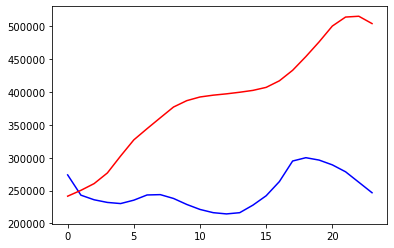

RMSE value:  158018.0719031143


In [63]:
howManyFutureHours = 24
window_size = 3
numEpochs = 20
iters = 5
columnsForDf = ['HLY_TEMP_NORMAL_SAC',
 'HLY_TEMP_10PCTL_SAC',
 'HLY_TEMP_90PCTL_SAC',
 'HLY_DEWP_NORMAL_SAC',
 'HLY_DEWP_10PCTL_SAC',
 'HLY_DEWP_90PCTL_SAC',
 'HLY_PRES_NORMAL_SAC',
 'HLY_PRES_10PCTL_SAC',
 'HLY_PRES_90PCTL_SAC',
 'HLY_CLDH_NORMAL_SAC',
 'HLY_HTDH_NORMAL_SAC',
 'HLY_CLOD_PCTCLR_SAC',
 'HLY_CLOD_PCTFEW_SAC',
 'HLY_CLOD_PCTSCT_SAC',
 'HLY_CLOD_PCTBKN_SAC',
 'HLY_CLOD_PCTOVC_SAC',
 'HLY_HIDX_NORMAL_SAC',
 'HLY_WCHL_NORMAL_SAC',
 'HLY_WIND_AVGSPD_SAC',
 'HLY_WIND_PCTCLM_SAC',
 'HLY_WIND_VCTDIR_SAC',
 'HLY_WIND_VCTSPD_SAC',
 'HLY_WIND_1STDIR_SAC',
 'HLY_WIND_1STPCT_SAC',
 'HLY_WIND_2NDDIR_SAC',
 'HLY_WIND_2NDPCT_SAC',
 'Day sin',
 'Day cos',
 'Year sin',
 'Year cos',
 'Megawatts_2019']
columns = ['HLY_TEMP_NORMAL_SAC',
 'HLY_TEMP_10PCTL_SAC',
 'HLY_TEMP_90PCTL_SAC',
 'HLY_DEWP_NORMAL_SAC',
 'HLY_DEWP_10PCTL_SAC',
 'HLY_DEWP_90PCTL_SAC',
 'HLY_PRES_NORMAL_SAC',
 'HLY_PRES_10PCTL_SAC',
 'HLY_PRES_90PCTL_SAC',
 'HLY_CLDH_NORMAL_SAC',
 'HLY_HTDH_NORMAL_SAC',
 'HLY_CLOD_PCTCLR_SAC',
 'HLY_CLOD_PCTFEW_SAC',
 'HLY_CLOD_PCTSCT_SAC',
 'HLY_CLOD_PCTBKN_SAC',
 'HLY_CLOD_PCTOVC_SAC',
 'HLY_HIDX_NORMAL_SAC',
 'HLY_WCHL_NORMAL_SAC',
 'HLY_WIND_AVGSPD_SAC',
 'HLY_WIND_PCTCLM_SAC',
 'HLY_WIND_VCTDIR_SAC',
 'HLY_WIND_VCTSPD_SAC',
 'HLY_WIND_1STDIR_SAC',
 'HLY_WIND_1STPCT_SAC',
 'HLY_WIND_2NDDIR_SAC',
 'HLY_WIND_2NDPCT_SAC']

bestPerformingModel(howManyFutureHours, window_size, numEpochs, iters, columnsForDf, columns)

In [46]:
i = 0
allVarFuturePreds = []
df = prepareDf()
numVars = 5 # 3 time steps, 5 variables (for weather variable prediction)
howManyFutureHours = 24
window_size = 3
columns = ['HLY_TEMP_NORMAL_SF', 'HLY_TEMP_10PCTL_SF', 'HLY_TEMP_90PCTL_SF', 'HLY_DEWP_NORMAL_SF', 
            'HLY_DEWP_10PCTL_SF', 'HLY_DEWP_90PCTL_SF', 'HLY_PRES_NORMAL_SF', 'HLY_PRES_10PCTL_SF', 
            'HLY_PRES_90PCTL_SF', 'HLY_CLDH_NORMAL_SF', 'HLY_HTDH_NORMAL_SF', 'HLY_CLOD_PCTCLR_SF', 
            'HLY_CLOD_PCTFEW_SF', 'HLY_CLOD_PCTSCT_SF', 'HLY_CLOD_PCTBKN_SF', 'HLY_CLOD_PCTOVC_SF', 
            'HLY_HIDX_NORMAL_SF', 'HLY_WCHL_NORMAL_SF', 'HLY_WIND_AVGSPD_SF', 'HLY_WIND_PCTCLM_SF', 
            'HLY_WIND_VCTDIR_SF', 'HLY_WIND_VCTSPD_SF', 'HLY_WIND_1STDIR_SF', 'HLY_WIND_1STPCT_SF', 
            'HLY_WIND_2NDDIR_SF', 'HLY_WIND_2NDPCT_SF']

bestWeatherDataModels = []
for column in columns:
    model = keras.models.load_model('Best/'+column)
    bestWeatherDataModels.append(model)
    
for column in columns:
    futurePredData = prepareCircularTimeData(df, column, howManyFutureHours, window_size)
    future_outputs = futurePredictions_weather(bestWeatherDataModels[i], futurePredData, howManyFutureHours, window_size, numVars)
    allVarFuturePreds.append(future_outputs)
    i+=1

[0.46648955]


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


----------------------------FINAL, DONE;----------------------------


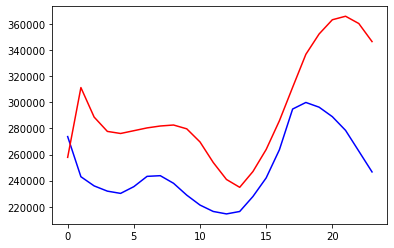

RMSE value:  51986.54256325195


In [52]:
df2 = pd.DataFrame(allVarFuturePreds)
df2 = df2.T
df2.columns = columns
# df2.to_csv('weatherPred.csv', encoding='utf-8', index = False) #MIGHT HAVE TO CHANGE THIS TO weatherPred + i

########################################## FUTURE PREDICTION #######################################################
weatherPred = df2
daySin = df['Day sin'][0:24]
dayCos = df['Day cos'][0:24]
yearSin = df['Year sin'][0:24]
yearCos = df['Year cos'][0:24]

addFiles = [daySin, dayCos, yearSin, yearCos]
weatherPred['Day sin'] = daySin.values
weatherPred['Day cos'] = dayCos.values
weatherPred['Year sin'] = yearSin.values
weatherPred['Year cos'] = yearCos.values
weatherPred['Megawatts_2020'] = 0

lastDay = df[-1:]
modelEnergy = keras.models.load_model('Best/'+'energyModel')
lst_output = futurePredictions_all(modelEnergy, lastDay, weatherPred, 24, 1, 31)

########################################### check output #######################################################
scaler_filename = 'Megawatts_2019.save'
megawattsScaler = joblib.load(scaler_filename)

predictedVals = megawattsScaler.inverse_transform(np.array(lst_output).reshape(-1,1))
predicted24Hours = pd.DataFrame(predictedVals)

check_directory = '/Users/yukahatori/A_Fairness/FairnessML_git/NOAA_and_CAISO_Data_2020/'
compFiles = [f for f in listdir(check_directory) if isfile(join(check_directory, f))] 
flies = []
for file in compFiles:
#     print(file)
    flies.append(check_directory + file)
df1 = pd.read_csv(flies[2])
actual24Hours = df1['Megawatts_2020'][:24]

print("----------------------------FINAL, DONE;----------------------------")
plt.plot(actual24Hours, color = 'blue')
plt.plot(predicted24Hours, color = 'red')
plt.show()

rmse = mean_squared_error(actual24Hours, predicted24Hours, squared=False)
print("RMSE value: ", rmse)

['HLY_TEMP_NORMAL_SAC',
 'HLY_TEMP_10PCTL_SAC',
 'HLY_TEMP_90PCTL_SAC',
 'HLY_DEWP_NORMAL_SAC',
 'HLY_DEWP_10PCTL_SAC',
 'HLY_DEWP_90PCTL_SAC',
 'HLY_PRES_NORMAL_SAC',
 'HLY_PRES_10PCTL_SAC',
 'HLY_PRES_90PCTL_SAC',
 'HLY_CLDH_NORMAL_SAC',
 'HLY_HTDH_NORMAL_SAC',
 'HLY_CLOD_PCTCLR_SAC',
 'HLY_CLOD_PCTFEW_SAC',
 'HLY_CLOD_PCTSCT_SAC',
 'HLY_CLOD_PCTBKN_SAC',
 'HLY_CLOD_PCTOVC_SAC',
 'HLY_HIDX_NORMAL_SAC',
 'HLY_WCHL_NORMAL_SAC',
 'HLY_WIND_AVGSPD_SAC',
 'HLY_WIND_PCTCLM_SAC',
 'HLY_WIND_VCTDIR_SAC',
 'HLY_WIND_VCTSPD_SAC',
 'HLY_WIND_1STDIR_SAC',
 'HLY_WIND_1STPCT_SAC',
 'HLY_WIND_2NDDIR_SAC',
 'HLY_WIND_2NDPCT_SAC',
 'Megawatts_2019',
 'Day sin',
 'Day cos',
 'Year sin',
 'Year cos']